In [1]:
from pyspark.sql import SparkSession
allocated_memory = 18 * 0.75

# create a SparkSession
spark = SparkSession.builder.appName("ReadJSON")\
.config("spark.executor.memory", "6g") \
.master("local[*]")  \
.config("spark.driver.memory", "4g") \
.config("spark.network.timeout", "800s")\
.config("spark.executor.heartbeatInterval", "200s")\
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.memory.fraction", "0.8") \
.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3")\
.getOrCreate()

# from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType

# Define the schema
# schema = StructType([
#     StructField("overall", FloatType(), True),
#     StructField("verified", BooleanType(), True),
#     StructField("reviewTime", StringType(), True),
#     StructField("reviewerID", StringType(), True),
#     StructField("asin", StringType(), True),
#     StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
#     StructField("reviewerName", StringType(), True),
#     StructField("reviewText", StringType(), True),
#     StructField("unixReviewTime", IntegerType(), True)

# ])
json_training_file_path ="../combined_train_data_chunked_10mb_latest.json"

:: loading settings :: url = jar:file:/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/soniasusanto/.ivy2/cache
The jars for the packages stored in: /Users/soniasusanto/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-93a4e4a1-66d7-4e5b-8085-1f4f42329218;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in local-m2-cache
	found org.apache.httpcomponents#httpclient;4.5.13 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.13 in local-m2-cache
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazona

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, ArrayType
# targetUDF = F.udf(lambda x: 1 if x >= 4.0 else (0 if x == 3.0 else -1), IntegerType())
targetUDF = F.udf(lambda x: 1 if x >= 4.0 else 0, IntegerType())

In [3]:
json_objects = []
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType
#"reviewerID": "A8WEXFRWX1ZHH",
# "asin": "0209688726",
# "style": {"Color:": " AC"},
# "reviewerName": "Goldengate",
# Define the schema
schema = StructType([
    StructField("overall", FloatType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", IntegerType(), True)

])
def pre_process(chunk):
    print("Processing chunk")
    df = spark.createDataFrame(json_objects, schema=schema)
    reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
    unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
    unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
    df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
    return df_sentiment

In [4]:
# Building the pipeline for nlp transformers
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import NGram, HashingTF, IDF, Tokenizer as MLTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
bigram = NGram(inputCol="tokens", outputCol="bigrams", n=2)
tf5   = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)
# create tokens from reviews
tk = MLTokenizer(inputCol= "reviewText", outputCol = "tokens")
# create tf-idf for each of the tokens
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)
# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

bigram_pipeline  = Pipeline(stages= [tk, bigram, tf5, idf, lr])

In [6]:

import sys
import json
import os
import shutil

from pyspark.sql.functions import rand
from pyspark.ml.pipeline import PipelineModel

def transform_chunk(df):
    nlpPipeline = get_nlp_pipeline()
    tokenized_df = nlpPipeline.fit(df).transform(df)
    tokenized_df.show(1)
    df6_train = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
    df_train_for_model = df6_train.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
    return df_train_for_model

# Define the maximum file size in bytes (10MB)
max_file_size = 10 * 1024 * 1024

json_objects = []
run = 0
# Read the file line by line until the maximum file size is reached
with open(json_training_file_path, 'r') as file:
    total_size = 0
    for line in file:
        # Calculate the size of the current line
        line_size = sys.getsizeof(line)

        # If adding the current line exceeds the maximum file size, stop reading
        if total_size + line_size >= max_file_size:
            print('Begin preprocessing')
            # Create a DataFrame from the list of JSON objects
            df = pre_process(json_objects)
            print("Show the first row of the preprocessed chunk:")
            df.show(1)
            df_train = transform_chunk(df)
            print("Show the first row of the transformed chunk:")
            df_train.show(1)
            print("Run %d" % run)
            if os.path.exists('bigram_pipeline_model_3'):
                loaded_model = PipelineModel.load('bigram_pipeline_model_3')
                stages_steps = loaded_model.stages
                updated_model = Pipeline(stages = stages_steps).fit(df_train)
            else:
                updated_model = bigram_pipeline.fit(df_train)

            updated_model.write().overwrite().save('bigram_pipeline_model_3')
            run += 1
            print('Model saved for current chunk')
            del df
            del df_train
            json_objects = []
            total_size = 0
        # Otherwise, add the line to the list of JSON objects
        json_objects.append(json.loads(line))
        total_size += line_size

Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:32:37 WARN TaskSetManager: Stage 0 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:32:45 WARN TaskSetManager: Stage 3 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|[{document, 0, 68...|[{token, 0, 5, ha...|[{token, 0, 5, ha...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


24/04/26 00:32:47 WARN TaskSetManager: Stage 6 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|havent had a chan...|    1|[havent, chance, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 0


24/04/26 00:32:50 WARN TaskSetManager: Stage 9 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:03 WARN TaskSetManager: Stage 12 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:05 WARN TaskSetManager: Stage 13 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/26 00:33:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/26 00:33:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/04/26 00:33:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/26 00:33:22 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/26 00:33:23 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/26 00:33

Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:33:35 WARN TaskSetManager: Stage 80 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100G6E9WHV2GJ|B00005TQI7|granddaughter lov...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:33:37 WARN TaskSetManager: Stage 83 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:38 WARN TaskSetManager: Stage 86 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100G6E9WHV2GJ|B00005TQI7|granddaughter lov...|        1|[{document, 0, 20...|[{token, 0, 12, g...|[{token, 0, 12, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|granddaughter lov...|    1|[granddaughter, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 1


24/04/26 00:33:44 WARN TaskSetManager: Stage 110 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:45 WARN TaskSetManager: Stage 114 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:33:47 WARN TaskSetManager: Stage 117 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05099234F32V2RI0KG4|B0001AEZTG|Fun stacker with ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:33:48 WARN TaskSetManager: Stage 120 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:50 WARN TaskSetManager: Stage 123 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A05099234F32V2RI0KG4|B0001AEZTG|Fun stacker with ...|        1|[{document, 0, 10...|[{token, 0, 2, Fu...|[{token, 0, 2, Fu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fun stacker with ...|    1|[Fun, stacker, lo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 2


24/04/26 00:33:55 WARN TaskSetManager: Stage 147 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:33:55 WARN TaskSetManager: Stage 151 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:33:57 WARN TaskSetManager: Stage 154 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100G6N0OTQ2TU|B000B6AH7O|My grandson just ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:33:58 WARN TaskSetManager: Stage 157 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:00 WARN TaskSetManager: Stage 160 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100G6N0OTQ2TU|B000B6AH7O|My grandson just ...|        1|[{document, 0, 17...|[{token, 0, 1, My...|[{token, 3, 10, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My grandson just ...|    1|[grandson, turned...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 3


24/04/26 00:34:05 WARN TaskSetManager: Stage 184 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:06 WARN TaskSetManager: Stage 188 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:34:07 WARN TaskSetManager: Stage 191 contains a task of very large size (1245 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0261335MGUP6K91KAAP|B000G3LR9Y|smaller than we t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:34:09 WARN TaskSetManager: Stage 194 contains a task of very large size (1245 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:11 WARN TaskSetManager: Stage 197 contains a task of very large size (1245 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0261335MGUP6K91KAAP|B000G3LR9Y|smaller than we t...|        0|[{document, 0, 13...|[{token, 0, 6, sm...|[{token, 0, 6, sm...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|smaller than we t...|    0|[smaller, thought...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 4


24/04/26 00:34:16 WARN TaskSetManager: Stage 221 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:16 WARN TaskSetManager: Stage 225 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:34:17 WARN TaskSetManager: Stage 228 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101C99CG8EFUH|B000HV0EJ4|MY 3 year old dau...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:34:19 WARN TaskSetManager: Stage 231 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:21 WARN TaskSetManager: Stage 234 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101C99CG8EFUH|B000HV0EJ4|MY 3 year old dau...|        1|[{document, 0, 57...|[{token, 0, 1, MY...|[{token, 3, 3, 3,...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|MY 3 year old dau...|    1|[3, year, old, da...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 5


24/04/26 00:34:25 WARN TaskSetManager: Stage 258 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:26 WARN TaskSetManager: Stage 262 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:34:27 WARN TaskSetManager: Stage 265 contains a task of very large size (1122 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0520115DWXNOTVY58MS|B000LSZVJQ|7 month old loves...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:34:29 WARN TaskSetManager: Stage 268 contains a task of very large size (1122 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:31 WARN TaskSetManager: Stage 271 contains a task of very large size (1122 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0520115DWXNOTVY58MS|B000LSZVJQ|7 month old loves...|        1|[{document, 0, 22...|[{token, 0, 0, 7,...|[{token, 0, 0, 7,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|7 month old loves...|    1|[7, month, old, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 6


24/04/26 00:34:36 WARN TaskSetManager: Stage 295 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:37 WARN TaskSetManager: Stage 299 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0704884RAO7EE4OR2BO|B000PU3GYM|The granddaughter...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0704884RAO7EE4OR2BO|B000PU3GYM|The granddaughter...|        1|[{document, 0, 87...|[{token, 0, 2, Th...|[{token, 4, 17, g...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The granddaughter...|    1|[granddaughters, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 7


24/04/26 00:34:46 WARN TaskSetManager: Stage 332 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:47 WARN TaskSetManager: Stage 336 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0610173AX4RY4WQ9LR7|B000YFUQ7I|Got it for the gr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0610173AX4RY4WQ9LR7|B000YFUQ7I|Got it for the gr...|        1|[{document, 0, 46...|[{token, 0, 2, Go...|[{token, 0, 2, Go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got it for the gr...|    1|[Got, grandson, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 8


24/04/26 00:34:56 WARN TaskSetManager: Stage 369 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:34:57 WARN TaskSetManager: Stage 373 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:34:58 WARN TaskSetManager: Stage 376 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A102QRKSKT5XMR|B0015KSRAY|We received this ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:35:00 WARN TaskSetManager: Stage 379 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:01 WARN TaskSetManager: Stage 382 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A102QRKSKT5XMR|B0015KSRAY|We received this ...|        0|[{document, 0, 43...|[{token, 0, 1, We...|[{token, 3, 10, r...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We received this ...|    0|[received, birthd...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 9


24/04/26 00:35:06 WARN TaskSetManager: Stage 406 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:06 WARN TaskSetManager: Stage 410 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:08 WARN TaskSetManager: Stage 413 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0610173AX4RY4WQ9LR7|B000YFUQ7I|Got it for the gr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:35:10 WARN TaskSetManager: Stage 416 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:11 WARN TaskSetManager: Stage 419 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0610173AX4RY4WQ9LR7|B000YFUQ7I|Got it for the gr...|        1|[{document, 0, 46...|[{token, 0, 2, Go...|[{token, 0, 2, Go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got it for the gr...|    1|[Got, grandson, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 10


24/04/26 00:35:16 WARN TaskSetManager: Stage 443 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:17 WARN TaskSetManager: Stage 447 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:18 WARN TaskSetManager: Stage 450 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1004GT12DH8CW|B0010SGZEG|Great bath toys f...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:35:20 WARN TaskSetManager: Stage 453 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:21 WARN TaskSetManager: Stage 456 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1004GT12DH8CW|B0010SGZEG|Great bath toys f...|        1|[{document, 0, 28...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great bath toys f...|    1|[Great, bath, toy...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 11


24/04/26 00:35:26 WARN TaskSetManager: Stage 480 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:26 WARN TaskSetManager: Stage 484 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:28 WARN TaskSetManager: Stage 487 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0016H5BD2|GREAT set of card...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:35:29 WARN TaskSetManager: Stage 490 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:30 WARN TaskSetManager: Stage 493 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0001528BGUBOEVR6T5U|B0016H5BD2|GREAT set of card...|        1|[{document, 0, 20...|[{token, 0, 4, GR...|[{token, 0, 4, GR...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|GREAT set of card...|    1|[GREAT, set, card...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 12


24/04/26 00:35:35 WARN TaskSetManager: Stage 517 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:36 WARN TaskSetManager: Stage 521 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:37 WARN TaskSetManager: Stage 524 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0019PU8XE|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 00:35:39 WARN TaskSetManager: Stage 527 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:40 WARN TaskSetManager: Stage 530 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0001528BGUBOEVR6T5U|B0019PU8XE|super nice...|        1|[{document, 0, 12...|[{token, 0, 4, su...|[{token, 0, 4, su...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 13


24/04/26 00:35:45 WARN TaskSetManager: Stage 554 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:45 WARN TaskSetManager: Stage 558 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:47 WARN TaskSetManager: Stage 561 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A07461691T3ZPYIJW2MO|B001L2F5II|       5/5|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:35:48 WARN TaskSetManager: Stage 564 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:50 WARN TaskSetManager: Stage 567 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A07461691T3ZPYIJW2MO|B001L2F5II|       5/5|        1|[{document, 0, 2,...|[{token, 0, 2, 5/...|[{token, 0, 2, 5/...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|       5/5|    1|[5/5]|
+----------+-----+-----+
only showing top 1 row

Run 14


24/04/26 00:35:54 WARN TaskSetManager: Stage 591 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:35:55 WARN TaskSetManager: Stage 595 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:35:56 WARN TaskSetManager: Stage 598 contains a task of very large size (1110 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A00222906VX8GH7X6J6B|B001US4DOK|good quality|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



24/04/26 00:35:58 WARN TaskSetManager: Stage 601 contains a task of very large size (1110 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:00 WARN TaskSetManager: Stage 604 contains a task of very large size (1110 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00222906VX8GH7X6J6B|B001US4DOK|good quality|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good quality|    1|[good, quality]|
+------------+-----+---------------+
only showing top 1 row

Run 15


24/04/26 00:36:05 WARN TaskSetManager: Stage 628 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:05 WARN TaskSetManager: Stage 632 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:36:07 WARN TaskSetManager: Stage 635 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0903711K6ZVUD1AJCNJ|B002NXK4BW|5 stars is approp...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:36:08 WARN TaskSetManager: Stage 638 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:10 WARN TaskSetManager: Stage 641 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0903711K6ZVUD1AJCNJ|B002NXK4BW|5 stars is approp...|        1|[{document, 0, 14...|[{token, 0, 0, 5,...|[{token, 0, 0, 5,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5 stars is approp...|    1|[5, stars, approp...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 16


24/04/26 00:36:15 WARN TaskSetManager: Stage 665 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:16 WARN TaskSetManager: Stage 669 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:36:17 WARN TaskSetManager: Stage 672 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0952394J96P9CBWGK9Y|B003D6BLW4|Great game to wor...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:36:18 WARN TaskSetManager: Stage 675 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:20 WARN TaskSetManager: Stage 678 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0952394J96P9CBWGK9Y|B003D6BLW4|Great game to wor...|        1|[{document, 0, 16...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great game to wor...|    1|[Great, game, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 17


24/04/26 00:36:24 WARN TaskSetManager: Stage 702 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:25 WARN TaskSetManager: Stage 706 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B003T0HIR6|grandkids fought ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B003T0HIR6|grandkids fought ...|        1|[{document, 0, 23...|[{token, 0, 8, gr...|[{token, 0, 8, gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+-------------------+
|          reviewText|label|              token|
+--------------------+-----+-------------------+
|grandkids fought ...|    1|[grandkids, fought]|
+--------------------+-----+-------------------+
only showing top 1 row

Run 18


24/04/26 00:36:34 WARN TaskSetManager: Stage 739 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:35 WARN TaskSetManager: Stage 743 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:36:36 WARN TaskSetManager: Stage 746 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1007HV4X30DCB|B004K4V74K|My Grandson Loves...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:36:38 WARN TaskSetManager: Stage 749 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:39 WARN TaskSetManager: Stage 752 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1007HV4X30DCB|B004K4V74K|My Grandson Loves...|        1|[{document, 0, 21...|[{token, 0, 1, My...|[{token, 3, 10, G...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My Grandson Loves...|    1|[Grandson, Loves,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 19


24/04/26 00:36:44 WARN TaskSetManager: Stage 776 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:44 WARN TaskSetManager: Stage 780 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:36:45 WARN TaskSetManager: Stage 783 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A106SKF0XLC2VL|B004UA552E|I bought this for...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:36:47 WARN TaskSetManager: Stage 786 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:49 WARN TaskSetManager: Stage 789 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A106SKF0XLC2VL|B004UA552E|I bought this for...|        1|[{document, 0, 79...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this for...|    1|[bought, grandchi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 20


24/04/26 00:36:54 WARN TaskSetManager: Stage 813 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:54 WARN TaskSetManager: Stage 817 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:36:55 WARN TaskSetManager: Stage 820 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100297S0KWNIB|B0050QJT6U|Absolutely love. ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:36:57 WARN TaskSetManager: Stage 823 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:36:58 WARN TaskSetManager: Stage 826 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100297S0KWNIB|B0050QJT6U|Absolutely love. ...|        1|[{document, 0, 18...|[{token, 0, 9, Ab...|[{token, 0, 9, Ab...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Absolutely love. ...|    1|[Absolutely, love...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 21


24/04/26 00:37:03 WARN TaskSetManager: Stage 850 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:04 WARN TaskSetManager: Stage 854 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:05 WARN TaskSetManager: Stage 857 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0516005NLXNKCMT2YI9|B005N548KK|This was a Christ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:37:06 WARN TaskSetManager: Stage 860 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:08 WARN TaskSetManager: Stage 863 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0516005NLXNKCMT2YI9|B005N548KK|This was a Christ...|        1|[{document, 0, 44...|[{token, 0, 3, Th...|[{token, 11, 19, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a Christ...|    1|[Christmas, gift,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 22


24/04/26 00:37:13 WARN TaskSetManager: Stage 887 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:13 WARN TaskSetManager: Stage 891 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:14 WARN TaskSetManager: Stage 894 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100JY2S79BBM6|B005OLZ1JA|   Awesome|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:37:16 WARN TaskSetManager: Stage 897 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:17 WARN TaskSetManager: Stage 900 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A100JY2S79BBM6|B005OLZ1JA|   Awesome|        1|[{document, 0, 6,...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+---------+
|reviewText|label|    token|
+----------+-----+---------+
|   Awesome|    1|[Awesome]|
+----------+-----+---------+
only showing top 1 row

Run 23


24/04/26 00:37:22 WARN TaskSetManager: Stage 924 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:23 WARN TaskSetManager: Stage 928 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:24 WARN TaskSetManager: Stage 931 contains a task of very large size (1254 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0312972X0AKL1EYXWTQ|B006RQ8TY0|My 2 and 3 year o...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:37:26 WARN TaskSetManager: Stage 934 contains a task of very large size (1254 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:27 WARN TaskSetManager: Stage 937 contains a task of very large size (1254 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0312972X0AKL1EYXWTQ|B006RQ8TY0|My 2 and 3 year o...|        1|[{document, 0, 10...|[{token, 0, 1, My...|[{token, 3, 3, 2,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 2 and 3 year o...|    1|[2, 3, year, old,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 24


24/04/26 00:37:32 WARN TaskSetManager: Stage 961 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:32 WARN TaskSetManager: Stage 965 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:33 WARN TaskSetManager: Stage 968 contains a task of very large size (1014 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A102D5EZDH2TS1|B0076O26PK|I have used "poun...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:37:35 WARN TaskSetManager: Stage 971 contains a task of very large size (1014 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:36 WARN TaskSetManager: Stage 974 contains a task of very large size (1014 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A102D5EZDH2TS1|B0076O26PK|I have used "poun...|        0|[{document, 0, 37...|[{token, 0, 0, I,...|[{token, 7, 10, u...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have used "poun...|    0|[used, ", pound, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 25


24/04/26 00:37:41 WARN TaskSetManager: Stage 998 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:42 WARN TaskSetManager: Stage 1002 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:43 WARN TaskSetManager: Stage 1005 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0084095I44XW7DFH0TP|B007EA5ZRW|Cute toy, my son ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:37:45 WARN TaskSetManager: Stage 1008 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:46 WARN TaskSetManager: Stage 1011 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0084095I44XW7DFH0TP|B007EA5ZRW|Cute toy, my son ...|        1|[{document, 0, 17...|[{token, 0, 3, Cu...|[{token, 0, 3, Cu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Cute toy, my son ...|    1|[Cute, toy, ,, so...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 26


24/04/26 00:37:51 WARN TaskSetManager: Stage 1035 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:51 WARN TaskSetManager: Stage 1039 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:37:53 WARN TaskSetManager: Stage 1042 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1008EX7LQ3AKP|B008TN6B7Q|my kids love finn...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:37:54 WARN TaskSetManager: Stage 1045 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:37:56 WARN TaskSetManager: Stage 1048 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1008EX7LQ3AKP|B008TN6B7Q|my kids love finn...|        1|[{document, 0, 72...|[{token, 0, 1, my...|[{token, 3, 6, ki...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my kids love finn...|    1|[kids, love, finn...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 27


24/04/26 00:38:00 WARN TaskSetManager: Stage 1072 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:01 WARN TaskSetManager: Stage 1076 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0017882XAS5VJGSZF5R|B00979AHC6|So in the picture...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A0017882XAS5VJGSZF5R|B00979AHC6|So in the picture...|        0|[{document, 0, 64...|[{token, 0, 1, So...|[{token, 10, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|So in the picture...|    0|[picture, saw, ni...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 28


24/04/26 00:38:10 WARN TaskSetManager: Stage 1109 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:10 WARN TaskSetManager: Stage 1113 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0182108CPDLPRCXQUZQ|B00ABY8WVO|Wish it was bigge...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0182108CPDLPRCXQUZQ|B00ABY8WVO|Wish it was bigge...|        1|[{document, 0, 20...|[{token, 0, 3, Wi...|[{token, 0, 3, Wi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wish it was bigge...|    1|[Wish, bigger, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 29


24/04/26 00:38:19 WARN TaskSetManager: Stage 1146 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:20 WARN TaskSetManager: Stage 1150 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:38:21 WARN TaskSetManager: Stage 1153 contains a task of very large size (1065 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A100WFKYVRPVX7|B00B8O3XY2|Item arrived as e...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:38:22 WARN TaskSetManager: Stage 1156 contains a task of very large size (1065 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:24 WARN TaskSetManager: Stage 1159 contains a task of very large size (1065 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A100WFKYVRPVX7|B00B8O3XY2|Item arrived as e...|        0|[{document, 0, 13...|[{token, 0, 3, It...|[{token, 0, 3, It...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Item arrived as e...|    0|[Item, arrived, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 30


24/04/26 00:38:28 WARN TaskSetManager: Stage 1183 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:29 WARN TaskSetManager: Stage 1187 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:38:30 WARN TaskSetManager: Stage 1190 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0718466DJ0Y591VLAL7|B00BG4P5N6|Broke in no time....|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:38:32 WARN TaskSetManager: Stage 1193 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:33 WARN TaskSetManager: Stage 1196 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0718466DJ0Y591VLAL7|B00BG4P5N6|Broke in no time....|        0|[{document, 0, 34...|[{token, 0, 4, Br...|[{token, 0, 4, Br...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Broke in no time....|    0|[Broke, time, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 31


24/04/26 00:38:38 WARN TaskSetManager: Stage 1220 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:39 WARN TaskSetManager: Stage 1224 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A07461691T3ZPYIJW2MO|B00BW0RF3W|       5/5|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A07461691T3ZPYIJW2MO|B00BW0RF3W|       5/5|        1|[{document, 0, 2,...|[{token, 0, 2, 5/...|[{token, 0, 2, 5/...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|       5/5|    1|[5/5]|
+----------+-----+-----+
only showing top 1 row

Run 32


24/04/26 00:38:47 WARN TaskSetManager: Stage 1257 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:48 WARN TaskSetManager: Stage 1261 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:38:49 WARN TaskSetManager: Stage 1264 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100E3ZWKOHXQR|B00CG416Y2|Antsy 2+ year old...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:38:51 WARN TaskSetManager: Stage 1267 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:52 WARN TaskSetManager: Stage 1270 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100E3ZWKOHXQR|B00CG416Y2|Antsy 2+ year old...|        1|[{document, 0, 44...|[{token, 0, 4, An...|[{token, 0, 4, An...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Antsy 2+ year old...|    1|[Antsy, 2+, year,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 33


24/04/26 00:38:57 WARN TaskSetManager: Stage 1294 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:38:57 WARN TaskSetManager: Stage 1298 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:38:59 WARN TaskSetManager: Stage 1301 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0601517E89YMEPRCYI0|B00CRSXK4Q|If you like to pl...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:39:00 WARN TaskSetManager: Stage 1304 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:02 WARN TaskSetManager: Stage 1307 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0601517E89YMEPRCYI0|B00CRSXK4Q|If you like to pl...|        0|[{document, 0, 55...|[{token, 0, 1, If...|[{token, 7, 10, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you like to pl...|    0|[like, play, mode...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 34


24/04/26 00:39:06 WARN TaskSetManager: Stage 1331 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:07 WARN TaskSetManager: Stage 1335 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0261335MGUP6K91KAAP|B00DTTJHM6|smaller than anti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0261335MGUP6K91KAAP|B00DTTJHM6|smaller than anti...|        1|[{document, 0, 16...|[{token, 0, 6, sm...|[{token, 0, 6, sm...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|smaller than anti...|    1|[smaller, anticip...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 35


24/04/26 00:39:16 WARN TaskSetManager: Stage 1368 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:17 WARN TaskSetManager: Stage 1372 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:39:18 WARN TaskSetManager: Stage 1375 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0520115DWXNOTVY58MS|B00EAHXOWA|It doesn't actual...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:39:20 WARN TaskSetManager: Stage 1378 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:21 WARN TaskSetManager: Stage 1381 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0520115DWXNOTVY58MS|B00EAHXOWA|It doesn't actual...|        1|[{document, 0, 40...|[{token, 0, 1, It...|[{token, 11, 18, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It doesn't actual...|    1|[actually, work, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 36


24/04/26 00:39:26 WARN TaskSetManager: Stage 1405 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:26 WARN TaskSetManager: Stage 1409 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:39:27 WARN TaskSetManager: Stage 1412 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0084095I44XW7DFH0TP|B00FDJY6N0|Other commenters ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:39:29 WARN TaskSetManager: Stage 1415 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:31 WARN TaskSetManager: Stage 1418 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0084095I44XW7DFH0TP|B00FDJY6N0|Other commenters ...|        1|[{document, 0, 31...|[{token, 0, 4, Ot...|[{token, 6, 15, c...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Other commenters ...|    1|[commenters, comp...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 37


24/04/26 00:39:35 WARN TaskSetManager: Stage 1442 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:36 WARN TaskSetManager: Stage 1446 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A01910163UJ08PFOKPI6|B00FURVI6S|I ordered 2 of th...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A01910163UJ08PFOKPI6|B00FURVI6S|I ordered 2 of th...|        0|[{document, 0, 65...|[{token, 0, 0, I,...|[{token, 2, 8, or...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I ordered 2 of th...|    0|[ordered, 2, time...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 38


24/04/26 00:39:44 WARN TaskSetManager: Stage 1479 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:45 WARN TaskSetManager: Stage 1483 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0403142PTCZBLIH0GEF|B00HUMNWN8|Amazing Product! ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0403142PTCZBLIH0GEF|B00HUMNWN8|Amazing Product! ...|        1|[{document, 0, 57...|[{token, 0, 6, Am...|[{token, 0, 6, Am...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Amazing Product! ...|    1|[Amazing, Product...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 39


24/04/26 00:39:54 WARN TaskSetManager: Stage 1516 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:54 WARN TaskSetManager: Stage 1520 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:39:56 WARN TaskSetManager: Stage 1523 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B00HZHB0NC|Very interesting ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:39:58 WARN TaskSetManager: Stage 1526 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:39:59 WARN TaskSetManager: Stage 1529 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0103047AS0C8QKUI0X2|B00HZHB0NC|Very interesting ...|        1|[{document, 0, 58...|[{token, 0, 3, Ve...|[{token, 5, 15, i...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very interesting ...|    1|[interesting, toy...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 40


24/04/26 00:40:03 WARN TaskSetManager: Stage 1553 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:04 WARN TaskSetManager: Stage 1557 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:40:05 WARN TaskSetManager: Stage 1560 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1027USCJ8G50N|B00IVFCK6I|She is very cool ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:40:07 WARN TaskSetManager: Stage 1563 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:08 WARN TaskSetManager: Stage 1566 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1027USCJ8G50N|B00IVFCK6I|She is very cool ...|        1|[{document, 0, 52...|[{token, 0, 2, Sh...|[{token, 12, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She is very cool ...|    1|[cool, looking, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 41


24/04/26 00:40:13 WARN TaskSetManager: Stage 1590 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:13 WARN TaskSetManager: Stage 1594 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A00222906VX8GH7X6J6B|B00J1XE7B0|good quality|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00222906VX8GH7X6J6B|B00J1XE7B0|good quality|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good quality|    1|[good, quality]|
+------------+-----+---------------+
only showing top 1 row

Run 42


24/04/26 00:40:22 WARN TaskSetManager: Stage 1627 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:23 WARN TaskSetManager: Stage 1631 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0441396WX3GNL93BT38|B00J6245M2|too small and for...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0441396WX3GNL93BT38|B00J6245M2|too small and for...|        0|[{document, 0, 28...|[{token, 0, 2, to...|[{token, 4, 8, sm...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------+
|          reviewText|label|         token|
+--------------------+-----+--------------+
|too small and for...|    0|[small, price]|
+--------------------+-----+--------------+
only showing top 1 row

Run 43


24/04/26 00:40:32 WARN TaskSetManager: Stage 1664 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:32 WARN TaskSetManager: Stage 1668 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:40:33 WARN TaskSetManager: Stage 1671 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0944456Z3LN62I2DT3O|B00KR2JLOC|Sounds loud when ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:40:35 WARN TaskSetManager: Stage 1674 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:36 WARN TaskSetManager: Stage 1677 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0944456Z3LN62I2DT3O|B00KR2JLOC|Sounds loud when ...|        1|[{document, 0, 36...|[{token, 0, 5, So...|[{token, 0, 5, So...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sounds loud when ...|    1|[Sounds, loud, on...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 44


24/04/26 00:40:41 WARN TaskSetManager: Stage 1701 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:42 WARN TaskSetManager: Stage 1705 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B00M27R2VO|This toy turned o...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0103047AS0C8QKUI0X2|B00M27R2VO|This toy turned o...|        1|[{document, 0, 27...|[{token, 0, 3, Th...|[{token, 5, 7, to...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This toy turned o...|    1|[toy, turned, one...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 45


24/04/26 00:40:50 WARN TaskSetManager: Stage 1738 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:40:51 WARN TaskSetManager: Stage 1742 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00MJYDIGS|my grandson was s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00MJYDIGS|my grandson was s...|        1|[{document, 0, 37...|[{token, 0, 1, my...|[{token, 3, 10, g...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my grandson was s...|    1|[grandson, happy,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 46


24/04/26 00:41:00 WARN TaskSetManager: Stage 1775 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:01 WARN TaskSetManager: Stage 1779 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:41:02 WARN TaskSetManager: Stage 1782 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101C7U4P268CU|B00N897M5Q|Holds up well, bu...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:41:04 WARN TaskSetManager: Stage 1785 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:05 WARN TaskSetManager: Stage 1788 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101C7U4P268CU|B00N897M5Q|Holds up well, bu...|        0|[{document, 0, 57...|[{token, 0, 4, Ho...|[{token, 0, 4, Ho...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Holds up well, bu...|    0|[Holds, well, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 47


24/04/26 00:41:10 WARN TaskSetManager: Stage 1812 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:10 WARN TaskSetManager: Stage 1816 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A02851222LSCKUNF0G8V|B00OM259LW|Great toy my todd...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A02851222LSCKUNF0G8V|B00OM259LW|Great toy my todd...|        1|[{document, 0, 41...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great toy my todd...|    1|[Great, toy, todd...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 48


24/04/26 00:41:20 WARN TaskSetManager: Stage 1849 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:21 WARN TaskSetManager: Stage 1853 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0655978MSC28U7LBJ3|B00Q788QPK|Very Durable was ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0655978MSC28U7LBJ3|B00Q788QPK|Very Durable was ...|        1|[{document, 0, 28...|[{token, 0, 3, Ve...|[{token, 5, 11, D...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+------------------+
|          reviewText|label|             token|
+--------------------+-----+------------------+
|Very Durable was ...|    1|[Durable, pleased]|
+--------------------+-----+------------------+
only showing top 1 row

Run 49


24/04/26 00:41:30 WARN TaskSetManager: Stage 1886 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:30 WARN TaskSetManager: Stage 1890 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:41:31 WARN TaskSetManager: Stage 1893 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B00SY8519U|Used to replace t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:41:33 WARN TaskSetManager: Stage 1896 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:34 WARN TaskSetManager: Stage 1899 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0196552RI15HI7JB9PW|B00SY8519U|Used to replace t...|        1|[{document, 0, 23...|[{token, 0, 3, Us...|[{token, 0, 3, Us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Used to replace t...|    1|[Used, replace, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 50


24/04/26 00:41:39 WARN TaskSetManager: Stage 1923 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:40 WARN TaskSetManager: Stage 1927 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:41:41 WARN TaskSetManager: Stage 1930 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A02851222LSCKUNF0G8V|B00T3G1TUC|Nice toys, i woul...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:41:43 WARN TaskSetManager: Stage 1933 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:44 WARN TaskSetManager: Stage 1936 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A02851222LSCKUNF0G8V|B00T3G1TUC|Nice toys, i woul...|        1|[{document, 0, 10...|[{token, 0, 3, Ni...|[{token, 0, 3, Ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice toys, i woul...|    1|[Nice, toys, ,, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 51


24/04/26 00:41:49 WARN TaskSetManager: Stage 1960 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:49 WARN TaskSetManager: Stage 1964 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0520115DWXNOTVY58MS|B00TY419OY|Bought this for m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0520115DWXNOTVY58MS|B00TY419OY|Bought this for m...|        1|[{document, 0, 55...|[{token, 0, 5, Bo...|[{token, 0, 5, Bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this for m...|    1|[Bought, biggest,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 52


24/04/26 00:41:59 WARN TaskSetManager: Stage 1997 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:41:59 WARN TaskSetManager: Stage 2001 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:42:00 WARN TaskSetManager: Stage 2004 contains a task of very large size (1066 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0411582HESXIBG0OEI4|B00WHZ9SSG|Playskool, you're...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:42:02 WARN TaskSetManager: Stage 2007 contains a task of very large size (1066 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:04 WARN TaskSetManager: Stage 2010 contains a task of very large size (1066 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0411582HESXIBG0OEI4|B00WHZ9SSG|Playskool, you're...|        1|[{document, 0, 34...|[{token, 0, 8, Pl...|[{token, 0, 8, Pl...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Playskool, you're...|    1|[Playskool, ,, Ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 53


24/04/26 00:42:08 WARN TaskSetManager: Stage 2034 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:09 WARN TaskSetManager: Stage 2038 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:42:10 WARN TaskSetManager: Stage 2041 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B00XTZ3TB0|Five stars for th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:42:12 WARN TaskSetManager: Stage 2044 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:13 WARN TaskSetManager: Stage 2047 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B00XTZ3TB0|Five stars for th...|        1|[{document, 0, 16...|[{token, 0, 3, Fi...|[{token, 0, 3, Fi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Five stars for th...|    1|[Five, stars, lig...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 54


24/04/26 00:42:18 WARN TaskSetManager: Stage 2071 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:19 WARN TaskSetManager: Stage 2075 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1004AX2J2HXGL|B00YZ5D5CQ|Not a bad version...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A1004AX2J2HXGL|B00YZ5D5CQ|Not a bad version...|        0|[{document, 0, 11...|[{token, 0, 2, No...|[{token, 6, 8, ba...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not a bad version...|    0|[bad, version, OG...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 55


24/04/26 00:42:27 WARN TaskSetManager: Stage 2108 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:28 WARN TaskSetManager: Stage 2112 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:42:29 WARN TaskSetManager: Stage 2115 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0411582HESXIBG0OEI4|B01445YTE4|Chone manya weesh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:42:31 WARN TaskSetManager: Stage 2118 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:32 WARN TaskSetManager: Stage 2121 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0411582HESXIBG0OEI4|B01445YTE4|Chone manya weesh...|        1|[{document, 0, 29...|[{token, 0, 4, Ch...|[{token, 0, 4, Ch...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Chone manya weesh...|    1|[Chone, manya, we...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 56


24/04/26 00:42:37 WARN TaskSetManager: Stage 2145 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:38 WARN TaskSetManager: Stage 2149 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:42:39 WARN TaskSetManager: Stage 2152 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0403142PTCZBLIH0GEF|B015CCR6RU|Fast shipping!! L...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:42:40 WARN TaskSetManager: Stage 2155 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:42 WARN TaskSetManager: Stage 2158 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0403142PTCZBLIH0GEF|B015CCR6RU|Fast shipping!! L...|        1|[{document, 0, 25...|[{token, 0, 3, Fa...|[{token, 0, 3, Fa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast shipping!! L...|    1|[Fast, shipping, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 57


24/04/26 00:42:46 WARN TaskSetManager: Stage 2182 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:47 WARN TaskSetManager: Stage 2186 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:42:48 WARN TaskSetManager: Stage 2189 contains a task of very large size (1073 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A06537817FOGTW3Z6J82|B017IQZA76|grandkids love th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:42:50 WARN TaskSetManager: Stage 2192 contains a task of very large size (1073 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:51 WARN TaskSetManager: Stage 2195 contains a task of very large size (1073 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A06537817FOGTW3Z6J82|B017IQZA76|grandkids love th...|        1|[{document, 0, 37...|[{token, 0, 8, gr...|[{token, 0, 8, gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|grandkids love th...|    1|[grandkids, love,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 58


24/04/26 00:42:56 WARN TaskSetManager: Stage 2219 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:42:57 WARN TaskSetManager: Stage 2223 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-----------+---------+
|overall|          reviewerID|      asin| reviewText|sentiment|
+-------+--------------------+----------+-----------+---------+
|    4.0|A0441818S7W7N4A7QL55|B018VLH7D2|As expected|        1|
+-------+--------------------+----------+-----------+---------+
only showing top 1 row



+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin| reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|    4.0|A0441818S7W7N4A7QL55|B018VLH7D2|As expected|        1|[{document, 0, 10...|[{token, 0, 1, As...|[{token, 3, 10, e...|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------+-----+----------+
| reviewText|label|     token|
+-----------+-----+----------+
|As expected|    1|[expected]|
+-----------+-----+----------+
only showing top 1 row

Run 59


24/04/26 00:43:05 WARN TaskSetManager: Stage 2256 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:06 WARN TaskSetManager: Stage 2260 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:43:07 WARN TaskSetManager: Stage 2263 contains a task of very large size (1372 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A04398648EN1EYQIVAUQ|B01AY6XDSU|Can't give review...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:43:08 WARN TaskSetManager: Stage 2266 contains a task of very large size (1372 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:10 WARN TaskSetManager: Stage 2269 contains a task of very large size (1372 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A04398648EN1EYQIVAUQ|B01AY6XDSU|Can't give review...|        1|[{document, 0, 65...|[{token, 0, 4, Ca...|[{token, 6, 9, gi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Can't give review...|    1|[give, review, ye...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 60


24/04/26 00:43:15 WARN TaskSetManager: Stage 2293 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:15 WARN TaskSetManager: Stage 2297 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:43:16 WARN TaskSetManager: Stage 2300 contains a task of very large size (1211 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0312972X0AKL1EYXWTQ|B01BOYCMJM|I was impressed w...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:43:18 WARN TaskSetManager: Stage 2303 contains a task of very large size (1211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:20 WARN TaskSetManager: Stage 2306 contains a task of very large size (1211 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0312972X0AKL1EYXWTQ|B01BOYCMJM|I was impressed w...|        1|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 6, 14, i...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was impressed w...|    1|[impressed, size,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 61


24/04/26 00:43:24 WARN TaskSetManager: Stage 2330 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:25 WARN TaskSetManager: Stage 2334 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B01DBZK7Y4|Worth the money, ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B01DBZK7Y4|Worth the money, ...|        1|[{document, 0, 35...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Worth the money, ...|    1|[Worth, money, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 62


24/04/26 00:43:34 WARN TaskSetManager: Stage 2367 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:34 WARN TaskSetManager: Stage 2371 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:43:35 WARN TaskSetManager: Stage 2374 contains a task of very large size (1104 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103EP6WMOZ3YV|B01FZNJDJ0|I buyer it for my...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:43:37 WARN TaskSetManager: Stage 2377 contains a task of very large size (1104 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:38 WARN TaskSetManager: Stage 2380 contains a task of very large size (1104 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103EP6WMOZ3YV|B01FZNJDJ0|I buyer it for my...|        1|[{document, 0, 37...|[{token, 0, 0, I,...|[{token, 2, 6, bu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I buyer it for my...|    1|[buyer, niece, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 63


24/04/26 00:43:43 WARN TaskSetManager: Stage 2404 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:44 WARN TaskSetManager: Stage 2408 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:43:45 WARN TaskSetManager: Stage 2411 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A10365QK4R7ELL|B00004YSY5|I was disappointe...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:43:47 WARN TaskSetManager: Stage 2414 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:48 WARN TaskSetManager: Stage 2417 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A10365QK4R7ELL|B00004YSY5|I was disappointe...|        0|[{document, 0, 25...|[{token, 0, 0, I,...|[{token, 6, 17, d...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was disappointe...|    0|[disappointed, tw...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 64


24/04/26 00:43:53 WARN TaskSetManager: Stage 2441 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:43:54 WARN TaskSetManager: Stage 2445 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B00177VKS6|Awesome battery f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B00177VKS6|Awesome battery f...|        1|[{document, 0, 78...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome battery f...|    1|[Awesome, battery...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 65


24/04/26 00:44:02 WARN TaskSetManager: Stage 2478 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:03 WARN TaskSetManager: Stage 2482 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0163982I33BFLFLDW0T|B002RL7VSY|using it like I s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0163982I33BFLFLDW0T|B002RL7VSY|using it like I s...|        1|[{document, 0, 38...|[{token, 0, 4, us...|[{token, 0, 4, us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|using it like I s...|    1|[using, like, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 66


24/04/26 00:44:12 WARN TaskSetManager: Stage 2515 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:12 WARN TaskSetManager: Stage 2519 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0441818S7W7N4A7QL55|B006O6EH4Y|Granddaughter lov...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0441818S7W7N4A7QL55|B006O6EH4Y|Granddaughter lov...|        1|[{document, 0, 42...|[{token, 0, 12, G...|[{token, 0, 12, G...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Granddaughter lov...|    1|[Granddaughter, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 67


24/04/26 00:44:21 WARN TaskSetManager: Stage 2552 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:22 WARN TaskSetManager: Stage 2556 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0903711K6ZVUD1AJCNJ|B00B00Y9RY|needed this item ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0903711K6ZVUD1AJCNJ|B00B00Y9RY|needed this item ...|        1|[{document, 0, 13...|[{token, 0, 5, ne...|[{token, 0, 5, ne...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|needed this item ...|    1|[needed, item, co...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 68


24/04/26 00:44:31 WARN TaskSetManager: Stage 2589 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:31 WARN TaskSetManager: Stage 2593 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07300831X1ZVZAK1LCL|B00IGOTT3G|My daughter loved...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07300831X1ZVZAK1LCL|B00IGOTT3G|My daughter loved...|        1|[{document, 0, 23...|[{token, 0, 1, My...|[{token, 3, 10, d...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My daughter loved...|    1|[daughter, loved,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 69


24/04/26 00:44:40 WARN TaskSetManager: Stage 2626 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:41 WARN TaskSetManager: Stage 2630 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0080055DD81KOGDOWPS|B00NBVTG7I|Great gun but dif...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0080055DD81KOGDOWPS|B00NBVTG7I|Great gun but dif...|        1|[{document, 0, 11...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great gun but dif...|    1|[Great, gun, diff...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 70


24/04/26 00:44:50 WARN TaskSetManager: Stage 2663 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:50 WARN TaskSetManager: Stage 2667 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0312972X0AKL1EYXWTQ|B00S2XLZ9M|This is so cute! ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0312972X0AKL1EYXWTQ|B00S2XLZ9M|This is so cute! ...|        1|[{document, 0, 13...|[{token, 0, 3, Th...|[{token, 11, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is so cute! ...|    1|[cute, !, got, ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 71


24/04/26 00:44:59 WARN TaskSetManager: Stage 2700 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:44:59 WARN TaskSetManager: Stage 2704 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0039616V1YY3K317AU|B018EFV9PC|Christmas gift fo...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0039616V1YY3K317AU|B018EFV9PC|Christmas gift fo...|        1|[{document, 0, 65...|[{token, 0, 8, Ch...|[{token, 0, 8, Ch...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Christmas gift fo...|    1|[Christmas, gift,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 72


24/04/26 00:45:08 WARN TaskSetManager: Stage 2737 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:09 WARN TaskSetManager: Stage 2741 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:45:10 WARN TaskSetManager: Stage 2744 contains a task of very large size (1496 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100W05RDRCLF8|B01CRNF0FM|My 4yr loves this...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:45:12 WARN TaskSetManager: Stage 2747 contains a task of very large size (1496 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:14 WARN TaskSetManager: Stage 2750 contains a task of very large size (1496 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100W05RDRCLF8|B01CRNF0FM|My 4yr loves this...|        1|[{document, 0, 86...|[{token, 0, 1, My...|[{token, 3, 5, 4y...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 4yr loves this...|    1|[4yr, loves, !!, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 73


24/04/26 00:45:18 WARN TaskSetManager: Stage 2774 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:19 WARN TaskSetManager: Stage 2778 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:45:20 WARN TaskSetManager: Stage 2781 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0385843DE41TCVXH2I1|B001653Z1O|It fits my palm p...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:45:22 WARN TaskSetManager: Stage 2784 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:24 WARN TaskSetManager: Stage 2787 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0385843DE41TCVXH2I1|B001653Z1O|It fits my palm p...|        1|[{document, 0, 47...|[{token, 0, 1, It...|[{token, 3, 6, fi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It fits my palm p...|    1|[fits, palm, pilo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 74


24/04/26 00:45:28 WARN TaskSetManager: Stage 2811 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:29 WARN TaskSetManager: Stage 2815 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B003RDV0VU|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B003RDV0VU|      nice|        1|[{document, 0, 3,...|[{token, 0, 3, ni...|[{token, 0, 3, ni...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 75


24/04/26 00:45:38 WARN TaskSetManager: Stage 2848 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:39 WARN TaskSetManager: Stage 2852 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0543376H9JO8RU1OJJR|B004VN09LM|works fine but to...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0543376H9JO8RU1OJJR|B004VN09LM|works fine but to...|        0|[{document, 0, 38...|[{token, 0, 4, wo...|[{token, 0, 4, wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works fine but to...|    0|[works, fine, too...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 76


24/04/26 00:45:48 WARN TaskSetManager: Stage 2885 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:49 WARN TaskSetManager: Stage 2889 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:45:50 WARN TaskSetManager: Stage 2892 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    1.0|A0988845PBOUFQEW351Q|B005CHHZH2|Bubbles easy|        0|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



24/04/26 00:45:52 WARN TaskSetManager: Stage 2895 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:53 WARN TaskSetManager: Stage 2898 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0988845PBOUFQEW351Q|B005CHHZH2|Bubbles easy|        0|[{document, 0, 11...|[{token, 0, 6, Bu...|[{token, 0, 6, Bu...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|Bubbles easy|    0|[Bubbles, easy]|
+------------+-----+---------------+
only showing top 1 row

Run 77


24/04/26 00:45:58 WARN TaskSetManager: Stage 2922 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:45:59 WARN TaskSetManager: Stage 2926 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:00 WARN TaskSetManager: Stage 2929 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017UZIPW58F4|B006ECAMY2|You really can't ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:01 WARN TaskSetManager: Stage 2932 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:03 WARN TaskSetManager: Stage 2935 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1017UZIPW58F4|B006ECAMY2|You really can't ...|        1|[{document, 0, 62...|[{token, 0, 2, Yo...|[{token, 4, 9, re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You really can't ...|    1|[really, beat, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 78


24/04/26 00:46:08 WARN TaskSetManager: Stage 2959 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:09 WARN TaskSetManager: Stage 2963 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:10 WARN TaskSetManager: Stage 2966 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0385843DE41TCVXH2I1|B007PWGO4W|Works like a char...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:11 WARN TaskSetManager: Stage 2969 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:13 WARN TaskSetManager: Stage 2972 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0385843DE41TCVXH2I1|B007PWGO4W|Works like a char...|        1|[{document, 0, 13...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works like a char...|    1|[Works, like, cha...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 79


24/04/26 00:46:18 WARN TaskSetManager: Stage 2996 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:19 WARN TaskSetManager: Stage 3000 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:20 WARN TaskSetManager: Stage 3003 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B008TWM6HG|Great gift.  i li...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:22 WARN TaskSetManager: Stage 3006 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:23 WARN TaskSetManager: Stage 3009 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0464351OZXPUPKGI6HO|B008TWM6HG|Great gift.  i li...|        1|[{document, 0, 10...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great gift.  i li...|    1|[Great, gift, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 80


24/04/26 00:46:28 WARN TaskSetManager: Stage 3033 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:29 WARN TaskSetManager: Stage 3037 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:30 WARN TaskSetManager: Stage 3040 contains a task of very large size (1056 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0504565HZG2W0RHRORQ|B009P16FKY|I bought this bec...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:31 WARN TaskSetManager: Stage 3043 contains a task of very large size (1056 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:33 WARN TaskSetManager: Stage 3046 contains a task of very large size (1056 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0504565HZG2W0RHRORQ|B009P16FKY|I bought this bec...|        1|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this bec...|    1|[bought, 4, peopl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 81


24/04/26 00:46:38 WARN TaskSetManager: Stage 3070 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:38 WARN TaskSetManager: Stage 3074 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:39 WARN TaskSetManager: Stage 3077 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A09991394ZESZKQT4634|B00AKR9L8U|it's cute but my ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:41 WARN TaskSetManager: Stage 3080 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:42 WARN TaskSetManager: Stage 3083 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A09991394ZESZKQT4634|B00AKR9L8U|it's cute but my ...|        0|[{document, 0, 52...|[{token, 0, 3, it...|[{token, 5, 8, cu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|it's cute but my ...|    0|[cute, phone, fel...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 82


24/04/26 00:46:47 WARN TaskSetManager: Stage 3107 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:48 WARN TaskSetManager: Stage 3111 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:49 WARN TaskSetManager: Stage 3114 contains a task of very large size (1108 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B00BLFTG44|As described = wo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:46:51 WARN TaskSetManager: Stage 3117 contains a task of very large size (1108 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:52 WARN TaskSetManager: Stage 3120 contains a task of very large size (1108 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0103047AS0C8QKUI0X2|B00BLFTG44|As described = wo...|        1|[{document, 0, 24...|[{token, 0, 1, As...|[{token, 3, 11, d...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|As described = wo...|    1|[described, =, wo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 83


24/04/26 00:46:57 WARN TaskSetManager: Stage 3144 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:46:58 WARN TaskSetManager: Stage 3148 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:46:59 WARN TaskSetManager: Stage 3151 contains a task of very large size (1166 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0301290UITIQ0E8OXP6|B00CEFQYKO|Haha love it just...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:00 WARN TaskSetManager: Stage 3154 contains a task of very large size (1166 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:02 WARN TaskSetManager: Stage 3157 contains a task of very large size (1166 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0301290UITIQ0E8OXP6|B00CEFQYKO|Haha love it just...|        1|[{document, 0, 38...|[{token, 0, 3, Ha...|[{token, 0, 3, Ha...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Haha love it just...|    1|[Haha, love, want...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 84


24/04/26 00:47:07 WARN TaskSetManager: Stage 3181 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:07 WARN TaskSetManager: Stage 3185 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:47:08 WARN TaskSetManager: Stage 3188 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B00CKT0RM0|This case is very...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:10 WARN TaskSetManager: Stage 3191 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:11 WARN TaskSetManager: Stage 3194 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0464351OZXPUPKGI6HO|B00CKT0RM0|This case is very...|        1|[{document, 0, 12...|[{token, 0, 3, Th...|[{token, 5, 8, ca...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This case is very...|    1|[case, colorful, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 85


24/04/26 00:47:17 WARN TaskSetManager: Stage 3218 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:17 WARN TaskSetManager: Stage 3222 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:47:18 WARN TaskSetManager: Stage 3225 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0702042KBDIV9DA2V1D|B00EC4WJNQ|I just received t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:20 WARN TaskSetManager: Stage 3228 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:22 WARN TaskSetManager: Stage 3231 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0702042KBDIV9DA2V1D|B00EC4WJNQ|I just received t...|        0|[{document, 0, 28...|[{token, 0, 0, I,...|[{token, 7, 14, r...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just received t...|    0|[received, item, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 86


24/04/26 00:47:27 WARN TaskSetManager: Stage 3255 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:27 WARN TaskSetManager: Stage 3259 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:47:28 WARN TaskSetManager: Stage 3262 contains a task of very large size (1048 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B00F1LTKM2|Great gift.  i li...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:31 WARN TaskSetManager: Stage 3265 contains a task of very large size (1048 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:32 WARN TaskSetManager: Stage 3268 contains a task of very large size (1048 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0464351OZXPUPKGI6HO|B00F1LTKM2|Great gift.  i li...|        1|[{document, 0, 10...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great gift.  i li...|    1|[Great, gift, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 87


24/04/26 00:47:37 WARN TaskSetManager: Stage 3292 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:37 WARN TaskSetManager: Stage 3296 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:47:38 WARN TaskSetManager: Stage 3299 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0102335OJZYGD6JG8YQ|B00FEA8S2I|Light, rugged. Pr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:40 WARN TaskSetManager: Stage 3302 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:42 WARN TaskSetManager: Stage 3305 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0102335OJZYGD6JG8YQ|B00FEA8S2I|Light, rugged. Pr...|        1|[{document, 0, 22...|[{token, 0, 4, Li...|[{token, 0, 4, Li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Light, rugged. Pr...|    1|[Light, ,, rugged...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 88


24/04/26 00:47:47 WARN TaskSetManager: Stage 3329 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:47 WARN TaskSetManager: Stage 3333 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:47:48 WARN TaskSetManager: Stage 3336 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B00GCFSLFS|Got this a couple...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:47:50 WARN TaskSetManager: Stage 3339 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:51 WARN TaskSetManager: Stage 3342 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0718784TOWF9DX1DOFD|B00GCFSLFS|Got this a couple...|        1|[{document, 0, 17...|[{token, 0, 2, Go...|[{token, 0, 2, Go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Got this a couple...|    1|[Got, couple, wee...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 89


24/04/26 00:47:56 WARN TaskSetManager: Stage 3366 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:47:57 WARN TaskSetManager: Stage 3370 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0611551KU79JNSC7JJV|B00HRKI5V2|I am happily surp...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0611551KU79JNSC7JJV|B00HRKI5V2|I am happily surp...|        1|[{document, 0, 64...|[{token, 0, 0, I,...|[{token, 5, 11, h...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am happily surp...|    1|[happily, surpris...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 90


24/04/26 00:48:06 WARN TaskSetManager: Stage 3403 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:06 WARN TaskSetManager: Stage 3407 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:48:08 WARN TaskSetManager: Stage 3410 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0206237Y9WNDF0GWVPZ|B00IU23D8Q|Return phone & these|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:48:09 WARN TaskSetManager: Stage 3413 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:11 WARN TaskSetManager: Stage 3416 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0206237Y9WNDF0GWVPZ|B00IU23D8Q|Return phone & these|        0|[{document, 0, 19...|[{token, 0, 5, Re...|[{token, 0, 5, Re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+------------------+
|          reviewText|label|             token|
+--------------------+-----+------------------+
|Return phone & these|    0|[Return, phone, &]|
+--------------------+-----+------------------+
only showing top 1 row

Run 91


24/04/26 00:48:15 WARN TaskSetManager: Stage 3440 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:16 WARN TaskSetManager: Stage 3444 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:48:17 WARN TaskSetManager: Stage 3447 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101OOXSS94RTZ|B00J5OTUOY|I hoped this cord...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:48:19 WARN TaskSetManager: Stage 3450 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:20 WARN TaskSetManager: Stage 3453 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101OOXSS94RTZ|B00J5OTUOY|I hoped this cord...|        0|[{document, 0, 69...|[{token, 0, 0, I,...|[{token, 2, 6, ho...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I hoped this cord...|    0|[hoped, cord, hol...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 92


24/04/26 00:48:25 WARN TaskSetManager: Stage 3477 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:26 WARN TaskSetManager: Stage 3481 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473129ZW6E0SP95ZXY|B00KDQSGD4|very attractive t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473129ZW6E0SP95ZXY|B00KDQSGD4|very attractive t...|        1|[{document, 0, 98...|[{token, 0, 3, ve...|[{token, 5, 14, a...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|very attractive t...|    1|[attractive, tabl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 93


24/04/26 00:48:35 WARN TaskSetManager: Stage 3514 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:36 WARN TaskSetManager: Stage 3518 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:48:37 WARN TaskSetManager: Stage 3521 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0206237Y9WNDF0GWVPZ|B00KR44HSU|Very good case. b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:48:38 WARN TaskSetManager: Stage 3524 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:40 WARN TaskSetManager: Stage 3527 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0206237Y9WNDF0GWVPZ|B00KR44HSU|Very good case. b...|        1|[{document, 0, 32...|[{token, 0, 3, Ve...|[{token, 5, 8, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good case. b...|    1|[good, case, ., b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 94


24/04/26 00:48:45 WARN TaskSetManager: Stage 3551 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:46 WARN TaskSetManager: Stage 3555 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:48:47 WARN TaskSetManager: Stage 3558 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------+---------+
|overall|          reviewerID|      asin|    reviewText|sentiment|
+-------+--------------------+----------+--------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B00LK2ZFDO|very satisfied|        1|
+-------+--------------------+----------+--------------+---------+
only showing top 1 row



24/04/26 00:48:48 WARN TaskSetManager: Stage 3561 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:50 WARN TaskSetManager: Stage 3564 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|    reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0846724PR6DLXCOTZ18|B00LK2ZFDO|very satisfied|        1|[{document, 0, 13...|[{token, 0, 3, ve...|[{token, 5, 13, s...|
+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------+-----+-----------+
|    reviewText|label|      token|
+--------------+-----+-----------+
|very satisfied|    1|[satisfied]|
+--------------+-----+-----------+
only showing top 1 row

Run 95


24/04/26 00:48:55 WARN TaskSetManager: Stage 3588 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:48:55 WARN TaskSetManager: Stage 3592 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0955928C2RRWOWZN7UC|B00MJ87Q6C|I very love this ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0955928C2RRWOWZN7UC|B00MJ87Q6C|I very love this ...|        1|[{document, 0, 81...|[{token, 0, 0, I,...|[{token, 7, 10, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I very love this ...|    1|[love, product, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 96


24/04/26 00:49:05 WARN TaskSetManager: Stage 3625 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:06 WARN TaskSetManager: Stage 3629 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B00MVFAZ2A| Good deal|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B00MVFAZ2A| Good deal|        1|[{document, 0, 8,...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Good deal|    1|[Good, deal]|
+----------+-----+------------+
only showing top 1 row

Run 97


24/04/26 00:49:15 WARN TaskSetManager: Stage 3662 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:15 WARN TaskSetManager: Stage 3666 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0242421UVUJ5VDYGSLB|B00NC1PFP4|Great heavy duty ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0242421UVUJ5VDYGSLB|B00NC1PFP4|Great heavy duty ...|        1|[{document, 0, 36...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great heavy duty ...|    1|[Great, heavy, du...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 98


24/04/26 00:49:24 WARN TaskSetManager: Stage 3699 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:25 WARN TaskSetManager: Stage 3703 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:49:26 WARN TaskSetManager: Stage 3706 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+----------+---------+
|overall|         reviewerID|      asin|reviewText|sentiment|
+-------+-------------------+----------+----------+---------+
|    5.0|A0263994QBSZJDIHLWE|B00O7CZTLM|     Great|        1|
+-------+-------------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:49:28 WARN TaskSetManager: Stage 3709 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:30 WARN TaskSetManager: Stage 3712 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0263994QBSZJDIHLWE|B00O7CZTLM|     Great|        1|[{document, 0, 4,...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+-------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     Great|    1|[Great]|
+----------+-----+-------+
only showing top 1 row

Run 99


24/04/26 00:49:35 WARN TaskSetManager: Stage 3736 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:35 WARN TaskSetManager: Stage 3740 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:49:36 WARN TaskSetManager: Stage 3743 contains a task of very large size (1175 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0220159ZRNBTRKLG08H|B00OY5T3OQ|Garbage. Does not...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:49:38 WARN TaskSetManager: Stage 3746 contains a task of very large size (1175 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:40 WARN TaskSetManager: Stage 3749 contains a task of very large size (1175 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A0220159ZRNBTRKLG08H|B00OY5T3OQ|Garbage. Does not...|        0|[{document, 0, 20...|[{token, 0, 6, Ga...|[{token, 0, 6, Ga...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Garbage. Does not...|    0|[Garbage, ., fit,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 100


24/04/26 00:49:44 WARN TaskSetManager: Stage 3773 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:45 WARN TaskSetManager: Stage 3777 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:49:46 WARN TaskSetManager: Stage 3780 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0994261IXWIKPX087WZ|B00PQXOAWK|Didn't work well,...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:49:48 WARN TaskSetManager: Stage 3783 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:49 WARN TaskSetManager: Stage 3786 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0994261IXWIKPX087WZ|B00PQXOAWK|Didn't work well,...|        0|[{document, 0, 26...|[{token, 0, 5, Di...|[{token, 7, 10, w...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Didn't work well,...|    0|[work, well, ,, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 101


24/04/26 00:49:54 WARN TaskSetManager: Stage 3810 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:55 WARN TaskSetManager: Stage 3814 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:49:56 WARN TaskSetManager: Stage 3817 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1008A7IPWAN3M|B00S5E5G8Y|    GREAT!|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:49:58 WARN TaskSetManager: Stage 3820 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:49:59 WARN TaskSetManager: Stage 3823 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A1008A7IPWAN3M|B00S5E5G8Y|    GREAT!|        1|[{document, 0, 5,...|[{token, 0, 4, GR...|[{token, 0, 4, GR...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    GREAT!|    1|[GREAT, !]|
+----------+-----+----------+
only showing top 1 row

Run 102


24/04/26 00:50:04 WARN TaskSetManager: Stage 3847 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:04 WARN TaskSetManager: Stage 3851 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0464351OZXPUPKGI6HO|B00T6QHMPU|Purchased for my ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0464351OZXPUPKGI6HO|B00T6QHMPU|Purchased for my ...|        1|[{document, 0, 57...|[{token, 0, 8, Pu...|[{token, 0, 8, Pu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Purchased for my ...|    1|[Purchased, mom, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 103


24/04/26 00:50:14 WARN TaskSetManager: Stage 3884 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:14 WARN TaskSetManager: Stage 3888 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:50:16 WARN TaskSetManager: Stage 3891 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0595675HTCA2LNAC33A|B00V2MGNE2|This is a great p...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:50:17 WARN TaskSetManager: Stage 3894 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:19 WARN TaskSetManager: Stage 3897 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0595675HTCA2LNAC33A|B00V2MGNE2|This is a great p...|        1|[{document, 0, 85...|[{token, 0, 3, Th...|[{token, 10, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a great p...|    1|[great, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 104


24/04/26 00:50:24 WARN TaskSetManager: Stage 3921 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:24 WARN TaskSetManager: Stage 3925 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:50:26 WARN TaskSetManager: Stage 3928 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1059RMIVCD2IU|B00VWKKHKU|I abandoned Samsu...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:50:28 WARN TaskSetManager: Stage 3931 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:29 WARN TaskSetManager: Stage 3934 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1059RMIVCD2IU|B00VWKKHKU|I abandoned Samsu...|        1|[{document, 0, 57...|[{token, 0, 0, I,...|[{token, 2, 10, a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I abandoned Samsu...|    1|[abandoned, Samsu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 105


24/04/26 00:50:34 WARN TaskSetManager: Stage 3958 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:34 WARN TaskSetManager: Stage 3962 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:50:35 WARN TaskSetManager: Stage 3965 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007917716EGEEP4D8LB|B00Y485F2W|Does its job, was...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:50:37 WARN TaskSetManager: Stage 3968 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:39 WARN TaskSetManager: Stage 3971 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A007917716EGEEP4D8LB|B00Y485F2W|Does its job, was...|        1|[{document, 0, 11...|[{token, 0, 3, Do...|[{token, 9, 11, j...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Does its job, was...|    1|[job, ,, looking,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 106


24/04/26 00:50:44 WARN TaskSetManager: Stage 3995 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:44 WARN TaskSetManager: Stage 3999 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:50:45 WARN TaskSetManager: Stage 4002 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00YG6H4XA|  excelent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:50:47 WARN TaskSetManager: Stage 4005 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:49 WARN TaskSetManager: Stage 4008 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B00YG6H4XA|  excelent|        1|[{document, 0, 7,...|[{token, 0, 7, ex...|[{token, 0, 7, ex...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|  excelent|    1|[excelent]|
+----------+-----+----------+
only showing top 1 row

Run 107


24/04/26 00:50:53 WARN TaskSetManager: Stage 4032 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:54 WARN TaskSetManager: Stage 4036 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:50:55 WARN TaskSetManager: Stage 4039 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100N3QTDTICFK|B00ZYB44UW|It does what it's...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:50:57 WARN TaskSetManager: Stage 4042 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:50:58 WARN TaskSetManager: Stage 4045 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100N3QTDTICFK|B00ZYB44UW|It does what it's...|        1|[{document, 0, 73...|[{token, 0, 1, It...|[{token, 18, 25, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It does what it's...|    1|[supposed, ,, fee...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 108


24/04/26 00:51:03 WARN TaskSetManager: Stage 4069 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:04 WARN TaskSetManager: Stage 4073 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:51:05 WARN TaskSetManager: Stage 4076 contains a task of very large size (1151 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------+---------+
|overall|    reviewerID|      asin|  reviewText|sentiment|
+-------+--------------+----------+------------+---------+
|    4.0|A100A2BV1H3D4C|B012BN15LQ|good product|        1|
+-------+--------------+----------+------------+---------+
only showing top 1 row



24/04/26 00:51:07 WARN TaskSetManager: Stage 4079 contains a task of very large size (1151 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:08 WARN TaskSetManager: Stage 4082 contains a task of very large size (1151 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100A2BV1H3D4C|B012BN15LQ|good product|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 109


24/04/26 00:51:13 WARN TaskSetManager: Stage 4106 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:13 WARN TaskSetManager: Stage 4110 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:51:15 WARN TaskSetManager: Stage 4113 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0619527F2Q8Q1QJ2DFD|B013HVQMIC|This is a great q...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:51:17 WARN TaskSetManager: Stage 4116 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:18 WARN TaskSetManager: Stage 4119 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0619527F2Q8Q1QJ2DFD|B013HVQMIC|This is a great q...|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 10, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a great q...|    1|[great, quality, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 110


24/04/26 00:51:23 WARN TaskSetManager: Stage 4143 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:23 WARN TaskSetManager: Stage 4147 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:51:24 WARN TaskSetManager: Stage 4150 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102M9B2POZK42|B014R9DMZ4|Fits perfect work...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:51:26 WARN TaskSetManager: Stage 4153 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:28 WARN TaskSetManager: Stage 4156 contains a task of very large size (1068 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102M9B2POZK42|B014R9DMZ4|Fits perfect work...|        1|[{document, 0, 22...|[{token, 0, 3, Fi...|[{token, 0, 3, Fi...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fits perfect work...|    1|[Fits, perfect, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 111


24/04/26 00:51:32 WARN TaskSetManager: Stage 4180 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:33 WARN TaskSetManager: Stage 4184 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0024936S1WI02OHH9DP|B016AG5DR2|Looks great fits ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0024936S1WI02OHH9DP|B016AG5DR2|Looks great fits ...|        1|[{document, 0, 64...|[{token, 0, 4, Lo...|[{token, 0, 4, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great fits ...|    1|[Looks, great, fi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 112


24/04/26 00:51:42 WARN TaskSetManager: Stage 4217 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:43 WARN TaskSetManager: Stage 4221 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718466DJ0Y591VLAL7|B017NEVABS|Like it. Gives a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0718466DJ0Y591VLAL7|B017NEVABS|Like it. Gives a ...|        1|[{document, 0, 46...|[{token, 0, 3, Li...|[{token, 0, 3, Li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Like it. Gives a ...|    1|[Like, ., Gives, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 113


24/04/26 00:51:52 WARN TaskSetManager: Stage 4254 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:51:52 WARN TaskSetManager: Stage 4258 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102M9B2POZK42|B018GJTECG|Works good thank you|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102M9B2POZK42|B018GJTECG|Works good thank you|        1|[{document, 0, 19...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works good thank you|    1|[Works, good, thank]|
+--------------------+-----+--------------------+
only showing top 1 row

Run 114


24/04/26 00:52:01 WARN TaskSetManager: Stage 4291 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:01 WARN TaskSetManager: Stage 4295 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0232781HWIYKC30FDSP|B01AAONFC0|WORK OK FOR 2 WEE...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0232781HWIYKC30FDSP|B01AAONFC0|WORK OK FOR 2 WEE...|        0|[{document, 0, 29...|[{token, 0, 3, WO...|[{token, 0, 3, WO...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WORK OK FOR 2 WEE...|    0|[WORK, OK, 2, WEE...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 115


24/04/26 00:52:10 WARN TaskSetManager: Stage 4328 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:11 WARN TaskSetManager: Stage 4332 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0102335OJZYGD6JG8YQ|B01BLEWFGK|Even not covering...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0102335OJZYGD6JG8YQ|B01BLEWFGK|Even not covering...|        1|[{document, 0, 11...|[{token, 0, 3, Ev...|[{token, 0, 3, Ev...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Even not covering...|    1|[Even, covering, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 116


24/04/26 00:52:20 WARN TaskSetManager: Stage 4365 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:20 WARN TaskSetManager: Stage 4369 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A09717494RVZVJTPO4KW|B01CSSYLCY|Was not pleased w...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A09717494RVZVJTPO4KW|B01CSSYLCY|Was not pleased w...|        0|[{document, 0, 23...|[{token, 0, 2, Wa...|[{token, 8, 14, p...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Was not pleased w...|    0|[pleased, case, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 117


24/04/26 00:52:29 WARN TaskSetManager: Stage 4402 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:30 WARN TaskSetManager: Stage 4406 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A102LSADH4VCDH|B01DM0FKXQ|Arrived Cracked.....|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A102LSADH4VCDH|B01DM0FKXQ|Arrived Cracked.....|        0|[{document, 0, 24...|[{token, 0, 6, Ar...|[{token, 0, 6, Ar...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Arrived Cracked.....|    0|[Arrived, Cracked...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 118


24/04/26 00:52:38 WARN TaskSetManager: Stage 4439 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:39 WARN TaskSetManager: Stage 4443 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B01FL4AYUK|Easy to put on an...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0718784TOWF9DX1DOFD|B01FL4AYUK|Easy to put on an...|        1|[{document, 0, 17...|[{token, 0, 3, Ea...|[{token, 0, 3, Ea...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Easy to put on an...|    1|[Easy, put, take,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 119


24/04/26 00:52:48 WARN TaskSetManager: Stage 4476 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:49 WARN TaskSetManager: Stage 4480 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:52:50 WARN TaskSetManager: Stage 4483 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0146152EHX5WMJQUTM8|B005Z37QOU| Very good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 00:52:52 WARN TaskSetManager: Stage 4486 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:53 WARN TaskSetManager: Stage 4489 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0146152EHX5WMJQUTM8|B005Z37QOU| Very good|        1|[{document, 0, 8,...|[{token, 0, 3, Ve...|[{token, 5, 8, go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
| Very good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 120


24/04/26 00:52:58 WARN TaskSetManager: Stage 4513 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:52:59 WARN TaskSetManager: Stage 4517 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007917716EGEEP4D8LB|B00ANC1266|This tape worked ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A007917716EGEEP4D8LB|B00ANC1266|This tape worked ...|        1|[{document, 0, 77...|[{token, 0, 3, Th...|[{token, 5, 8, ta...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This tape worked ...|    1|[tape, worked, pe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 121


24/04/26 00:53:08 WARN TaskSetManager: Stage 4550 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:08 WARN TaskSetManager: Stage 4554 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00L4L232M|     great|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B00L4L232M|     great|        1|[{document, 0, 4,...|[{token, 0, 4, gr...|[{token, 0, 4, gr...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     great|    1|[great]|
+----------+-----+-------+
only showing top 1 row

Run 122


24/04/26 00:53:18 WARN TaskSetManager: Stage 4587 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:18 WARN TaskSetManager: Stage 4591 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:53:19 WARN TaskSetManager: Stage 4594 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0102335OJZYGD6JG8YQ|B00Y40E2TM|It feel apart. It...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:53:21 WARN TaskSetManager: Stage 4597 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:23 WARN TaskSetManager: Stage 4600 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A0102335OJZYGD6JG8YQ|B00Y40E2TM|It feel apart. It...|        0|[{document, 0, 50...|[{token, 0, 1, It...|[{token, 3, 6, fe...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It feel apart. It...|    0|[feel, apart, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 123


24/04/26 00:53:27 WARN TaskSetManager: Stage 4624 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:28 WARN TaskSetManager: Stage 4628 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:53:29 WARN TaskSetManager: Stage 4631 contains a task of very large size (2811 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A0242421UVUJ5VDYGSLB|B01H2E82MO|Nice product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



24/04/26 00:53:31 WARN TaskSetManager: Stage 4634 contains a task of very large size (2811 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:32 WARN TaskSetManager: Stage 4637 contains a task of very large size (2811 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0242421UVUJ5VDYGSLB|B01H2E82MO|Nice product|        1|[{document, 0, 11...|[{token, 0, 3, Ni...|[{token, 0, 3, Ni...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|Nice product|    1|[Nice, product]|
+------------+-----+---------------+
only showing top 1 row

Run 124


24/04/26 00:53:37 WARN TaskSetManager: Stage 4661 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:37 WARN TaskSetManager: Stage 4665 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:53:38 WARN TaskSetManager: Stage 4668 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B000084F45|dogs said ummmmmm...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:53:40 WARN TaskSetManager: Stage 4671 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:41 WARN TaskSetManager: Stage 4674 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B000084F45|dogs said ummmmmm...|        1|[{document, 0, 23...|[{token, 0, 3, do...|[{token, 0, 3, do...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|dogs said ummmmmm...|    1|[dogs, said, ummm...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 125


24/04/26 00:53:46 WARN TaskSetManager: Stage 4698 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:47 WARN TaskSetManager: Stage 4702 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B000255NAK|      good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B000255NAK|      good|        1|[{document, 0, 3,...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 126


24/04/26 00:53:56 WARN TaskSetManager: Stage 4735 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:53:57 WARN TaskSetManager: Stage 4739 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:53:58 WARN TaskSetManager: Stage 4742 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0002APLYI|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 00:54:00 WARN TaskSetManager: Stage 4745 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:01 WARN TaskSetManager: Stage 4748 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0001528BGUBOEVR6T5U|B0002APLYI|super nice...|        1|[{document, 0, 12...|[{token, 0, 4, su...|[{token, 0, 4, su...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 127


24/04/26 00:54:06 WARN TaskSetManager: Stage 4772 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:06 WARN TaskSetManager: Stage 4776 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:54:08 WARN TaskSetManager: Stage 4779 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100Z2U7ITL7PW|B0002ARO9I|Both my male ferr...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:54:09 WARN TaskSetManager: Stage 4782 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:11 WARN TaskSetManager: Stage 4785 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100Z2U7ITL7PW|B0002ARO9I|Both my male ferr...|        1|[{document, 0, 23...|[{token, 0, 3, Bo...|[{token, 8, 11, m...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Both my male ferr...|    1|[male, ferrets, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 128


24/04/26 00:54:15 WARN TaskSetManager: Stage 4809 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:16 WARN TaskSetManager: Stage 4813 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0085845UER34CCMXCHL|B0002ARYWU|We've been buying...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0085845UER34CCMXCHL|B0002ARYWU|We've been buying...|        1|[{document, 0, 16...|[{token, 0, 4, We...|[{token, 11, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We've been buying...|    1|[buying, jolly, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 129


24/04/26 00:54:25 WARN TaskSetManager: Stage 4846 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:26 WARN TaskSetManager: Stage 4850 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:54:27 WARN TaskSetManager: Stage 4853 contains a task of very large size (1109 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1002RB0A8LGMI|B0002C7FHC|I liked the conce...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:54:29 WARN TaskSetManager: Stage 4856 contains a task of very large size (1109 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:30 WARN TaskSetManager: Stage 4859 contains a task of very large size (1109 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A1002RB0A8LGMI|B0002C7FHC|I liked the conce...|        0|[{document, 0, 52...|[{token, 0, 0, I,...|[{token, 2, 6, li...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I liked the conce...|    0|[liked, concept, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 130


24/04/26 00:54:35 WARN TaskSetManager: Stage 4883 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:36 WARN TaskSetManager: Stage 4887 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    2.0|A00577669P2XCLU956L8|B0002DHXX2|  returned|        0|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    2.0|A00577669P2XCLU956L8|B0002DHXX2|  returned|        0|[{document, 0, 7,...|[{token, 0, 7, re...|[{token, 0, 7, re...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|  returned|    0|[returned]|
+----------+-----+----------+
only showing top 1 row

Run 131


24/04/26 00:54:45 WARN TaskSetManager: Stage 4920 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:45 WARN TaskSetManager: Stage 4924 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:54:47 WARN TaskSetManager: Stage 4927 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002TJUF3NHFY|B0002H3ZLM|I purchased my fi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:54:49 WARN TaskSetManager: Stage 4930 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:50 WARN TaskSetManager: Stage 4933 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1002TJUF3NHFY|B0002H3ZLM|I purchased my fi...|        1|[{document, 0, 96...|[{token, 0, 0, I,...|[{token, 2, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased my fi...|    1|[purchased, first...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 132


24/04/26 00:54:55 WARN TaskSetManager: Stage 4957 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:54:56 WARN TaskSetManager: Stage 4961 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:54:57 WARN TaskSetManager: Stage 4964 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0508779FEO1DUNOSQNX|B0002VAZSY|I have one of the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:54:59 WARN TaskSetManager: Stage 4967 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:00 WARN TaskSetManager: Stage 4970 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0508779FEO1DUNOSQNX|B0002VAZSY|I have one of the...|        1|[{document, 0, 73...|[{token, 0, 0, I,...|[{token, 7, 9, on...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have one of the...|    1|[one, one, cats, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 133


24/04/26 00:55:05 WARN TaskSetManager: Stage 4994 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:05 WARN TaskSetManager: Stage 4998 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:55:06 WARN TaskSetManager: Stage 5001 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00061MRUY|I read the review...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:55:08 WARN TaskSetManager: Stage 5004 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:10 WARN TaskSetManager: Stage 5007 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B00061MRUY|I read the review...|        1|[{document, 0, 18...|[{token, 0, 0, I,...|[{token, 2, 5, re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I read the review...|    1|[read, reviews, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 134


24/04/26 00:55:14 WARN TaskSetManager: Stage 5031 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:15 WARN TaskSetManager: Stage 5035 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:55:16 WARN TaskSetManager: Stage 5038 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0936776E22F7GGA97K9|B0006G4W1Q|Worked well for a...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:55:18 WARN TaskSetManager: Stage 5041 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:19 WARN TaskSetManager: Stage 5044 contains a task of very large size (1285 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0936776E22F7GGA97K9|B0006G4W1Q|Worked well for a...|        0|[{document, 0, 17...|[{token, 0, 5, Wo...|[{token, 0, 5, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Worked well for a...|    0|[Worked, well, aw...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 135


24/04/26 00:55:24 WARN TaskSetManager: Stage 5068 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:25 WARN TaskSetManager: Stage 5072 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:55:26 WARN TaskSetManager: Stage 5075 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0899941RZRHG466GT32|B000795XMY|I love this stand...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:55:28 WARN TaskSetManager: Stage 5078 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:29 WARN TaskSetManager: Stage 5081 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0899941RZRHG466GT32|B000795XMY|I love this stand...|        1|[{document, 0, 18...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this stand...|    1|[love, stand, kit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 136


24/04/26 00:55:34 WARN TaskSetManager: Stage 5105 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:34 WARN TaskSetManager: Stage 5109 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:55:36 WARN TaskSetManager: Stage 5112 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RW34WSLTUW|B0007LI0WC|This is the main ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:55:37 WARN TaskSetManager: Stage 5115 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:39 WARN TaskSetManager: Stage 5118 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100RW34WSLTUW|B0007LI0WC|This is the main ...|        1|[{document, 0, 15...|[{token, 0, 3, Th...|[{token, 12, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the main ...|    1|[main, staple, bi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 137


24/04/26 00:55:44 WARN TaskSetManager: Stage 5142 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:44 WARN TaskSetManager: Stage 5146 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    4.0|A0096681Y127OL1H8W3U|B0009YK3Y0|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0096681Y127OL1H8W3U|B0009YK3Y0|good product|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 138


24/04/26 00:55:54 WARN TaskSetManager: Stage 5179 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:54 WARN TaskSetManager: Stage 5183 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:55:55 WARN TaskSetManager: Stage 5186 contains a task of very large size (1128 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------+---------+
|overall|          reviewerID|      asin|    reviewText|sentiment|
+-------+--------------------+----------+--------------+---------+
|    1.0|A01749602DBH3MRB8SI9|B000DLBCSU|Not grain free|        0|
+-------+--------------------+----------+--------------+---------+
only showing top 1 row



24/04/26 00:55:57 WARN TaskSetManager: Stage 5189 contains a task of very large size (1128 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:55:59 WARN TaskSetManager: Stage 5192 contains a task of very large size (1128 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|    reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|    1.0|A01749602DBH3MRB8SI9|B000DLBCSU|Not grain free|        0|[{document, 0, 13...|[{token, 0, 2, No...|[{token, 4, 8, gr...|
+-------+--------------------+----------+--------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------+-----+-------------+
|    reviewText|label|        token|
+--------------+-----+-------------+
|Not grain free|    0|[grain, free]|
+--------------+-----+-------------+
only showing top 1 row

Run 139


24/04/26 00:56:03 WARN TaskSetManager: Stage 5216 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:04 WARN TaskSetManager: Stage 5220 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:56:05 WARN TaskSetManager: Stage 5223 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0256017B9Z8H6QJ5DKZ|B000EBMW9W|They were ok for ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:56:07 WARN TaskSetManager: Stage 5226 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:08 WARN TaskSetManager: Stage 5229 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0256017B9Z8H6QJ5DKZ|B000EBMW9W|They were ok for ...|        1|[{document, 0, 53...|[{token, 0, 3, Th...|[{token, 10, 11, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They were ok for ...|    1|[ok, money, ., do...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 140


24/04/26 00:56:13 WARN TaskSetManager: Stage 5253 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:14 WARN TaskSetManager: Stage 5257 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:56:15 WARN TaskSetManager: Stage 5260 contains a task of very large size (1227 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100MPP98YN1U6|B000GLOFTU|Man, but this sur...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:56:17 WARN TaskSetManager: Stage 5263 contains a task of very large size (1227 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:18 WARN TaskSetManager: Stage 5266 contains a task of very large size (1227 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100MPP98YN1U6|B000GLOFTU|Man, but this sur...|        1|[{document, 0, 13...|[{token, 0, 2, Ma...|[{token, 0, 2, Ma...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Man, but this sur...|    1|[Man, ,, sure, ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 141


24/04/26 00:56:23 WARN TaskSetManager: Stage 5290 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:23 WARN TaskSetManager: Stage 5294 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:56:25 WARN TaskSetManager: Stage 5297 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    4.0|A0096681Y127OL1H8W3U|B000HHNYHW|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



24/04/26 00:56:26 WARN TaskSetManager: Stage 5300 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:28 WARN TaskSetManager: Stage 5303 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0096681Y127OL1H8W3U|B000HHNYHW|good product|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 142


24/04/26 00:56:32 WARN TaskSetManager: Stage 5327 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:33 WARN TaskSetManager: Stage 5331 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A101CCTXNRYTZW|B000MAPUYY|I have a 3 lb tea...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A101CCTXNRYTZW|B000MAPUYY|I have a 3 lb tea...|        0|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 9, 9, 3,...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have a 3 lb tea...|    0|[3, lb, teacup, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 143


24/04/26 00:56:42 WARN TaskSetManager: Stage 5364 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:43 WARN TaskSetManager: Stage 5368 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:56:44 WARN TaskSetManager: Stage 5371 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0103047AS0C8QKUI0X2|B000NHSLVU|Our dog just love...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:56:46 WARN TaskSetManager: Stage 5374 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:48 WARN TaskSetManager: Stage 5377 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0103047AS0C8QKUI0X2|B000NHSLVU|Our dog just love...|        1|[{document, 0, 95...|[{token, 0, 2, Ou...|[{token, 4, 6, do...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Our dog just love...|    1|[dog, loves, food...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 144


24/04/26 00:56:52 WARN TaskSetManager: Stage 5401 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:53 WARN TaskSetManager: Stage 5405 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:56:54 WARN TaskSetManager: Stage 5408 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002TJUF3NHFY|B000OUOYH6|Wow did they love...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:56:56 WARN TaskSetManager: Stage 5411 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:56:57 WARN TaskSetManager: Stage 5414 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1002TJUF3NHFY|B000OUOYH6|Wow did they love...|        1|[{document, 0, 15...|[{token, 0, 2, Wo...|[{token, 0, 2, Wo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow did they love...|    1|[Wow, love, treat...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 145


24/04/26 00:57:02 WARN TaskSetManager: Stage 5438 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:02 WARN TaskSetManager: Stage 5442 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B000SP65OC|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B000SP65OC|      nice|        1|[{document, 0, 3,...|[{token, 0, 3, ni...|[{token, 0, 3, ni...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 146


24/04/26 00:57:11 WARN TaskSetManager: Stage 5475 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:12 WARN TaskSetManager: Stage 5479 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A1008R8NVX7CJL|B000WJ0IGU|These keep breaki...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A1008R8NVX7CJL|B000WJ0IGU|These keep breaki...|        0|[{document, 0, 35...|[{token, 0, 4, Th...|[{token, 6, 9, ke...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These keep breaki...|    0|[keep, breaking, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 147


24/04/26 00:57:21 WARN TaskSetManager: Stage 5512 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:21 WARN TaskSetManager: Stage 5516 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:57:22 WARN TaskSetManager: Stage 5519 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A0344667WD7F3NMMQYAJ|B000YIWP8S|Excellent price|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row



24/04/26 00:57:24 WARN TaskSetManager: Stage 5522 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:26 WARN TaskSetManager: Stage 5525 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|     reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0344667WD7F3NMMQYAJ|B000YIWP8S|Excellent price|        1|[{document, 0, 14...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+---------------+-----+------------------+
|     reviewText|label|             token|
+---------------+-----+------------------+
|Excellent price|    1|[Excellent, price]|
+---------------+-----+------------------+
only showing top 1 row

Run 148


24/04/26 00:57:30 WARN TaskSetManager: Stage 5549 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:31 WARN TaskSetManager: Stage 5553 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0844864OKDFS4GG2FY4|B0012NV9NQ|I love the camo. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0844864OKDFS4GG2FY4|B0012NV9NQ|I love the camo. ...|        1|[{document, 0, 42...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love the camo. ...|    1|[love, camo, ., M...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 149


24/04/26 00:57:40 WARN TaskSetManager: Stage 5586 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:41 WARN TaskSetManager: Stage 5590 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:57:42 WARN TaskSetManager: Stage 5593 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1019IB75PTZII|B001414V18|Great concept but...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:57:43 WARN TaskSetManager: Stage 5596 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:45 WARN TaskSetManager: Stage 5599 contains a task of very large size (1144 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1019IB75PTZII|B001414V18|Great concept but...|        1|[{document, 0, 26...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great concept but...|    1|[Great, concept, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 150


24/04/26 00:57:50 WARN TaskSetManager: Stage 5623 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:50 WARN TaskSetManager: Stage 5627 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:57:51 WARN TaskSetManager: Stage 5630 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101D8PK7OWEZQ|B0017J8NDY|So far it had las...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:57:53 WARN TaskSetManager: Stage 5633 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:57:55 WARN TaskSetManager: Stage 5636 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101D8PK7OWEZQ|B0017J8NDY|So far it had las...|        1|[{document, 0, 13...|[{token, 0, 1, So...|[{token, 3, 5, fa...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|So far it had las...|    1|[far, lasted, lon...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 151


24/04/26 00:57:59 WARN TaskSetManager: Stage 5660 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:00 WARN TaskSetManager: Stage 5664 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002TJUF3NHFY|B0009YD8OC|I purchased my fi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1002TJUF3NHFY|B0009YD8OC|I purchased my fi...|        1|[{document, 0, 96...|[{token, 0, 0, I,...|[{token, 2, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased my fi...|    1|[purchased, first...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 152


24/04/26 00:58:09 WARN TaskSetManager: Stage 5697 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:10 WARN TaskSetManager: Stage 5701 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A00674433NOV21GAWV0T|B000XSC8R2|The box worked co...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A00674433NOV21GAWV0T|B000XSC8R2|The box worked co...|        0|[{document, 0, 47...|[{token, 0, 2, Th...|[{token, 4, 6, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The box worked co...|    0|[box, worked, cor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 153


24/04/26 00:58:19 WARN TaskSetManager: Stage 5734 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:20 WARN TaskSetManager: Stage 5738 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:58:21 WARN TaskSetManager: Stage 5741 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A0344667WD7F3NMMQYAJ|B000YIWP8S|Excellent price|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row



24/04/26 00:58:22 WARN TaskSetManager: Stage 5744 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:24 WARN TaskSetManager: Stage 5747 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|     reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0344667WD7F3NMMQYAJ|B000YIWP8S|Excellent price|        1|[{document, 0, 14...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+---------------+-----+------------------+
|     reviewText|label|             token|
+---------------+-----+------------------+
|Excellent price|    1|[Excellent, price]|
+---------------+-----+------------------+
only showing top 1 row

Run 154


24/04/26 00:58:29 WARN TaskSetManager: Stage 5771 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:29 WARN TaskSetManager: Stage 5775 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0844864OKDFS4GG2FY4|B0012NV9NQ|I love the camo. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0844864OKDFS4GG2FY4|B0012NV9NQ|I love the camo. ...|        1|[{document, 0, 42...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love the camo. ...|    1|[love, camo, ., M...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 155


24/04/26 00:58:39 WARN TaskSetManager: Stage 5808 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:40 WARN TaskSetManager: Stage 5812 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:58:41 WARN TaskSetManager: Stage 5815 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1019IB75PTZII|B001414V18|Great concept but...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:58:42 WARN TaskSetManager: Stage 5818 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:44 WARN TaskSetManager: Stage 5821 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1019IB75PTZII|B001414V18|Great concept but...|        1|[{document, 0, 26...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great concept but...|    1|[Great, concept, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 156


24/04/26 00:58:48 WARN TaskSetManager: Stage 5845 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:49 WARN TaskSetManager: Stage 5849 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:58:50 WARN TaskSetManager: Stage 5852 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002TJUF3NHFY|B0009YD8OC|I purchased my fi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:58:52 WARN TaskSetManager: Stage 5855 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:53 WARN TaskSetManager: Stage 5858 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1002TJUF3NHFY|B0009YD8OC|I purchased my fi...|        1|[{document, 0, 96...|[{token, 0, 0, I,...|[{token, 2, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased my fi...|    1|[purchased, first...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 157


24/04/26 00:58:58 WARN TaskSetManager: Stage 5882 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:58:59 WARN TaskSetManager: Stage 5886 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:00 WARN TaskSetManager: Stage 5889 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0436342QLT4257JODYJ|B0018CDR68|Can't hear a thin...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:59:02 WARN TaskSetManager: Stage 5892 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:03 WARN TaskSetManager: Stage 5895 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B0018CDR68|Can't hear a thin...|        1|[{document, 0, 11...|[{token, 0, 4, Ca...|[{token, 6, 9, he...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Can't hear a thin...|    1|[hear, thing, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 158


24/04/26 00:59:08 WARN TaskSetManager: Stage 5919 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:08 WARN TaskSetManager: Stage 5923 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:10 WARN TaskSetManager: Stage 5926 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0552758ML06JTV61NKY|B001B4SIDU|not even as smoot...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:59:11 WARN TaskSetManager: Stage 5929 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:13 WARN TaskSetManager: Stage 5932 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0552758ML06JTV61NKY|B001B4SIDU|not even as smoot...|        0|[{document, 0, 73...|[{token, 0, 2, no...|[{token, 4, 7, ev...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|not even as smoot...|    0|[even, smooth, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 159


24/04/26 00:59:18 WARN TaskSetManager: Stage 5956 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:18 WARN TaskSetManager: Stage 5960 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:19 WARN TaskSetManager: Stage 5963 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0457350OAOAFTV3LPDA|B001F0RRUA|I bought this pro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:59:21 WARN TaskSetManager: Stage 5966 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:23 WARN TaskSetManager: Stage 5969 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0457350OAOAFTV3LPDA|B001F0RRUA|I bought this pro...|        1|[{document, 0, 46...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this pro...|    1|[bought, product,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 160


24/04/26 00:59:27 WARN TaskSetManager: Stage 5993 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:28 WARN TaskSetManager: Stage 5997 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:29 WARN TaskSetManager: Stage 6000 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------------+---------+
|overall|          reviewerID|      asin|       reviewText|sentiment|
+-------+--------------------+----------+-----------------+---------+
|    5.0|A0776669NZZD6IZI2J5P|B001LQMTE2|They really work.|        1|
+-------+--------------------+----------+-----------------+---------+
only showing top 1 row



24/04/26 00:59:31 WARN TaskSetManager: Stage 6003 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:32 WARN TaskSetManager: Stage 6006 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|       reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0776669NZZD6IZI2J5P|B001LQMTE2|They really work.|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 5, 10, r...|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------------+-----+-----------------+
|       reviewText|label|            token|
+-----------------+-----+-----------------+
|They really work.|    1|[really, work, .]|
+-----------------+-----+-----------------+
only showing top 1 row

Run 161


24/04/26 00:59:37 WARN TaskSetManager: Stage 6030 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:37 WARN TaskSetManager: Stage 6034 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:39 WARN TaskSetManager: Stage 6037 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A101D7S5H5FJWG|B001P3NU4E|my cat would not ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:59:41 WARN TaskSetManager: Stage 6040 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:42 WARN TaskSetManager: Stage 6043 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A101D7S5H5FJWG|B001P3NU4E|my cat would not ...|        0|[{document, 0, 26...|[{token, 0, 1, my...|[{token, 3, 5, ca...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+-------------+
|          reviewText|label|        token|
+--------------------+-----+-------------+
|my cat would not ...|    0|[cat, eat, .]|
+--------------------+-----+-------------+
only showing top 1 row

Run 162


24/04/26 00:59:47 WARN TaskSetManager: Stage 6067 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:47 WARN TaskSetManager: Stage 6071 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 00:59:49 WARN TaskSetManager: Stage 6074 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0777195SGZGWEA6EXD7|B001WAFT80|Sachem Piper real...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 00:59:50 WARN TaskSetManager: Stage 6077 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:52 WARN TaskSetManager: Stage 6080 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0777195SGZGWEA6EXD7|B001WAFT80|Sachem Piper real...|        1|[{document, 0, 22...|[{token, 0, 5, Sa...|[{token, 0, 5, Sa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sachem Piper real...|    1|[Sachem, Piper, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 163


24/04/26 00:59:56 WARN TaskSetManager: Stage 6104 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 00:59:57 WARN TaskSetManager: Stage 6108 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100297S0KWNIB|B0028QK6EY|We bought a littl...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100297S0KWNIB|B0028QK6EY|We bought a littl...|        1|[{document, 0, 52...|[{token, 0, 1, We...|[{token, 3, 8, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We bought a littl...|    1|[bought, little, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 164


24/04/26 01:00:06 WARN TaskSetManager: Stage 6141 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:07 WARN TaskSetManager: Stage 6145 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:08 WARN TaskSetManager: Stage 6148 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RH4M1W1DF0|B002H3KQMA|Rattie boys love ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:00:10 WARN TaskSetManager: Stage 6151 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:11 WARN TaskSetManager: Stage 6154 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100RH4M1W1DF0|B002H3KQMA|Rattie boys love ...|        1|[{document, 0, 63...|[{token, 0, 5, Ra...|[{token, 0, 5, Ra...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Rattie boys love ...|    1|[Rattie, boys, lo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 165


24/04/26 01:00:16 WARN TaskSetManager: Stage 6178 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:17 WARN TaskSetManager: Stage 6182 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:18 WARN TaskSetManager: Stage 6185 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0435798X3P8Z8IZW64R|B002RT8Z9A|Very cute. Cat li...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:00:20 WARN TaskSetManager: Stage 6188 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:21 WARN TaskSetManager: Stage 6191 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0435798X3P8Z8IZW64R|B002RT8Z9A|Very cute. Cat li...|        1|[{document, 0, 23...|[{token, 0, 3, Ve...|[{token, 5, 8, cu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very cute. Cat li...|    1|[cute, ., Cat, li...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 166


24/04/26 01:00:26 WARN TaskSetManager: Stage 6215 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:27 WARN TaskSetManager: Stage 6219 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:28 WARN TaskSetManager: Stage 6222 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100L918633LUO|B003AO5DLO|quite the large b...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:00:30 WARN TaskSetManager: Stage 6225 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:31 WARN TaskSetManager: Stage 6228 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100L918633LUO|B003AO5DLO|quite the large b...|        1|[{document, 0, 66...|[{token, 0, 4, qu...|[{token, 0, 4, qu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|quite the large b...|    1|[quite, large, ba...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 167


24/04/26 01:00:36 WARN TaskSetManager: Stage 6252 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:36 WARN TaskSetManager: Stage 6256 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:37 WARN TaskSetManager: Stage 6259 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0293100R08JGAQIZ791|B003L4895A|It was a little b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:00:39 WARN TaskSetManager: Stage 6262 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:41 WARN TaskSetManager: Stage 6265 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0293100R08JGAQIZ791|B003L4895A|It was a little b...|        1|[{document, 0, 12...|[{token, 0, 1, It...|[{token, 9, 14, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It was a little b...|    1|[little, big, cag...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 168


24/04/26 01:00:45 WARN TaskSetManager: Stage 6289 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:46 WARN TaskSetManager: Stage 6293 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:47 WARN TaskSetManager: Stage 6296 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1002RB0A8LGMI|B003YH9E4Y|Great sturdy bags...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:00:49 WARN TaskSetManager: Stage 6299 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:51 WARN TaskSetManager: Stage 6302 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1002RB0A8LGMI|B003YH9E4Y|Great sturdy bags...|        1|[{document, 0, 10...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great sturdy bags...|    1|[Great, sturdy, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 169


24/04/26 01:00:55 WARN TaskSetManager: Stage 6326 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:00:56 WARN TaskSetManager: Stage 6330 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:00:57 WARN TaskSetManager: Stage 6333 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100L918633LUO|B004BZSB9W|      Love|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:00:59 WARN TaskSetManager: Stage 6336 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:01 WARN TaskSetManager: Stage 6339 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A100L918633LUO|B004BZSB9W|      Love|        1|[{document, 0, 3,...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      Love|    1|[Love]|
+----------+-----+------+
only showing top 1 row

Run 170


24/04/26 01:01:05 WARN TaskSetManager: Stage 6363 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:06 WARN TaskSetManager: Stage 6367 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:07 WARN TaskSetManager: Stage 6370 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A1009BUD60IYKK|B004I6Q19G|Quit working afte...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:01:09 WARN TaskSetManager: Stage 6373 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:10 WARN TaskSetManager: Stage 6376 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A1009BUD60IYKK|B004I6Q19G|Quit working afte...|        0|[{document, 0, 50...|[{token, 0, 3, Qu...|[{token, 0, 3, Qu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Quit working afte...|    0|[Quit, working, 2...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 171


24/04/26 01:01:15 WARN TaskSetManager: Stage 6400 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:15 WARN TaskSetManager: Stage 6404 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:17 WARN TaskSetManager: Stage 6407 contains a task of very large size (1062 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0154948EZPVAI7MP5RR|B004ZJLLLO|The rabbit looks ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:01:19 WARN TaskSetManager: Stage 6410 contains a task of very large size (1062 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:20 WARN TaskSetManager: Stage 6413 contains a task of very large size (1062 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0154948EZPVAI7MP5RR|B004ZJLLLO|The rabbit looks ...|        0|[{document, 0, 57...|[{token, 0, 2, Th...|[{token, 4, 9, ra...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The rabbit looks ...|    0|[rabbit, looks, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 172


24/04/26 01:01:25 WARN TaskSetManager: Stage 6437 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:25 WARN TaskSetManager: Stage 6441 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:26 WARN TaskSetManager: Stage 6444 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------------+---------+
|overall|          reviewerID|      asin|        reviewText|sentiment|
+-------+--------------------+----------+------------------+---------+
|    5.0|A0435798X3P8Z8IZW64R|B00520DQJ0|What I expected...|        1|
+-------+--------------------+----------+------------------+---------+
only showing top 1 row



24/04/26 01:01:28 WARN TaskSetManager: Stage 6447 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:30 WARN TaskSetManager: Stage 6450 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|        reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0435798X3P8Z8IZW64R|B00520DQJ0|What I expected...|        1|[{document, 0, 17...|[{token, 0, 3, Wh...|[{token, 7, 14, e...|
+-------+--------------------+----------+------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------------+-----+---------------+
|        reviewText|label|          token|
+------------------+-----+---------------+
|What I expected...|    1|[expected, ...]|
+------------------+-----+---------------+
only showing top 1 row

Run 173


24/04/26 01:01:34 WARN TaskSetManager: Stage 6474 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:35 WARN TaskSetManager: Stage 6478 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:36 WARN TaskSetManager: Stage 6481 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00408825PVJW7GFLEGU|B005DL8NJG|good shampoo, cat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:01:38 WARN TaskSetManager: Stage 6484 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:39 WARN TaskSetManager: Stage 6487 contains a task of very large size (1101 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00408825PVJW7GFLEGU|B005DL8NJG|good shampoo, cat...|        1|[{document, 0, 41...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good shampoo, cat...|    1|[good, shampoo, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 174


24/04/26 01:01:44 WARN TaskSetManager: Stage 6511 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:45 WARN TaskSetManager: Stage 6515 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:46 WARN TaskSetManager: Stage 6518 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0015332H21AK8WZ0ZCS|B005FTN30U|My 2 have not sho...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:01:48 WARN TaskSetManager: Stage 6521 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:49 WARN TaskSetManager: Stage 6524 contains a task of very large size (1025 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0015332H21AK8WZ0ZCS|B005FTN30U|My 2 have not sho...|        0|[{document, 0, 56...|[{token, 0, 1, My...|[{token, 3, 3, 2,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My 2 have not sho...|    0|[2, shown, intere...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 175


24/04/26 01:01:54 WARN TaskSetManager: Stage 6548 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:54 WARN TaskSetManager: Stage 6552 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:01:55 WARN TaskSetManager: Stage 6555 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B005QRDCWA|   awesome|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:01:57 WARN TaskSetManager: Stage 6558 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:01:59 WARN TaskSetManager: Stage 6561 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B005QRDCWA|   awesome|        1|[{document, 0, 6,...|[{token, 0, 6, aw...|[{token, 0, 6, aw...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+---------+
|reviewText|label|    token|
+----------+-----+---------+
|   awesome|    1|[awesome]|
+----------+-----+---------+
only showing top 1 row

Run 176


24/04/26 01:02:03 WARN TaskSetManager: Stage 6585 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:04 WARN TaskSetManager: Stage 6589 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:02:05 WARN TaskSetManager: Stage 6592 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------------+---------+
|overall|          reviewerID|      asin|       reviewText|sentiment|
+-------+--------------------+----------+-----------------+---------+
|    4.0|A0096681Y127OL1H8W3U|B0067EGXMM|so far its lasted|        1|
+-------+--------------------+----------+-----------------+---------+
only showing top 1 row



24/04/26 01:02:07 WARN TaskSetManager: Stage 6595 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:09 WARN TaskSetManager: Stage 6598 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|       reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0096681Y127OL1H8W3U|B0067EGXMM|so far its lasted|        1|[{document, 0, 16...|[{token, 0, 1, so...|[{token, 3, 5, fa...|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------------+-----+-------------+
|       reviewText|label|        token|
+-----------------+-----+-------------+
|so far its lasted|    1|[far, lasted]|
+-----------------+-----+-------------+
only showing top 1 row

Run 177


24/04/26 01:02:13 WARN TaskSetManager: Stage 6622 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:14 WARN TaskSetManager: Stage 6626 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:02:15 WARN TaskSetManager: Stage 6629 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    4.0|A0067293ETUPO6WG7DKU|B006ZTTSOE|Pet loves it|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



24/04/26 01:02:17 WARN TaskSetManager: Stage 6632 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:18 WARN TaskSetManager: Stage 6635 contains a task of very large size (1045 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0067293ETUPO6WG7DKU|B006ZTTSOE|Pet loves it|        1|[{document, 0, 11...|[{token, 0, 2, Pe...|[{token, 0, 2, Pe...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+------------+
|  reviewText|label|       token|
+------------+-----+------------+
|Pet loves it|    1|[Pet, loves]|
+------------+-----+------------+
only showing top 1 row

Run 178


24/04/26 01:02:23 WARN TaskSetManager: Stage 6659 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:24 WARN TaskSetManager: Stage 6663 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:02:25 WARN TaskSetManager: Stage 6666 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0122375SQ8Z42DUL03J|B007IRMTXE|Works really well...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:02:27 WARN TaskSetManager: Stage 6669 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:28 WARN TaskSetManager: Stage 6672 contains a task of very large size (1010 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0122375SQ8Z42DUL03J|B007IRMTXE|Works really well...|        1|[{document, 0, 60...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works really well...|    1|[Works, really, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 179


24/04/26 01:02:33 WARN TaskSetManager: Stage 6696 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:34 WARN TaskSetManager: Stage 6700 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:02:35 WARN TaskSetManager: Stage 6703 contains a task of very large size (1001 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B0081XII0W|super nice...|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 01:02:37 WARN TaskSetManager: Stage 6706 contains a task of very large size (1001 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:38 WARN TaskSetManager: Stage 6709 contains a task of very large size (1001 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0001528BGUBOEVR6T5U|B0081XII0W|super nice...|        1|[{document, 0, 12...|[{token, 0, 4, su...|[{token, 0, 4, su...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|super nice...|    1|[super, nice, ...]|
+-------------+-----+------------------+
only showing top 1 row

Run 180


24/04/26 01:02:43 WARN TaskSetManager: Stage 6733 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:44 WARN TaskSetManager: Stage 6737 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DO844MBA4W|B00976I0V4|My cat is fussy. ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100DO844MBA4W|B00976I0V4|My cat is fussy. ...|        1|[{document, 0, 20...|[{token, 0, 1, My...|[{token, 3, 5, ca...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My cat is fussy. ...|    1|[cat, fussy, ., t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 181


24/04/26 01:02:53 WARN TaskSetManager: Stage 6770 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:53 WARN TaskSetManager: Stage 6774 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:02:55 WARN TaskSetManager: Stage 6777 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0766043GSW1CDWT55NU|B00AJKPFLU|gauge arrived bro...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:02:56 WARN TaskSetManager: Stage 6780 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:02:58 WARN TaskSetManager: Stage 6783 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0766043GSW1CDWT55NU|B00AJKPFLU|gauge arrived bro...|        0|[{document, 0, 21...|[{token, 0, 4, ga...|[{token, 0, 4, ga...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|gauge arrived bro...|    0|[gauge, arrived, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 182


24/04/26 01:03:03 WARN TaskSetManager: Stage 6807 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:03 WARN TaskSetManager: Stage 6811 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10030KC6GYK89|B00AR9GURG|I am very please ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10030KC6GYK89|B00AR9GURG|I am very please ...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 10, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am very please ...|    1|[please, found, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 183


24/04/26 01:03:12 WARN TaskSetManager: Stage 6844 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:13 WARN TaskSetManager: Stage 6848 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:03:14 WARN TaskSetManager: Stage 6851 contains a task of very large size (1093 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100RH4M1W1DF0|B00BUFYFKK|Listen, you just ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:03:16 WARN TaskSetManager: Stage 6854 contains a task of very large size (1093 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:17 WARN TaskSetManager: Stage 6857 contains a task of very large size (1093 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100RH4M1W1DF0|B00BUFYFKK|Listen, you just ...|        1|[{document, 0, 78...|[{token, 0, 5, Li...|[{token, 0, 5, Li...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Listen, you just ...|    1|[Listen, ,, use, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 184


24/04/26 01:03:22 WARN TaskSetManager: Stage 6881 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:23 WARN TaskSetManager: Stage 6885 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B00CHRZ15S|great for my old ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B00CHRZ15S|great for my old ...|        1|[{document, 0, 13...|[{token, 0, 4, gr...|[{token, 0, 4, gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|great for my old ...|    1|[great, old, engl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 185


24/04/26 01:03:32 WARN TaskSetManager: Stage 6918 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:33 WARN TaskSetManager: Stage 6922 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:03:34 WARN TaskSetManager: Stage 6925 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0611551KU79JNSC7JJV|B00DJRCTLY|I bought one of t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:03:36 WARN TaskSetManager: Stage 6928 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:37 WARN TaskSetManager: Stage 6931 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0611551KU79JNSC7JJV|B00DJRCTLY|I bought one of t...|        1|[{document, 0, 92...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought one of t...|    1|[bought, one, bed...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 186


24/04/26 01:03:42 WARN TaskSetManager: Stage 6955 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:42 WARN TaskSetManager: Stage 6959 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0010158IH80M4C0LOJ1|B00DOG66RI|As advertised, ea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0010158IH80M4C0LOJ1|B00DOG66RI|As advertised, ea...|        1|[{document, 0, 29...|[{token, 0, 1, As...|[{token, 3, 12, a...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|As advertised, ea...|    1|[advertised, ,, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 187


24/04/26 01:03:52 WARN TaskSetManager: Stage 6992 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:52 WARN TaskSetManager: Stage 6996 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:03:54 WARN TaskSetManager: Stage 6999 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1008FTI3IUDS3|B00EI673B6|Decent Quality, D...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:03:55 WARN TaskSetManager: Stage 7002 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:03:57 WARN TaskSetManager: Stage 7005 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1008FTI3IUDS3|B00EI673B6|Decent Quality, D...|        1|[{document, 0, 16...|[{token, 0, 5, De...|[{token, 0, 5, De...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Decent Quality, D...|    1|[Decent, Quality,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 188


24/04/26 01:04:02 WARN TaskSetManager: Stage 7029 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:02 WARN TaskSetManager: Stage 7033 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:04:04 WARN TaskSetManager: Stage 7036 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------+---------+
|overall|    reviewerID|      asin|  reviewText|sentiment|
+-------+--------------+----------+------------+---------+
|    5.0|A103WCMLT9EYKQ|B00H71PKJQ|As expected.|        1|
+-------+--------------+----------+------------+---------+
only showing top 1 row



24/04/26 01:04:05 WARN TaskSetManager: Stage 7039 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:07 WARN TaskSetManager: Stage 7042 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103WCMLT9EYKQ|B00H71PKJQ|As expected.|        1|[{document, 0, 11...|[{token, 0, 1, As...|[{token, 3, 10, e...|
+-------+--------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+-------------+
|  reviewText|label|        token|
+------------+-----+-------------+
|As expected.|    1|[expected, .]|
+------------+-----+-------------+
only showing top 1 row

Run 189


24/04/26 01:04:12 WARN TaskSetManager: Stage 7066 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:12 WARN TaskSetManager: Stage 7070 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:04:14 WARN TaskSetManager: Stage 7073 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017UZIPW58F4|B00HR4OCAG|UPDATE: I've used...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:04:15 WARN TaskSetManager: Stage 7076 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:17 WARN TaskSetManager: Stage 7079 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1017UZIPW58F4|B00HR4OCAG|UPDATE: I've used...|        1|[{document, 0, 29...|[{token, 0, 5, UP...|[{token, 0, 5, UP...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|UPDATE: I've used...|    1|[UPDATE, :, used,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 190


24/04/26 01:04:22 WARN TaskSetManager: Stage 7103 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:23 WARN TaskSetManager: Stage 7107 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:04:24 WARN TaskSetManager: Stage 7110 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0154948EZPVAI7MP5RR|B00IPCOVTG|THIS BROKE IN THE...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:04:26 WARN TaskSetManager: Stage 7113 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:27 WARN TaskSetManager: Stage 7116 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0154948EZPVAI7MP5RR|B00IPCOVTG|THIS BROKE IN THE...|        0|[{document, 0, 68...|[{token, 0, 3, TH...|[{token, 5, 9, BR...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|THIS BROKE IN THE...|    0|[BROKE, FIRST, 5,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 191


24/04/26 01:04:32 WARN TaskSetManager: Stage 7140 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:33 WARN TaskSetManager: Stage 7144 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:04:34 WARN TaskSetManager: Stage 7147 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0311804LSCY25BM9912|B00J9Q4UFM|Good value but a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:04:36 WARN TaskSetManager: Stage 7150 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:37 WARN TaskSetManager: Stage 7153 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0311804LSCY25BM9912|B00J9Q4UFM|Good value but a ...|        1|[{document, 0, 90...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good value but a ...|    1|[Good, value, bit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 192


24/04/26 01:04:42 WARN TaskSetManager: Stage 7177 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:43 WARN TaskSetManager: Stage 7181 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A1007FPPRDFCK7|B00KGDX62U|If I could give t...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A1007FPPRDFCK7|B00KGDX62U|If I could give t...|        0|[{document, 0, 71...|[{token, 0, 1, If...|[{token, 11, 14, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If I could give t...|    0|[give, stars, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 193


24/04/26 01:04:52 WARN TaskSetManager: Stage 7214 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:52 WARN TaskSetManager: Stage 7218 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:04:54 WARN TaskSetManager: Stage 7221 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------+---------+
|overall|          reviewerID|      asin| reviewText|sentiment|
+-------+--------------------+----------+-----------+---------+
|    5.0|A0423240DMI009PHXTTU|B00M1UWJ5G|works great|        1|
+-------+--------------------+----------+-----------+---------+
only showing top 1 row



24/04/26 01:04:56 WARN TaskSetManager: Stage 7224 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:04:57 WARN TaskSetManager: Stage 7227 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin| reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0423240DMI009PHXTTU|B00M1UWJ5G|works great|        1|[{document, 0, 10...|[{token, 0, 4, wo...|[{token, 0, 4, wo...|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------+-----+--------------+
| reviewText|label|         token|
+-----------+-----+--------------+
|works great|    1|[works, great]|
+-----------+-----+--------------+
only showing top 1 row

Run 194


24/04/26 01:05:02 WARN TaskSetManager: Stage 7251 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:03 WARN TaskSetManager: Stage 7255 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:04 WARN TaskSetManager: Stage 7258 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100N4TXD89FJH|B00MW8G3YU|    Great!|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:05:06 WARN TaskSetManager: Stage 7261 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:07 WARN TaskSetManager: Stage 7264 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A100N4TXD89FJH|B00MW8G3YU|    Great!|        1|[{document, 0, 5,...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    Great!|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 195


24/04/26 01:05:12 WARN TaskSetManager: Stage 7288 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:12 WARN TaskSetManager: Stage 7292 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:14 WARN TaskSetManager: Stage 7295 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0010158IH80M4C0LOJ1|B00OTOFKAS|By far the best m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:05:15 WARN TaskSetManager: Stage 7298 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:17 WARN TaskSetManager: Stage 7301 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0010158IH80M4C0LOJ1|B00OTOFKAS|By far the best m...|        1|[{document, 0, 41...|[{token, 0, 1, By...|[{token, 3, 5, fa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|By far the best m...|    1|[far, best, magne...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 196


24/04/26 01:05:22 WARN TaskSetManager: Stage 7325 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:22 WARN TaskSetManager: Stage 7329 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:23 WARN TaskSetManager: Stage 7332 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    3.0|A0108361NUAPHEN2W129|B00Q2JLU34|a little snug|        0|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 01:05:25 WARN TaskSetManager: Stage 7335 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:27 WARN TaskSetManager: Stage 7338 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0108361NUAPHEN2W129|B00Q2JLU34|a little snug|        0|[{document, 0, 12...|[{token, 0, 0, a,...|[{token, 2, 7, li...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+--------------+
|   reviewText|label|         token|
+-------------+-----+--------------+
|a little snug|    0|[little, snug]|
+-------------+-----+--------------+
only showing top 1 row

Run 197


24/04/26 01:05:31 WARN TaskSetManager: Stage 7362 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:32 WARN TaskSetManager: Stage 7366 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:33 WARN TaskSetManager: Stage 7369 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1009OQ4BED2CT|B00R1QMZ7C|This is my dog's ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:05:35 WARN TaskSetManager: Stage 7372 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:36 WARN TaskSetManager: Stage 7375 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1009OQ4BED2CT|B00R1QMZ7C|This is my dog's ...|        1|[{document, 0, 15...|[{token, 0, 3, Th...|[{token, 11, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is my dog's ...|    1|[dog's, favorite,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 198


24/04/26 01:05:41 WARN TaskSetManager: Stage 7399 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:42 WARN TaskSetManager: Stage 7403 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:43 WARN TaskSetManager: Stage 7406 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B00U3SK7UW|good product heal...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:05:45 WARN TaskSetManager: Stage 7409 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:46 WARN TaskSetManager: Stage 7412 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B00U3SK7UW|good product heal...|        1|[{document, 0, 10...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good product heal...|    1|[good, product, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 199


24/04/26 01:05:51 WARN TaskSetManager: Stage 7436 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:51 WARN TaskSetManager: Stage 7440 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:05:53 WARN TaskSetManager: Stage 7443 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00181966XZUX7KEGYLH|B00VVGZDHW|Fast and accurate...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:05:55 WARN TaskSetManager: Stage 7446 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:05:56 WARN TaskSetManager: Stage 7449 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00181966XZUX7KEGYLH|B00VVGZDHW|Fast and accurate...|        1|[{document, 0, 19...|[{token, 0, 3, Fa...|[{token, 0, 3, Fa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast and accurate...|    1|[Fast, accurate, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 200


24/04/26 01:06:01 WARN TaskSetManager: Stage 7473 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:02 WARN TaskSetManager: Stage 7477 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:06:03 WARN TaskSetManager: Stage 7480 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0621817D8J09RA3RCRG|B00XN9HYX6|smells great and ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:06:05 WARN TaskSetManager: Stage 7483 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:06 WARN TaskSetManager: Stage 7486 contains a task of very large size (1081 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0621817D8J09RA3RCRG|B00XN9HYX6|smells great and ...|        1|[{document, 0, 32...|[{token, 0, 5, sm...|[{token, 0, 5, sm...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|smells great and ...|    1|[smells, great, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 201


24/04/26 01:06:11 WARN TaskSetManager: Stage 7510 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:12 WARN TaskSetManager: Stage 7514 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0122375SQ8Z42DUL03J|B00ZP6HS6S|She checked it ou...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0122375SQ8Z42DUL03J|B00ZP6HS6S|She checked it ou...|        1|[{document, 0, 15...|[{token, 0, 2, Sh...|[{token, 4, 10, c...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She checked it ou...|    1|[checked, zipped,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 202


24/04/26 01:06:21 WARN TaskSetManager: Stage 7547 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:21 WARN TaskSetManager: Stage 7551 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A10036437T54UNY5JRYU|B013F3ZO0O|They are durable ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10036437T54UNY5JRYU|B013F3ZO0O|They are durable ...|        1|[{document, 0, 14...|[{token, 0, 3, Th...|[{token, 9, 15, d...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They are durable ...|    1|[durable, got, wr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 203


24/04/26 01:06:31 WARN TaskSetManager: Stage 7584 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:31 WARN TaskSetManager: Stage 7588 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0154948EZPVAI7MP5RR|B015LIV9B4|Very good product...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0154948EZPVAI7MP5RR|B015LIV9B4|Very good product...|        1|[{document, 0, 35...|[{token, 0, 3, Ve...|[{token, 5, 8, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good product...|    1|[good, product,my...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 204


24/04/26 01:06:40 WARN TaskSetManager: Stage 7621 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:41 WARN TaskSetManager: Stage 7625 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:06:42 WARN TaskSetManager: Stage 7628 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DXY4SLAMPM|B0167MJYRY|I definitely like...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:06:44 WARN TaskSetManager: Stage 7631 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:45 WARN TaskSetManager: Stage 7634 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100DXY4SLAMPM|B0167MJYRY|I definitely like...|        1|[{document, 0, 46...|[{token, 0, 0, I,...|[{token, 2, 11, d...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I definitely like...|    1|[definitely, like...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 205


24/04/26 01:06:50 WARN TaskSetManager: Stage 7658 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:51 WARN TaskSetManager: Stage 7662 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:06:52 WARN TaskSetManager: Stage 7665 contains a task of very large size (1082 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00408825PVJW7GFLEGU|B0196668XG|I can keep my cat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:06:54 WARN TaskSetManager: Stage 7668 contains a task of very large size (1082 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:06:55 WARN TaskSetManager: Stage 7671 contains a task of very large size (1082 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00408825PVJW7GFLEGU|B0196668XG|I can keep my cat...|        1|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 6, 9, ke...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I can keep my cat...|    1|[keep, cats, happ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 206


24/04/26 01:07:00 WARN TaskSetManager: Stage 7695 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:01 WARN TaskSetManager: Stage 7699 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:07:02 WARN TaskSetManager: Stage 7702 contains a task of very large size (1149 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0710029OTHLNPXF58B3|B01AAATF3C|Excellent leash, ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:07:04 WARN TaskSetManager: Stage 7705 contains a task of very large size (1149 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:05 WARN TaskSetManager: Stage 7708 contains a task of very large size (1149 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0710029OTHLNPXF58B3|B01AAATF3C|Excellent leash, ...|        1|[{document, 0, 19...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent leash, ...|    1|[Excellent, leash...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 207


24/04/26 01:07:10 WARN TaskSetManager: Stage 7732 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:11 WARN TaskSetManager: Stage 7736 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:07:12 WARN TaskSetManager: Stage 7739 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B01CF7F5I2|Fast delivery eas...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:07:13 WARN TaskSetManager: Stage 7742 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:15 WARN TaskSetManager: Stage 7745 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B01CF7F5I2|Fast delivery eas...|        1|[{document, 0, 13...|[{token, 0, 3, Fa...|[{token, 0, 3, Fa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fast delivery eas...|    1|[Fast, delivery, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 208


24/04/26 01:07:20 WARN TaskSetManager: Stage 7769 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:20 WARN TaskSetManager: Stage 7773 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:07:21 WARN TaskSetManager: Stage 7776 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------------+---------+
|overall|          reviewerID|      asin|      reviewText|sentiment|
+-------+--------------------+----------+----------------+---------+
|    5.0|A0621817D8J09RA3RCRG|B01E7514WQ|will order again|        1|
+-------+--------------------+----------+----------------+---------+
only showing top 1 row



24/04/26 01:07:23 WARN TaskSetManager: Stage 7779 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:24 WARN TaskSetManager: Stage 7782 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0621817D8J09RA3RCRG|B01E7514WQ|will order again|        1|[{document, 0, 15...|[{token, 0, 3, wi...|[{token, 5, 9, or...|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+-------+
|      reviewText|label|  token|
+----------------+-----+-------+
|will order again|    1|[order]|
+----------------+-----+-------+
only showing top 1 row

Run 209


24/04/26 01:07:29 WARN TaskSetManager: Stage 7806 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:30 WARN TaskSetManager: Stage 7810 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:07:31 WARN TaskSetManager: Stage 7813 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0621295PM118YY9URMG|B01FUK9R62|This brush works ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:07:33 WARN TaskSetManager: Stage 7816 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:34 WARN TaskSetManager: Stage 7819 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0621295PM118YY9URMG|B01FUK9R62|This brush works ...|        1|[{document, 0, 46...|[{token, 0, 3, Th...|[{token, 5, 9, br...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This brush works ...|    1|[brush, works, gr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 210


24/04/26 01:07:39 WARN TaskSetManager: Stage 7843 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:40 WARN TaskSetManager: Stage 7847 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0436342QLT4257JODYJ|B0002565Q6|Great Deal|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0436342QLT4257JODYJ|B0002565Q6|Great Deal|        1|[{document, 0, 9,...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|Great Deal|    1|[Great, Deal]|
+----------+-----+-------------+
only showing top 1 row

Run 211


24/04/26 01:07:49 WARN TaskSetManager: Stage 7880 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:49 WARN TaskSetManager: Stage 7884 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+-------------+----------+--------------+---------+
|overall|   reviewerID|      asin|    reviewText|sentiment|
+-------+-------------+----------+--------------+---------+
|    3.0|A101RUD0LFCSN|B00153RC9I|CAT DIDNT LIKE|        0|
+-------+-------------+----------+--------------+---------+
only showing top 1 row



+-------+-------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|    reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101RUD0LFCSN|B00153RC9I|CAT DIDNT LIKE|        0|[{document, 0, 13...|[{token, 0, 2, CA...|[{token, 0, 2, CA...|
+-------+-------------+----------+--------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------+-----+------------------+
|    reviewText|label|             token|
+--------------+-----+------------------+
|CAT DIDNT LIKE|    0|[CAT, DIDNT, LIKE]|
+--------------+-----+------------------+
only showing top 1 row

Run 212


24/04/26 01:07:59 WARN TaskSetManager: Stage 7917 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:07:59 WARN TaskSetManager: Stage 7921 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A100DO844MBA4W|B005GSYIV8|I WISH my cat lik...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A100DO844MBA4W|B005GSYIV8|I WISH my cat lik...|        0|[{document, 0, 70...|[{token, 0, 0, I,...|[{token, 2, 5, WI...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I WISH my cat lik...|    0|[WISH, cat, liked...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 213


24/04/26 01:08:08 WARN TaskSetManager: Stage 7954 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:09 WARN TaskSetManager: Stage 7958 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DXY4SLAMPM|B00GMTXPBO|I think the sourc...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100DXY4SLAMPM|B00GMTXPBO|I think the sourc...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 6, th...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I think the sourc...|    1|[think, sourcing,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 214


24/04/26 01:08:18 WARN TaskSetManager: Stage 7991 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:19 WARN TaskSetManager: Stage 7995 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104FF3C0UPVA5|B00PRAGX54|Accepted by the a...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A104FF3C0UPVA5|B00PRAGX54|Accepted by the a...|        1|[{document, 0, 52...|[{token, 0, 7, Ac...|[{token, 0, 7, Ac...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Accepted by the a...|    1|[Accepted, airlin...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 215


24/04/26 01:08:28 WARN TaskSetManager: Stage 8028 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:28 WARN TaskSetManager: Stage 8032 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1009OQ4BED2CT|B01AYODK94|I like the color....|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1009OQ4BED2CT|B01AYODK94|I like the color....|        1|[{document, 0, 21...|[{token, 0, 0, I,...|[{token, 2, 5, li...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I like the color....|    1|[like, color, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 216


24/04/26 01:08:37 WARN TaskSetManager: Stage 8065 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:38 WARN TaskSetManager: Stage 8069 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0516005NLXNKCMT2YI9|B00004WKPU|High quality bead...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0516005NLXNKCMT2YI9|B00004WKPU|High quality bead...|        1|[{document, 0, 24...|[{token, 0, 3, Hi...|[{token, 0, 3, Hi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|High quality bead...|    1|[High, quality, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 217


24/04/26 01:08:47 WARN TaskSetManager: Stage 8102 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:48 WARN TaskSetManager: Stage 8106 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0516005NLXNKCMT2YI9|B000XAP2O6|Attached these to...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0516005NLXNKCMT2YI9|B000XAP2O6|Attached these to...|        1|[{document, 0, 25...|[{token, 0, 7, At...|[{token, 0, 7, At...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Attached these to...|    1|[Attached, two-cu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 218


24/04/26 01:08:57 WARN TaskSetManager: Stage 8139 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:08:58 WARN TaskSetManager: Stage 8143 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0490453AYGB1BAAOG64|B001689Y8E|Good product.|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0490453AYGB1BAAOG64|B001689Y8E|Good product.|        1|[{document, 0, 12...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|Good product.|    1|[Good, product, .]|
+-------------+-----+------------------+
only showing top 1 row

Run 219


24/04/26 01:09:07 WARN TaskSetManager: Stage 8176 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:08 WARN TaskSetManager: Stage 8180 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102DZMF8ZQFJ2|B000WDTVIC|This is a good pr...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102DZMF8ZQFJ2|B000WDTVIC|This is a good pr...|        1|[{document, 0, 58...|[{token, 0, 3, Th...|[{token, 10, 13, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a good pr...|    1|[good, product, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 220


24/04/26 01:09:17 WARN TaskSetManager: Stage 8213 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:17 WARN TaskSetManager: Stage 8217 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0490453AYGB1BAAOG64|B001689Y8E|Good product.|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0490453AYGB1BAAOG64|B001689Y8E|Good product.|        1|[{document, 0, 12...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|Good product.|    1|[Good, product, .]|
+-------------+-----+------------------+
only showing top 1 row

Run 221


24/04/26 01:09:26 WARN TaskSetManager: Stage 8250 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:27 WARN TaskSetManager: Stage 8254 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00577669P2XCLU956L8|B001NP1RPI|my grandson loves...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00577669P2XCLU956L8|B001NP1RPI|my grandson loves...|        1|[{document, 0, 79...|[{token, 0, 1, my...|[{token, 3, 10, g...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my grandson loves...|    1|[grandson, loves,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 222


24/04/26 01:09:36 WARN TaskSetManager: Stage 8287 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:37 WARN TaskSetManager: Stage 8291 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1001X6G1FIXMG|B002XORW5W|It's a little too...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1001X6G1FIXMG|B002XORW5W|It's a little too...|        1|[{document, 0, 14...|[{token, 0, 3, It...|[{token, 7, 12, l...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's a little too...|    1|[little, deep, cu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 223


24/04/26 01:09:46 WARN TaskSetManager: Stage 8324 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:47 WARN TaskSetManager: Stage 8328 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A00408825PVJW7GFLEGU|B0040BEV4G|Great stencil|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00408825PVJW7GFLEGU|B0040BEV4G|Great stencil|        1|[{document, 0, 12...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+----------------+
|   reviewText|label|           token|
+-------------+-----+----------------+
|Great stencil|    1|[Great, stencil]|
+-------------+-----+----------------+
only showing top 1 row

Run 224


24/04/26 01:09:56 WARN TaskSetManager: Stage 8361 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:09:56 WARN TaskSetManager: Stage 8365 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101RMTZ93J1KH|B004ZDL0K2|These were a Chri...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101RMTZ93J1KH|B004ZDL0K2|These were a Chri...|        1|[{document, 0, 87...|[{token, 0, 4, Th...|[{token, 13, 21, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These were a Chri...|    1|[Christmas, gift,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 225


24/04/26 01:10:05 WARN TaskSetManager: Stage 8398 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:06 WARN TaskSetManager: Stage 8402 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B006R9GI2C|I have not used t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0415852RV6U7JD8OV9G|B006R9GI2C|I have not used t...|        1|[{document, 0, 12...|[{token, 0, 0, I,...|[{token, 11, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have not used t...|    1|[used, items, yet...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 226


24/04/26 01:10:15 WARN TaskSetManager: Stage 8435 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:16 WARN TaskSetManager: Stage 8439 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0490453AYGB1BAAOG64|B00AYD3FH8|This needle pad i...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0490453AYGB1BAAOG64|B00AYD3FH8|This needle pad i...|        1|[{document, 0, 68...|[{token, 0, 3, Th...|[{token, 5, 10, n...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This needle pad i...|    1|[needle, pad, muc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 227


24/04/26 01:10:25 WARN TaskSetManager: Stage 8472 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:26 WARN TaskSetManager: Stage 8476 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B00DX6N4VU|Not easy to find ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0415852RV6U7JD8OV9G|B00DX6N4VU|Not easy to find ...|        1|[{document, 0, 67...|[{token, 0, 2, No...|[{token, 4, 7, ea...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not easy to find ...|    1|[easy, find, leng...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 228


24/04/26 01:10:35 WARN TaskSetManager: Stage 8509 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:36 WARN TaskSetManager: Stage 8513 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0272662PGC9D57A0G5C|B00KCR3O9A|Keeps the thread ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0272662PGC9D57A0G5C|B00KCR3O9A|Keeps the thread ...|        0|[{document, 0, 13...|[{token, 0, 4, Ke...|[{token, 0, 4, Ke...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Keeps the thread ...|    0|[Keeps, thread, t...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 229


24/04/26 01:10:45 WARN TaskSetManager: Stage 8546 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:45 WARN TaskSetManager: Stage 8550 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0323662LGDA74F87HNI|B00SQK9GZQ|Yes, double faced...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0323662LGDA74F87HNI|B00SQK9GZQ|Yes, double faced...|        1|[{document, 0, 71...|[{token, 0, 2, Ye...|[{token, 0, 2, Ye...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Yes, double faced...|    1|[Yes, ,, double, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 230


24/04/26 01:10:55 WARN TaskSetManager: Stage 8583 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:10:55 WARN TaskSetManager: Stage 8587 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0116143FGG14B3OZ7UG|B01510RNJE|They are really n...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0116143FGG14B3OZ7UG|B01510RNJE|They are really n...|        1|[{document, 0, 20...|[{token, 0, 3, Th...|[{token, 9, 14, r...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|They are really n...|    1|[really, nice, .]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 231


24/04/26 01:11:04 WARN TaskSetManager: Stage 8620 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:05 WARN TaskSetManager: Stage 8624 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0272662PGC9D57A0G5C|B001FQZC8I|Wish I could say ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0272662PGC9D57A0G5C|B001FQZC8I|Wish I could say ...|        0|[{document, 0, 97...|[{token, 0, 3, Wi...|[{token, 0, 3, Wi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wish I could say ...|    0|[Wish, say, helps...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 232


24/04/26 01:11:14 WARN TaskSetManager: Stage 8657 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:15 WARN TaskSetManager: Stage 8661 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0415852RV6U7JD8OV9G|B00AVYDPTS|While I have not ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0415852RV6U7JD8OV9G|B00AVYDPTS|While I have not ...|        1|[{document, 0, 10...|[{token, 0, 4, Wh...|[{token, 17, 21, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|While I have not ...|    1|[tried, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 233


24/04/26 01:11:25 WARN TaskSetManager: Stage 8694 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:26 WARN TaskSetManager: Stage 8698 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0116143FGG14B3OZ7UG|B00NGNNQIG|they are light we...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0116143FGG14B3OZ7UG|B00NGNNQIG|they are light we...|        1|[{document, 0, 42...|[{token, 0, 3, th...|[{token, 9, 13, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|they are light we...|    1|[light, weight, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 234


24/04/26 01:11:35 WARN TaskSetManager: Stage 8731 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:36 WARN TaskSetManager: Stage 8735 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00029WR78| excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B00029WR78| excellent|        1|[{document, 0, 8,...|[{token, 0, 8, ex...|[{token, 0, 8, ex...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| excellent|    1|[excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 235


24/04/26 01:11:45 WARN TaskSetManager: Stage 8768 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:46 WARN TaskSetManager: Stage 8772 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103U1SNA15PVS|B0002STSCG|This is me second...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103U1SNA15PVS|B0002STSCG|This is me second...|        1|[{document, 0, 15...|[{token, 0, 3, Th...|[{token, 11, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is me second...|    1|[second, one, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 236


24/04/26 01:11:55 WARN TaskSetManager: Stage 8805 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:11:55 WARN TaskSetManager: Stage 8809 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+----------------+---------+
|overall|    reviewerID|      asin|      reviewText|sentiment|
+-------+--------------+----------+----------------+---------+
|    5.0|A100VYQMUJ86WW|B00063X7KG|these work great|        1|
+-------+--------------+----------+----------------+---------+
only showing top 1 row



+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100VYQMUJ86WW|B00063X7KG|these work great|        1|[{document, 0, 15...|[{token, 0, 4, th...|[{token, 6, 9, wo...|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+-------------+
|      reviewText|label|        token|
+----------------+-----+-------------+
|these work great|    1|[work, great]|
+----------------+-----+-------------+
only showing top 1 row

Run 237


24/04/26 01:12:04 WARN TaskSetManager: Stage 8842 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:05 WARN TaskSetManager: Stage 8846 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0009478CBXKUCALUC7U|B0009IBJAS|i have 3 of these...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0009478CBXKUCALUC7U|B0009IBJAS|i have 3 of these...|        1|[{document, 0, 21...|[{token, 0, 0, i,...|[{token, 7, 7, 3,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|i have 3 of these...|    1|[3, ,, work, grea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 238


24/04/26 01:12:14 WARN TaskSetManager: Stage 8879 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:15 WARN TaskSetManager: Stage 8883 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0635403PR4H97TRIEGJ|B000AP1MYS|I bought and inst...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0635403PR4H97TRIEGJ|B000AP1MYS|I bought and inst...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought and inst...|    1|[bought, installe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 239


24/04/26 01:12:24 WARN TaskSetManager: Stage 8916 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:25 WARN TaskSetManager: Stage 8920 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0743345UFTOA4V1Z7W|B000BZX28Q|I used two coats ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0743345UFTOA4V1Z7W|B000BZX28Q|I used two coats ...|        1|[{document, 0, 18...|[{token, 0, 0, I,...|[{token, 2, 5, us...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I used two coats ...|    1|[used, two, coats...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 240


24/04/26 01:12:34 WARN TaskSetManager: Stage 8953 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:35 WARN TaskSetManager: Stage 8957 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------------+---------+
|overall|          reviewerID|      asin|      reviewText|sentiment|
+-------+--------------------+----------+----------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B000C543BU|02 suburban 1500|        1|
+-------+--------------------+----------+----------------+---------+
only showing top 1 row



+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B000C543BU|02 suburban 1500|        1|[{document, 0, 15...|[{token, 0, 1, 02...|[{token, 0, 1, 02...|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+--------------------+
|      reviewText|label|               token|
+----------------+-----+--------------------+
|02 suburban 1500|    1|[02, suburban, 1500]|
+----------------+-----+--------------------+
only showing top 1 row

Run 241


24/04/26 01:12:44 WARN TaskSetManager: Stage 8990 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:45 WARN TaskSetManager: Stage 8994 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A007125785FZVNMYL9Q1|B000CIGE96|Easy install on m...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A007125785FZVNMYL9Q1|B000CIGE96|Easy install on m...|        1|[{document, 0, 95...|[{token, 0, 3, Ea...|[{token, 0, 3, Ea...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Easy install on m...|    1|[Easy, install, 8...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 242


24/04/26 01:12:54 WARN TaskSetManager: Stage 9027 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:12:55 WARN TaskSetManager: Stage 9031 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B000E28MTA| Excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B000E28MTA| Excellent|        1|[{document, 0, 8,...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| Excellent|    1|[Excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 243


24/04/26 01:13:04 WARN TaskSetManager: Stage 9064 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:05 WARN TaskSetManager: Stage 9068 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0297252ND1VE7BOZG5P|B000E8V9RG|good filter at a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0297252ND1VE7BOZG5P|B000E8V9RG|good filter at a ...|        1|[{document, 0, 26...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|good filter at a ...|    1|[good, filter, go...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 244


24/04/26 01:13:14 WARN TaskSetManager: Stage 9101 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:15 WARN TaskSetManager: Stage 9105 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01189826IYDD95102EY|B000I4JPZE|Great invention. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A01189826IYDD95102EY|B000I4JPZE|Great invention. ...|        1|[{document, 0, 14...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great invention. ...|    1|[Great, invention...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 245


24/04/26 01:13:24 WARN TaskSetManager: Stage 9138 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:24 WARN TaskSetManager: Stage 9142 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:13:25 WARN TaskSetManager: Stage 9145 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102DZMF8ZQFJ2|B000KYX9GI|This key is like ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:13:28 WARN TaskSetManager: Stage 9148 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:29 WARN TaskSetManager: Stage 9151 contains a task of very large size (1020 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102DZMF8ZQFJ2|B000KYX9GI|This key is like ...|        1|[{document, 0, 18...|[{token, 0, 3, Th...|[{token, 5, 7, ke...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This key is like ...|    1|[key, like, origi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 246


24/04/26 01:13:34 WARN TaskSetManager: Stage 9175 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:34 WARN TaskSetManager: Stage 9179 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B000NPXHEI| Very good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B000NPXHEI| Very good|        1|[{document, 0, 8,...|[{token, 0, 3, Ve...|[{token, 5, 8, go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
| Very good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 247


24/04/26 01:13:44 WARN TaskSetManager: Stage 9212 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:45 WARN TaskSetManager: Stage 9216 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0846724PR6DLXCOTZ18|B000W7GLB8|thank you very mu...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0846724PR6DLXCOTZ18|B000W7GLB8|thank you very mu...|        1|[{document, 0, 64...|[{token, 0, 4, th...|[{token, 0, 4, th...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|thank you very mu...|    1|[thank, much, pro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 248


24/04/26 01:13:54 WARN TaskSetManager: Stage 9249 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:13:55 WARN TaskSetManager: Stage 9253 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0008742LGM0SWUBVLZY|B000ZLSF74|very nice soft br...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0008742LGM0SWUBVLZY|B000ZLSF74|very nice soft br...|        1|[{document, 0, 20...|[{token, 0, 3, ve...|[{token, 5, 8, ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|very nice soft br...|    1|[nice, soft, brus...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 249


24/04/26 01:14:04 WARN TaskSetManager: Stage 9286 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:05 WARN TaskSetManager: Stage 9290 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|[{document, 0, 29...|[{token, 0, 4, Lo...|[{token, 0, 4, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great and f...|    1|[Looks, great, fu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 250


24/04/26 01:14:14 WARN TaskSetManager: Stage 9323 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:15 WARN TaskSetManager: Stage 9327 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0008742LGM0SWUBVLZY|B000ZLSF74|very nice soft br...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0008742LGM0SWUBVLZY|B000ZLSF74|very nice soft br...|        1|[{document, 0, 20...|[{token, 0, 3, ve...|[{token, 5, 8, ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|very nice soft br...|    1|[nice, soft, brus...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 251


24/04/26 01:14:24 WARN TaskSetManager: Stage 9360 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:24 WARN TaskSetManager: Stage 9364 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0508493HJ7B5SE6V7TN|B00152QO6G|Looks great and f...|        1|[{document, 0, 29...|[{token, 0, 4, Lo...|[{token, 0, 4, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great and f...|    1|[Looks, great, fu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 252


24/04/26 01:14:34 WARN TaskSetManager: Stage 9397 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:34 WARN TaskSetManager: Stage 9401 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A07497797KB0XFI375LU|B0019I33FQ|Works fine|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A07497797KB0XFI375LU|B0019I33FQ|Works fine|        1|[{document, 0, 9,...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|Works fine|    1|[Works, fine]|
+----------+-----+-------------+
only showing top 1 row

Run 253


24/04/26 01:14:43 WARN TaskSetManager: Stage 9434 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:44 WARN TaskSetManager: Stage 9438 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0163982I33BFLFLDW0T|B001DKRGLM|using it like I s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0163982I33BFLFLDW0T|B001DKRGLM|using it like I s...|        1|[{document, 0, 38...|[{token, 0, 4, us...|[{token, 0, 4, us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|using it like I s...|    1|[using, like, wor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 254


24/04/26 01:14:53 WARN TaskSetManager: Stage 9471 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:14:54 WARN TaskSetManager: Stage 9475 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0311012AHRNM7FNVLD0|B001IF2BG2|2015 RAM 1500. Gr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0311012AHRNM7FNVLD0|B001IF2BG2|2015 RAM 1500. Gr...|        1|[{document, 0, 29...|[{token, 0, 3, 20...|[{token, 0, 3, 20...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|2015 RAM 1500. Gr...|    1|[2015, RAM, 1500,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 255


24/04/26 01:15:03 WARN TaskSetManager: Stage 9508 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:03 WARN TaskSetManager: Stage 9512 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B001PWA0IO|Awesome product!!...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B001PWA0IO|Awesome product!!...|        1|[{document, 0, 25...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome product!!...|    1|[Awesome, product...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 256


24/04/26 01:15:13 WARN TaskSetManager: Stage 9545 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:13 WARN TaskSetManager: Stage 9549 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B001VJZO2S| excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B001VJZO2S| excellent|        1|[{document, 0, 8,...|[{token, 0, 8, ex...|[{token, 0, 8, ex...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| excellent|    1|[excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 257


24/04/26 01:15:23 WARN TaskSetManager: Stage 9582 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:23 WARN TaskSetManager: Stage 9586 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0343181D1J422Q0G2CS|B002BEI0JQ|Love it, makes qu...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0343181D1J422Q0G2CS|B002BEI0JQ|Love it, makes qu...|        1|[{document, 0, 68...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love it, makes qu...|    1|[Love, ,, makes, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 258


24/04/26 01:15:33 WARN TaskSetManager: Stage 9619 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:34 WARN TaskSetManager: Stage 9623 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+-----------+---------+
|overall|    reviewerID|      asin| reviewText|sentiment|
+-------+--------------+----------+-----------+---------+
|    5.0|A10041LXNFPVK0|B003HB2B2Y|Looks great|        1|
+-------+--------------+----------+-----------+---------+
only showing top 1 row



+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin| reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|    5.0|A10041LXNFPVK0|B003HB2B2Y|Looks great|        1|[{document, 0, 10...|[{token, 0, 4, Lo...|[{token, 0, 4, Lo...|
+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------+-----+--------------+
| reviewText|label|         token|
+-----------+-----+--------------+
|Looks great|    1|[Looks, great]|
+-----------+-----+--------------+
only showing top 1 row

Run 259


24/04/26 01:15:43 WARN TaskSetManager: Stage 9656 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:44 WARN TaskSetManager: Stage 9660 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A02635363YZWI9MI13CD|B003YLH96U|great price and w...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A02635363YZWI9MI13CD|B003YLH96U|great price and w...|        1|[{document, 0, 30...|[{token, 0, 4, gr...|[{token, 0, 4, gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|great price and w...|    1|[great, price, wo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 260


24/04/26 01:15:53 WARN TaskSetManager: Stage 9693 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:15:54 WARN TaskSetManager: Stage 9697 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0629255VPARUWJZM5XI|B004713BR2|They fit and were...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0629255VPARUWJZM5XI|B004713BR2|They fit and were...|        1|[{document, 0, 34...|[{token, 0, 3, Th...|[{token, 5, 7, fi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They fit and were...|    1|[fit, delivered, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 261


24/04/26 01:16:03 WARN TaskSetManager: Stage 9730 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:03 WARN TaskSetManager: Stage 9734 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:16:05 WARN TaskSetManager: Stage 9737 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A007125785FZVNMYL9Q1|B004K23IP8|Has worked as des...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:16:06 WARN TaskSetManager: Stage 9740 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:08 WARN TaskSetManager: Stage 9743 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A007125785FZVNMYL9Q1|B004K23IP8|Has worked as des...|        1|[{document, 0, 16...|[{token, 0, 2, Ha...|[{token, 4, 9, wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Has worked as des...|    1|[worked, designed...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 262


24/04/26 01:16:12 WARN TaskSetManager: Stage 9767 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:13 WARN TaskSetManager: Stage 9771 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0579792GG3MNILZ71RV|B005C1Y9D6|Honda pilot led l...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0579792GG3MNILZ71RV|B005C1Y9D6|Honda pilot led l...|        1|[{document, 0, 16...|[{token, 0, 4, Ho...|[{token, 0, 4, Ho...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Honda pilot led l...|    1|[Honda, pilot, le...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 263


24/04/26 01:16:22 WARN TaskSetManager: Stage 9804 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:23 WARN TaskSetManager: Stage 9808 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A02635363YZWI9MI13CD|B005GLNAFK|to dim and does n...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A02635363YZWI9MI13CD|B005GLNAFK|to dim and does n...|        0|[{document, 0, 72...|[{token, 0, 1, to...|[{token, 3, 5, di...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|to dim and does n...|    0|[dim, fit, need, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 264


24/04/26 01:16:32 WARN TaskSetManager: Stage 9841 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:33 WARN TaskSetManager: Stage 9845 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A02635363YZWI9MI13CD|B0064IU5FW|never work it was...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A02635363YZWI9MI13CD|B0064IU5FW|never work it was...|        0|[{document, 0, 13...|[{token, 0, 4, ne...|[{token, 0, 4, ne...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|never work it was...|    0|[never, work, pro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 265


24/04/26 01:16:42 WARN TaskSetManager: Stage 9878 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:43 WARN TaskSetManager: Stage 9882 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B006R34PB4|Once in a while y...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B006R34PB4|Once in a while y...|        1|[{document, 0, 15...|[{token, 0, 3, On...|[{token, 20, 22, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Once in a while y...|    1|[may, get, defect...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 266


24/04/26 01:16:52 WARN TaskSetManager: Stage 9915 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:16:52 WARN TaskSetManager: Stage 9919 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0241327M3OM2YQZ0Z8B|B007PV1Z42|Looks great but h...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0241327M3OM2YQZ0Z8B|B007PV1Z42|Looks great but h...|        0|[{document, 0, 72...|[{token, 0, 4, Lo...|[{token, 0, 4, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Looks great but h...|    0|[Looks, great, ab...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 267


24/04/26 01:17:01 WARN TaskSetManager: Stage 9952 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:02 WARN TaskSetManager: Stage 9956 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-------------------+---------+
|overall|          reviewerID|      asin|         reviewText|sentiment|
+-------+--------------------+----------+-------------------+---------+
|    4.0|A0343181D1J422Q0G2CS|B008VM0TLO|Nice but overpriced|        1|
+-------+--------------------+----------+-------------------+---------+
only showing top 1 row



+-------+--------------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|         reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0343181D1J422Q0G2CS|B008VM0TLO|Nice but overpriced|        1|[{document, 0, 18...|[{token, 0, 3, Ni...|[{token, 0, 3, Ni...|
+-------+--------------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------------+-----+------------------+
|         reviewText|label|             token|
+-------------------+-----+------------------+
|Nice but overpriced|    1|[Nice, overpriced]|
+-------------------+-----+------------------+
only showing top 1 row

Run 268


24/04/26 01:17:11 WARN TaskSetManager: Stage 9989 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:12 WARN TaskSetManager: Stage 9993 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0667922P09C0VQOKCB|B00AR9F5HC|Great cut out Cam...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0667922P09C0VQOKCB|B00AR9F5HC|Great cut out Cam...|        1|[{document, 0, 26...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great cut out Cam...|    1|[Great, cut, Came...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 269


24/04/26 01:17:21 WARN TaskSetManager: Stage 10026 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:21 WARN TaskSetManager: Stage 10030 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101DH2EE0D7P4|B00B1VBQRS|Works well I gues...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101DH2EE0D7P4|B00B1VBQRS|Works well I gues...|        1|[{document, 0, 12...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works well I gues...|    1|[Works, well, gue...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 270


24/04/26 01:17:31 WARN TaskSetManager: Stage 10063 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:31 WARN TaskSetManager: Stage 10067 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0598317G3T7URZAR3W3|B00CZCY5SE|I replaced a sing...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0598317G3T7URZAR3W3|B00CZCY5SE|I replaced a sing...|        1|[{document, 0, 12...|[{token, 0, 0, I,...|[{token, 2, 9, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I replaced a sing...|    1|[replaced, single...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 271


24/04/26 01:17:41 WARN TaskSetManager: Stage 10100 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:41 WARN TaskSetManager: Stage 10104 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B00E1ETJPI|Sturdy frame, loo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B00E1ETJPI|Sturdy frame, loo...|        1|[{document, 0, 25...|[{token, 0, 5, St...|[{token, 0, 5, St...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Sturdy frame, loo...|    1|[Sturdy, frame, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 272


24/04/26 01:17:51 WARN TaskSetManager: Stage 10137 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:17:51 WARN TaskSetManager: Stage 10141 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0261431Y0V4MHWY4B7W|B00EY2PJ4M|My battery would ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0261431Y0V4MHWY4B7W|B00EY2PJ4M|My battery would ...|        1|[{document, 0, 10...|[{token, 0, 1, My...|[{token, 3, 9, ba...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My battery would ...|    1|[battery, lose, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 273


24/04/26 01:18:01 WARN TaskSetManager: Stage 10174 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:01 WARN TaskSetManager: Stage 10178 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0008898NGEXICE0F146|B00FXIFBLC|  Like!!!!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0008898NGEXICE0F146|B00FXIFBLC|  Like!!!!|        1|[{document, 0, 7,...|[{token, 0, 3, Li...|[{token, 0, 3, Li...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
|  Like!!!!|    1|[Like, !!!!]|
+----------+-----+------------+
only showing top 1 row

Run 274


24/04/26 01:18:10 WARN TaskSetManager: Stage 10211 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:11 WARN TaskSetManager: Stage 10215 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0224993EJ4MCVFOK03H|B00I0L808A|Even though I hav...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0224993EJ4MCVFOK03H|B00I0L808A|Even though I hav...|        1|[{document, 0, 10...|[{token, 0, 3, Ev...|[{token, 0, 3, Ev...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Even though I hav...|    1|[Even, though, op...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 275


24/04/26 01:18:20 WARN TaskSetManager: Stage 10248 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:21 WARN TaskSetManager: Stage 10252 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00JAXXDCK|Very very good ba...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B00JAXXDCK|Very very good ba...|        1|[{document, 0, 25...|[{token, 0, 3, Ve...|[{token, 10, 13, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very very good ba...|    1|[good, battery, !!!]|
+--------------------+-----+--------------------+
only showing top 1 row

Run 276


24/04/26 01:18:30 WARN TaskSetManager: Stage 10285 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:31 WARN TaskSetManager: Stage 10289 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B00KYB0AGE|      good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B00KYB0AGE|      good|        1|[{document, 0, 3,...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      good|    1|[good]|
+----------+-----+------+
only showing top 1 row

Run 277


24/04/26 01:18:40 WARN TaskSetManager: Stage 10322 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:40 WARN TaskSetManager: Stage 10326 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0539606PFOMM461E03I|B00MN9DNNW|Lights aren't the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0539606PFOMM461E03I|B00MN9DNNW|Lights aren't the...|        1|[{document, 0, 41...|[{token, 0, 5, Li...|[{token, 0, 5, Li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Lights aren't the...|    1|[Lights, best, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 278


24/04/26 01:18:50 WARN TaskSetManager: Stage 10359 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:18:50 WARN TaskSetManager: Stage 10363 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1001WMV1CL0XH|B00OB6SKBK|These mats look g...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1001WMV1CL0XH|B00OB6SKBK|These mats look g...|        1|[{document, 0, 18...|[{token, 0, 4, Th...|[{token, 6, 9, ma...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These mats look g...|    1|[mats, look, grea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 279


24/04/26 01:19:00 WARN TaskSetManager: Stage 10396 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:00 WARN TaskSetManager: Stage 10400 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0311012AHRNM7FNVLD0|B00REJXXFO|Fit my 2015 ram 1...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0311012AHRNM7FNVLD0|B00REJXXFO|Fit my 2015 ram 1...|        1|[{document, 0, 22...|[{token, 0, 2, Fi...|[{token, 0, 2, Fi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Fit my 2015 ram 1...|    1|[Fit, 2015, ram, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 280


24/04/26 01:19:10 WARN TaskSetManager: Stage 10433 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:10 WARN TaskSetManager: Stage 10437 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0038036HJMMW88H5SCN|B00UO1PFQO|Great fit, like v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0038036HJMMW88H5SCN|B00UO1PFQO|Great fit, like v...|        1|[{document, 0, 25...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great fit, like v...|    1|[Great, fit, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 281


24/04/26 01:19:20 WARN TaskSetManager: Stage 10470 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:20 WARN TaskSetManager: Stage 10474 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0515073N8K79LAOR9CP|B00X3ILPR8|works fine|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0515073N8K79LAOR9CP|B00X3ILPR8|works fine|        1|[{document, 0, 9,...|[{token, 0, 4, wo...|[{token, 0, 4, wo...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|works fine|    1|[works, fine]|
+----------+-----+-------------+
only showing top 1 row

Run 282


24/04/26 01:19:29 WARN TaskSetManager: Stage 10507 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:30 WARN TaskSetManager: Stage 10511 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0008898NGEXICE0F146|B010SPPZJM|  Like!!!!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0008898NGEXICE0F146|B010SPPZJM|  Like!!!!|        1|[{document, 0, 7,...|[{token, 0, 3, Li...|[{token, 0, 3, Li...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
|  Like!!!!|    1|[Like, !!!!]|
+----------+-----+------------+
only showing top 1 row

Run 283


24/04/26 01:19:39 WARN TaskSetManager: Stage 10544 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:40 WARN TaskSetManager: Stage 10548 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100N3QTDTICFK|B016HQ5PRI|Bought these for ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100N3QTDTICFK|B016HQ5PRI|Bought these for ...|        1|[{document, 0, 43...|[{token, 0, 5, Bo...|[{token, 0, 5, Bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought these for ...|    1|[Bought, 2006, BM...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 284


24/04/26 01:19:49 WARN TaskSetManager: Stage 10581 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:19:50 WARN TaskSetManager: Stage 10585 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0191512Q2Z9IPUAE2RZ|B018TGMPEK|Large scale produ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0191512Q2Z9IPUAE2RZ|B018TGMPEK|Large scale produ...|        1|[{document, 0, 84...|[{token, 0, 4, La...|[{token, 0, 4, La...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Large scale produ...|    1|[Large, scale, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 285


24/04/26 01:19:59 WARN TaskSetManager: Stage 10618 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:00 WARN TaskSetManager: Stage 10622 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A06715767XO8KJZICBAX|B01C5EYV9E|<div id="video-bl...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A06715767XO8KJZICBAX|B01C5EYV9E|<div id="video-bl...|        0|[{document, 0, 81...|[{token, 0, 3, <d...|[{token, 0, 3, <d...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|<div id="video-bl...|    0|[<div, id="video-...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 286


24/04/26 01:20:09 WARN TaskSetManager: Stage 10655 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:10 WARN TaskSetManager: Stage 10659 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0034986DWR7WEDQN0GV|B01D9E54RM|   Great !|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0034986DWR7WEDQN0GV|B01D9E54RM|   Great !|        1|[{document, 0, 6,...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|   Great !|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 287


24/04/26 01:20:19 WARN TaskSetManager: Stage 10692 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:20 WARN TaskSetManager: Stage 10696 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508493HJ7B5SE6V7TN|B0000AT0WE|Great locking mou...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0508493HJ7B5SE6V7TN|B0000AT0WE|Great locking mou...|        1|[{document, 0, 71...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great locking mou...|    1|[Great, locking, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 288


24/04/26 01:20:29 WARN TaskSetManager: Stage 10729 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:30 WARN TaskSetManager: Stage 10733 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0473259F6GQNBD88IYN|B000C9NA8S|Bought this canis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0473259F6GQNBD88IYN|B000C9NA8S|Bought this canis...|        1|[{document, 0, 20...|[{token, 0, 5, Bo...|[{token, 0, 5, Bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this canis...|    1|[Bought, canister...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 289


24/04/26 01:20:39 WARN TaskSetManager: Stage 10766 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:40 WARN TaskSetManager: Stage 10770 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    1.0|A0239815AMYW0ADAT4FF|B000F13IFS|Bought this mat f...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A0239815AMYW0ADAT4FF|B000F13IFS|Bought this mat f...|        0|[{document, 0, 40...|[{token, 0, 5, Bo...|[{token, 0, 5, Bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought this mat f...|    0|[Bought, mat, tru...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 290


24/04/26 01:20:50 WARN TaskSetManager: Stage 10803 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:20:50 WARN TaskSetManager: Stage 10807 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0784213CF0H1GDXG0G2|B001DRNO4I|      Good|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0784213CF0H1GDXG0G2|B001DRNO4I|      Good|        1|[{document, 0, 3,...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      Good|    1|[Good]|
+----------+-----+------+
only showing top 1 row

Run 291


24/04/26 01:21:00 WARN TaskSetManager: Stage 10840 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:00 WARN TaskSetManager: Stage 10844 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+------------+---------+
|overall|          reviewerID|      asin|  reviewText|sentiment|
+-------+--------------------+----------+------------+---------+
|    5.0|A02635363YZWI9MI13CD|B001S1IN72|good product|        1|
+-------+--------------------+----------+------------+---------+
only showing top 1 row



+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|  reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
|    5.0|A02635363YZWI9MI13CD|B001S1IN72|good product|        1|[{document, 0, 11...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------+-----+---------------+
|  reviewText|label|          token|
+------------+-----+---------------+
|good product|    1|[good, product]|
+------------+-----+---------------+
only showing top 1 row

Run 292


24/04/26 01:21:10 WARN TaskSetManager: Stage 10877 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:10 WARN TaskSetManager: Stage 10881 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B006FUX4DO|its a good idea t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0196552RI15HI7JB9PW|B006FUX4DO|its a good idea t...|        1|[{document, 0, 57...|[{token, 0, 2, it...|[{token, 6, 9, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|its a good idea t...|    1|[good, idea, use,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 293


24/04/26 01:21:20 WARN TaskSetManager: Stage 10914 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:20 WARN TaskSetManager: Stage 10918 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A007125785FZVNMYL9Q1|B00AVZZZC2|Well, first off I...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A007125785FZVNMYL9Q1|B00AVZZZC2|Well, first off I...|        0|[{document, 0, 48...|[{token, 0, 3, We...|[{token, 0, 3, We...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well, first off I...|    0|[Well, ,, first, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 294


24/04/26 01:21:30 WARN TaskSetManager: Stage 10951 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:30 WARN TaskSetManager: Stage 10955 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0024836TBQJ1WBE4VDY|B00BZ3DDYG|      nice|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0024836TBQJ1WBE4VDY|B00BZ3DDYG|      nice|        1|[{document, 0, 3,...|[{token, 0, 3, ni...|[{token, 0, 3, ni...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
|      nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 295


24/04/26 01:21:40 WARN TaskSetManager: Stage 10988 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:40 WARN TaskSetManager: Stage 10992 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-----------+---------+
|overall|          reviewerID|      asin| reviewText|sentiment|
+-------+--------------------+----------+-----------+---------+
|    5.0|A0790668279F8WD0TYJA|B00L32LDBY|Fantastic!!|        1|
+-------+--------------------+----------+-----------+---------+
only showing top 1 row



+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin| reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0790668279F8WD0TYJA|B00L32LDBY|Fantastic!!|        1|[{document, 0, 10...|[{token, 0, 8, Fa...|[{token, 0, 8, Fa...|
+-------+--------------------+----------+-----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------+-----+---------------+
| reviewText|label|          token|
+-----------+-----+---------------+
|Fantastic!!|    1|[Fantastic, !!]|
+-----------+-----+---------------+
only showing top 1 row

Run 296


24/04/26 01:21:50 WARN TaskSetManager: Stage 11025 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:21:50 WARN TaskSetManager: Stage 11029 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A04913734QR4ON3WK3CT|B00VDQL84M|nice wiring harne...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A04913734QR4ON3WK3CT|B00VDQL84M|nice wiring harne...|        1|[{document, 0, 88...|[{token, 0, 3, ni...|[{token, 0, 3, ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|nice wiring harne...|    1|[nice, wiring, ha...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 297


24/04/26 01:22:00 WARN TaskSetManager: Stage 11062 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:00 WARN TaskSetManager: Stage 11066 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A03157791DO1ORNQKN6J|B00015UC4S|Great product can...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A03157791DO1ORNQKN6J|B00015UC4S|Great product can...|        1|[{document, 0, 58...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great product can...|    1|[Great, product, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 298


24/04/26 01:22:09 WARN TaskSetManager: Stage 11099 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:10 WARN TaskSetManager: Stage 11103 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0281074R0QWE993EX2F|B0009F3PM6|Get for women wit...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0281074R0QWE993EX2F|B0009F3PM6|Get for women wit...|        1|[{document, 0, 39...|[{token, 0, 2, Ge...|[{token, 0, 2, Ge...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Get for women wit...|    1|[Get, women, horm...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 299


24/04/26 01:22:19 WARN TaskSetManager: Stage 11136 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:20 WARN TaskSetManager: Stage 11140 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:22:21 WARN TaskSetManager: Stage 11143 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0205727NVAUDXS07YYO|B000E1HUVC|Just love these. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:22:23 WARN TaskSetManager: Stage 11146 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:24 WARN TaskSetManager: Stage 11149 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0205727NVAUDXS07YYO|B000E1HUVC|Just love these. ...|        1|[{document, 0, 54...|[{token, 0, 3, Ju...|[{token, 5, 8, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Just love these. ...|    1|[love, ., Excelle...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 300


24/04/26 01:22:29 WARN TaskSetManager: Stage 11173 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:30 WARN TaskSetManager: Stage 11177 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:22:31 WARN TaskSetManager: Stage 11180 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1007NRYNXDJKL|B000EQT77M|yum .. perfect......|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:22:33 WARN TaskSetManager: Stage 11183 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:34 WARN TaskSetManager: Stage 11186 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1007NRYNXDJKL|B000EQT77M|yum .. perfect......|        1|[{document, 0, 72...|[{token, 0, 2, yu...|[{token, 0, 2, yu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|yum .. perfect......|    1|[yum, .., perfect...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 301


24/04/26 01:22:39 WARN TaskSetManager: Stage 11210 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:40 WARN TaskSetManager: Stage 11214 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:22:41 WARN TaskSetManager: Stage 11217 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B000HDI5O8|Good price delive...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:22:42 WARN TaskSetManager: Stage 11220 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:44 WARN TaskSetManager: Stage 11223 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B000HDI5O8|Good price delive...|        1|[{document, 0, 42...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good price delive...|    1|[Good, price, del...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 302


24/04/26 01:22:49 WARN TaskSetManager: Stage 11247 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:49 WARN TaskSetManager: Stage 11251 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:22:51 WARN TaskSetManager: Stage 11254 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006HCQDMYC5W|B000LKVT90|I will continue t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:22:52 WARN TaskSetManager: Stage 11257 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:54 WARN TaskSetManager: Stage 11260 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006HCQDMYC5W|B000LKVT90|I will continue t...|        1|[{document, 0, 70...|[{token, 0, 0, I,...|[{token, 7, 14, c...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I will continue t...|    1|[continue, order,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 303


24/04/26 01:22:59 WARN TaskSetManager: Stage 11284 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:22:59 WARN TaskSetManager: Stage 11288 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    4.0|A07908187HMQEVS1DW91|B000R4USAQ|    thanks|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    4.0|A07908187HMQEVS1DW91|B000R4USAQ|    thanks|        1|[{document, 0, 5,...|[{token, 0, 5, th...|[{token, 0, 5, th...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+--------+
|reviewText|label|   token|
+----------+-----+--------+
|    thanks|    1|[thanks]|
+----------+-----+--------+
only showing top 1 row

Run 304


24/04/26 01:23:09 WARN TaskSetManager: Stage 11321 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:23:09 WARN TaskSetManager: Stage 11325 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WHX0JSGXDB|B000U0OUP6|I buy 12 each mon...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WHX0JSGXDB|B000U0OUP6|I buy 12 each mon...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 2, 4, bu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I buy 12 each mon...|    1|[buy, 12, month, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 305


24/04/26 01:23:19 WARN TaskSetManager: Stage 11358 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:23:19 WARN TaskSetManager: Stage 11362 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0012W1TQE|Not the strongest...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B0012W1TQE|Not the strongest...|        1|[{document, 0, 18...|[{token, 0, 2, No...|[{token, 8, 16, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not the strongest...|    1|[strongest, roast...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 306


24/04/26 01:23:29 WARN TaskSetManager: Stage 11395 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:23:29 WARN TaskSetManager: Stage 11399 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102VBZJRLHRHZ|B0017O19Q2|Seems to be the b...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102VBZJRLHRHZ|B0017O19Q2|Seems to be the b...|        1|[{document, 0, 20...|[{token, 0, 4, Se...|[{token, 0, 4, Se...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Seems to be the b...|    1|[Seems, best, ban...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 307


24/04/26 01:23:39 WARN TaskSetManager: Stage 11432 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:23:39 WARN TaskSetManager: Stage 11436 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101JZXJJKLKP3|B0013E7C0S|This syrup has a ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101JZXJJKLKP3|B0013E7C0S|This syrup has a ...|        1|[{document, 0, 34...|[{token, 0, 3, Th...|[{token, 5, 9, sy...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This syrup has a ...|    1|[syrup, nice, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 308


24/04/26 01:23:49 WARN TaskSetManager: Stage 11469 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:23:49 WARN TaskSetManager: Stage 11473 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10032O4VA5EZ6|B0018HKOJQ|Love this product...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10032O4VA5EZ6|B0018HKOJQ|Love this product...|        1|[{document, 0, 90...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this product...|    1|[Love, product, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 309


24/04/26 01:23:59 WARN TaskSetManager: Stage 11506 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:00 WARN TaskSetManager: Stage 11510 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:24:01 WARN TaskSetManager: Stage 11513 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0240447UBWOLI8KGOGT|B001E5E38K|I went to Walmart...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:24:03 WARN TaskSetManager: Stage 11516 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:04 WARN TaskSetManager: Stage 11519 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0240447UBWOLI8KGOGT|B001E5E38K|I went to Walmart...|        1|[{document, 0, 38...|[{token, 0, 0, I,...|[{token, 2, 5, we...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I went to Walmart...|    1|[went, Walmart, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 310


24/04/26 01:24:09 WARN TaskSetManager: Stage 11543 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:10 WARN TaskSetManager: Stage 11547 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:24:11 WARN TaskSetManager: Stage 11550 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1047EDJ84IMAS|B001HTG4NA|Great organic non...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:24:13 WARN TaskSetManager: Stage 11553 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:14 WARN TaskSetManager: Stage 11556 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1047EDJ84IMAS|B001HTG4NA|Great organic non...|        1|[{document, 0, 31...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great organic non...|    1|[Great, organic, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 311


24/04/26 01:24:19 WARN TaskSetManager: Stage 11580 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:20 WARN TaskSetManager: Stage 11584 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:24:21 WARN TaskSetManager: Stage 11587 contains a task of very large size (1016 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0526222H977CBZM4DK7|B001N2GRX8| EXCELLENT|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:24:23 WARN TaskSetManager: Stage 11590 contains a task of very large size (1016 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:24 WARN TaskSetManager: Stage 11593 contains a task of very large size (1016 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0526222H977CBZM4DK7|B001N2GRX8| EXCELLENT|        1|[{document, 0, 8,...|[{token, 0, 8, EX...|[{token, 0, 8, EX...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| EXCELLENT|    1|[EXCELLENT]|
+----------+-----+-----------+
only showing top 1 row

Run 312


24/04/26 01:24:29 WARN TaskSetManager: Stage 11617 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:30 WARN TaskSetManager: Stage 11621 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WHX0JSGXDB|B001SAUGGY|Tastes so good yo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WHX0JSGXDB|B001SAUGGY|Tastes so good yo...|        1|[{document, 0, 42...|[{token, 0, 5, Ta...|[{token, 0, 5, Ta...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Tastes so good yo...|    1|[Tastes, good, th...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 313


24/04/26 01:24:39 WARN TaskSetManager: Stage 11654 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:39 WARN TaskSetManager: Stage 11658 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:24:40 WARN TaskSetManager: Stage 11661 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+
|overall|          reviewerID|      asin|     reviewText|sentiment|
+-------+--------------------+----------+---------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B002UGMH9Y|sugar of choice|        1|
+-------+--------------------+----------+---------------+---------+
only showing top 1 row



24/04/26 01:24:42 WARN TaskSetManager: Stage 11664 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:44 WARN TaskSetManager: Stage 11667 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|     reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B002UGMH9Y|sugar of choice|        1|[{document, 0, 14...|[{token, 0, 4, su...|[{token, 0, 4, su...|
+-------+--------------------+----------+---------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+---------------+-----+---------------+
|     reviewText|label|          token|
+---------------+-----+---------------+
|sugar of choice|    1|[sugar, choice]|
+---------------+-----+---------------+
only showing top 1 row

Run 314


24/04/26 01:24:49 WARN TaskSetManager: Stage 11691 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:24:49 WARN TaskSetManager: Stage 11695 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0526222H977CBZM4DK7|B0039QXWPM| EXCELLENT|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0526222H977CBZM4DK7|B0039QXWPM| EXCELLENT|        1|[{document, 0, 8,...|[{token, 0, 8, EX...|[{token, 0, 8, EX...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| EXCELLENT|    1|[EXCELLENT]|
+----------+-----+-----------+
only showing top 1 row

Run 315


24/04/26 01:24:59 WARN TaskSetManager: Stage 11728 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:00 WARN TaskSetManager: Stage 11732 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------+---------+
|overall|    reviewerID|      asin|    reviewText|sentiment|
+-------+--------------+----------+--------------+---------+
|    5.0|A100RH4M1W1DF0|B003ZRXRIC|We love these.|        1|
+-------+--------------+----------+--------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|    reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100RH4M1W1DF0|B003ZRXRIC|We love these.|        1|[{document, 0, 13...|[{token, 0, 1, We...|[{token, 3, 6, lo...|
+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------+-----+---------+
|    reviewText|label|    token|
+--------------+-----+---------+
|We love these.|    1|[love, .]|
+--------------+-----+---------+
only showing top 1 row

Run 316


24/04/26 01:25:09 WARN TaskSetManager: Stage 11765 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:09 WARN TaskSetManager: Stage 11769 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1047EDJ84IMAS|B004I5KO9K|A friend turned m...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1047EDJ84IMAS|B004I5KO9K|A friend turned m...|        1|[{document, 0, 32...|[{token, 0, 0, A,...|[{token, 2, 7, fr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A friend turned m...|    1|[friend, turned, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 317


24/04/26 01:25:19 WARN TaskSetManager: Stage 11802 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:19 WARN TaskSetManager: Stage 11806 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100434D2BHASB|B0052XN0EI|This is a really ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100434D2BHASB|B0052XN0EI|This is a really ...|        1|[{document, 0, 17...|[{token, 0, 3, Th...|[{token, 10, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a really ...|    1|[really, great, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 318


24/04/26 01:25:28 WARN TaskSetManager: Stage 11839 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:29 WARN TaskSetManager: Stage 11843 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:25:30 WARN TaskSetManager: Stage 11846 contains a task of very large size (1027 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------+---------+
|overall|    reviewerID|      asin|    reviewText|sentiment|
+-------+--------------+----------+--------------+---------+
|    5.0|A100RH4M1W1DF0|B005CV7W58|We love these.|        1|
+-------+--------------+----------+--------------+---------+
only showing top 1 row



24/04/26 01:25:32 WARN TaskSetManager: Stage 11849 contains a task of very large size (1027 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:34 WARN TaskSetManager: Stage 11852 contains a task of very large size (1027 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|    reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100RH4M1W1DF0|B005CV7W58|We love these.|        1|[{document, 0, 13...|[{token, 0, 1, We...|[{token, 3, 6, lo...|
+-------+--------------+----------+--------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------+-----+---------+
|    reviewText|label|    token|
+--------------+-----+---------+
|We love these.|    1|[love, .]|
+--------------+-----+---------+
only showing top 1 row

Run 319


24/04/26 01:25:39 WARN TaskSetManager: Stage 11876 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:40 WARN TaskSetManager: Stage 11880 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:25:41 WARN TaskSetManager: Stage 11883 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0261431Y0V4MHWY4B7W|B005S4KIPU|Manuka Honey for ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:25:43 WARN TaskSetManager: Stage 11886 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:44 WARN TaskSetManager: Stage 11889 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0261431Y0V4MHWY4B7W|B005S4KIPU|Manuka Honey for ...|        1|[{document, 0, 33...|[{token, 0, 5, Ma...|[{token, 0, 5, Ma...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Manuka Honey for ...|    1|[Manuka, Honey, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 320


24/04/26 01:25:49 WARN TaskSetManager: Stage 11913 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:25:50 WARN TaskSetManager: Stage 11917 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B006RNQ7YW|best i have every...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B006RNQ7YW|best i have every...|        1|[{document, 0, 20...|[{token, 0, 3, be...|[{token, 0, 3, be...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|best i have every...|    1|[best, everyused]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 321


24/04/26 01:25:59 WARN TaskSetManager: Stage 11950 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:00 WARN TaskSetManager: Stage 11954 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:26:01 WARN TaskSetManager: Stage 11957 contains a task of very large size (1039 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100L918633LUO|B007GIBJE0|I own the Tassimo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:26:03 WARN TaskSetManager: Stage 11960 contains a task of very large size (1039 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:04 WARN TaskSetManager: Stage 11963 contains a task of very large size (1039 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100L918633LUO|B007GIBJE0|I own the Tassimo...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 10, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I own the Tassimo...|    1|[Tassimo, love, g...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 322


24/04/26 01:26:09 WARN TaskSetManager: Stage 11987 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:10 WARN TaskSetManager: Stage 11991 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B0094UAO6W|I really do like ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10030KC6GYK89|B0094UAO6W|I really do like ...|        1|[{document, 0, 26...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really do like ...|    1|[really, like, pr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 323


24/04/26 01:26:19 WARN TaskSetManager: Stage 12024 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:19 WARN TaskSetManager: Stage 12028 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100ZQDV7L8PVV|B00B5I1ZO6|The texture is no...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100ZQDV7L8PVV|B00B5I1ZO6|The texture is no...|        1|[{document, 0, 16...|[{token, 0, 2, Th...|[{token, 4, 10, t...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The texture is no...|    1|[texture, rich, N...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 324


24/04/26 01:26:29 WARN TaskSetManager: Stage 12061 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:29 WARN TaskSetManager: Stage 12065 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:26:30 WARN TaskSetManager: Stage 12068 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10030KC6GYK89|B00C2POT3K|I absolutely love...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:26:32 WARN TaskSetManager: Stage 12071 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:34 WARN TaskSetManager: Stage 12074 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10030KC6GYK89|B00C2POT3K|I absolutely love...|        1|[{document, 0, 20...|[{token, 0, 0, I,...|[{token, 2, 11, a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I absolutely love...|    1|[absolutely, love...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 325


24/04/26 01:26:39 WARN TaskSetManager: Stage 12098 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:39 WARN TaskSetManager: Stage 12102 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0289048PRWFY7ZXQKCD|B00D5GGNRA|I use a french pr...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0289048PRWFY7ZXQKCD|B00D5GGNRA|I use a french pr...|        0|[{document, 0, 30...|[{token, 0, 0, I,...|[{token, 2, 4, us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I use a french pr...|    0|[use, french, pre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 326


24/04/26 01:26:49 WARN TaskSetManager: Stage 12135 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:49 WARN TaskSetManager: Stage 12139 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100IO6BTJO3Y5|B008QMX2SG|Please do not let...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100IO6BTJO3Y5|B008QMX2SG|Please do not let...|        1|[{document, 0, 77...|[{token, 0, 5, Pl...|[{token, 0, 5, Pl...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Please do not let...|    1|[Please, let, get...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 327


24/04/26 01:26:58 WARN TaskSetManager: Stage 12172 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:26:59 WARN TaskSetManager: Stage 12176 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0705654XT5UCAYOY7TH|B00F94YP8A|Delicious! So but...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0705654XT5UCAYOY7TH|B00F94YP8A|Delicious! So but...|        1|[{document, 0, 80...|[{token, 0, 8, De...|[{token, 0, 8, De...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Delicious! So but...|    1|[Delicious, !, bu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 328


24/04/26 01:27:08 WARN TaskSetManager: Stage 12209 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:09 WARN TaskSetManager: Stage 12213 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0281074R0QWE993EX2F|B00H3QRW6E|I absolutely LOVE...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0281074R0QWE993EX2F|B00H3QRW6E|I absolutely LOVE...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 11, a...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I absolutely LOVE...|    1|[absolutely, LOVE...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 329


24/04/26 01:27:18 WARN TaskSetManager: Stage 12246 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:19 WARN TaskSetManager: Stage 12250 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A100ELBI8BSXR1|B00IOWDGCU|kind of tastes li...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A100ELBI8BSXR1|B00IOWDGCU|kind of tastes li...|        0|[{document, 0, 15...|[{token, 0, 3, ki...|[{token, 0, 3, ki...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|kind of tastes li...|    0|[kind, tastes, li...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 330


24/04/26 01:27:28 WARN TaskSetManager: Stage 12283 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:28 WARN TaskSetManager: Stage 12287 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101UPHMXT8FT8|B00KSN9TME|These are so deli...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101UPHMXT8FT8|B00KSN9TME|These are so deli...|        1|[{document, 0, 56...|[{token, 0, 4, Th...|[{token, 13, 21, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These are so deli...|    1|[delicious, !, ni...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 331


24/04/26 01:27:38 WARN TaskSetManager: Stage 12320 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:38 WARN TaskSetManager: Stage 12324 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508479AE4FBFS3RCK4|B00N0JHZ5G|Two River Mega Co...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0508479AE4FBFS3RCK4|B00N0JHZ5G|Two River Mega Co...|        1|[{document, 0, 10...|[{token, 0, 2, Tw...|[{token, 0, 2, Tw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two River Mega Co...|    1|[Two, River, Mega...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 332


24/04/26 01:27:47 WARN TaskSetManager: Stage 12357 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:48 WARN TaskSetManager: Stage 12361 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:27:49 WARN TaskSetManager: Stage 12364 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0205727NVAUDXS07YYO|B00OEXP0UE|Just love these. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:27:51 WARN TaskSetManager: Stage 12367 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:52 WARN TaskSetManager: Stage 12370 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0205727NVAUDXS07YYO|B00OEXP0UE|Just love these. ...|        1|[{document, 0, 54...|[{token, 0, 3, Ju...|[{token, 5, 8, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Just love these. ...|    1|[love, ., Excelle...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 333


24/04/26 01:27:57 WARN TaskSetManager: Stage 12394 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:27:58 WARN TaskSetManager: Stage 12398 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1004703RC79J9|B00TUTALAQ|This is pretty go...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A1004703RC79J9|B00TUTALAQ|This is pretty go...|        0|[{document, 0, 61...|[{token, 0, 3, Th...|[{token, 8, 13, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is pretty go...|    0|[pretty, good, po...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 334


24/04/26 01:28:07 WARN TaskSetManager: Stage 12431 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:07 WARN TaskSetManager: Stage 12435 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0508479AE4FBFS3RCK4|B00XA8XWGS|Twinings decaf En...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0508479AE4FBFS3RCK4|B00XA8XWGS|Twinings decaf En...|        1|[{document, 0, 72...|[{token, 0, 7, Tw...|[{token, 0, 7, Tw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Twinings decaf En...|    1|[Twinings, decaf,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 335


24/04/26 01:28:16 WARN TaskSetManager: Stage 12468 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:17 WARN TaskSetManager: Stage 12472 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:28:18 WARN TaskSetManager: Stage 12475 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100RH4M1W1DF0|B013BN8QTY|The product itsel...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:28:20 WARN TaskSetManager: Stage 12478 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:22 WARN TaskSetManager: Stage 12481 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100RH4M1W1DF0|B013BN8QTY|The product itsel...|        1|[{document, 0, 88...|[{token, 0, 2, Th...|[{token, 4, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The product itsel...|    1|[product, great, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 336


24/04/26 01:28:26 WARN TaskSetManager: Stage 12505 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:27 WARN TaskSetManager: Stage 12509 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:28:28 WARN TaskSetManager: Stage 12512 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DXY4SLAMPM|B016V3C5DE|These have a nice...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:28:30 WARN TaskSetManager: Stage 12515 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:31 WARN TaskSetManager: Stage 12518 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100DXY4SLAMPM|B016V3C5DE|These have a nice...|        1|[{document, 0, 28...|[{token, 0, 4, Th...|[{token, 13, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These have a nice...|    1|[nice, ', natural...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 337


24/04/26 01:28:36 WARN TaskSetManager: Stage 12542 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:37 WARN TaskSetManager: Stage 12546 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B01E60R8JK|This trail mix is...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B01E60R8JK|This trail mix is...|        1|[{document, 0, 31...|[{token, 0, 3, Th...|[{token, 5, 9, tr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This trail mix is...|    1|[trail, mix, test...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 338


24/04/26 01:28:46 WARN TaskSetManager: Stage 12579 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:47 WARN TaskSetManager: Stage 12583 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:28:48 WARN TaskSetManager: Stage 12586 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0205727NVAUDXS07YYO|B01HBWIBKU|I added noodles a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:28:50 WARN TaskSetManager: Stage 12589 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:52 WARN TaskSetManager: Stage 12592 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0205727NVAUDXS07YYO|B01HBWIBKU|I added noodles a...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 2, 6, ad...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I added noodles a...|    1|[added, noodles, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 339


24/04/26 01:28:56 WARN TaskSetManager: Stage 12616 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:28:57 WARN TaskSetManager: Stage 12620 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101NWJSVZA4BN|B001FA1E36|I eat two a day u...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101NWJSVZA4BN|B001FA1E36|I eat two a day u...|        1|[{document, 0, 39...|[{token, 0, 0, I,...|[{token, 2, 4, ea...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I eat two a day u...|    1|[eat, two, day, u...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 340


24/04/26 01:29:06 WARN TaskSetManager: Stage 12653 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:07 WARN TaskSetManager: Stage 12657 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0240447UBWOLI8KGOGT|B008CTBK7S|I bought this pro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0240447UBWOLI8KGOGT|B008CTBK7S|I bought this pro...|        1|[{document, 0, 73...|[{token, 0, 0, I,...|[{token, 2, 7, bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I bought this pro...|    1|[bought, product,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 341


24/04/26 01:29:16 WARN TaskSetManager: Stage 12690 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:17 WARN TaskSetManager: Stage 12694 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+-----------------+---------+
|overall|          reviewerID|      asin|       reviewText|sentiment|
+-------+--------------------+----------+-----------------+---------+
|    5.0|A03157791DO1ORNQKN6J|B00P06PTE6|these taste great|        1|
+-------+--------------------+----------+-----------------+---------+
only showing top 1 row



+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|       reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A03157791DO1ORNQKN6J|B00P06PTE6|these taste great|        1|[{document, 0, 16...|[{token, 0, 4, th...|[{token, 6, 10, t...|
+-------+--------------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------------+-----+--------------+
|       reviewText|label|         token|
+-----------------+-----+--------------+
|these taste great|    1|[taste, great]|
+-----------------+-----+--------------+
only showing top 1 row

Run 342


24/04/26 01:29:26 WARN TaskSetManager: Stage 12727 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:26 WARN TaskSetManager: Stage 12731 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:29:28 WARN TaskSetManager: Stage 12734 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100MVTN6GZWGA|630025075X|Who needs the big...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:29:29 WARN TaskSetManager: Stage 12737 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:31 WARN TaskSetManager: Stage 12740 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100MVTN6GZWGA|630025075X|Who needs the big...|        1|[{document, 0, 13...|[{token, 0, 2, Wh...|[{token, 4, 8, ne...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Who needs the big...|    1|[needs, big, prod...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 343


24/04/26 01:29:36 WARN TaskSetManager: Stage 12764 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:36 WARN TaskSetManager: Stage 12768 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:29:37 WARN TaskSetManager: Stage 12771 contains a task of very large size (1797 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1018R3XDDA0KP|B000000CU7|What is not to li...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:29:39 WARN TaskSetManager: Stage 12774 contains a task of very large size (1797 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:40 WARN TaskSetManager: Stage 12777 contains a task of very large size (1797 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1018R3XDDA0KP|B000000CU7|What is not to li...|        1|[{document, 0, 29...|[{token, 0, 3, Wh...|[{token, 15, 18, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What is not to li...|    1|[like, Bobby, Gol...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 344


24/04/26 01:29:45 WARN TaskSetManager: Stage 12801 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:46 WARN TaskSetManager: Stage 12805 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:29:47 WARN TaskSetManager: Stage 12808 contains a task of very large size (1882 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A105LH3RR3BCPF|B000000W5N|Yes.  I believe i...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:29:49 WARN TaskSetManager: Stage 12811 contains a task of very large size (1882 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:50 WARN TaskSetManager: Stage 12814 contains a task of very large size (1882 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A105LH3RR3BCPF|B000000W5N|Yes.  I believe i...|        1|[{document, 0, 37...|[{token, 0, 2, Ye...|[{token, 0, 2, Ye...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Yes.  I believe i...|    1|[Yes, ., believe,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 345


24/04/26 01:29:55 WARN TaskSetManager: Stage 12838 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:29:56 WARN TaskSetManager: Stage 12842 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:29:57 WARN TaskSetManager: Stage 12845 contains a task of very large size (1515 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103KNDW8GN92L|B000001EGE|Elton John's "Hon...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:29:58 WARN TaskSetManager: Stage 12848 contains a task of very large size (1515 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:00 WARN TaskSetManager: Stage 12851 contains a task of very large size (1515 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103KNDW8GN92L|B000001EGE|Elton John's "Hon...|        1|[{document, 0, 31...|[{token, 0, 4, El...|[{token, 0, 4, El...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Elton John's "Hon...|    1|[Elton, John's, "...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 346


24/04/26 01:30:05 WARN TaskSetManager: Stage 12875 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:05 WARN TaskSetManager: Stage 12879 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:06 WARN TaskSetManager: Stage 12882 contains a task of very large size (1528 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1008QD8G3WW8Q|B000001FC0|This was an album...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:30:08 WARN TaskSetManager: Stage 12885 contains a task of very large size (1528 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:09 WARN TaskSetManager: Stage 12888 contains a task of very large size (1528 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1008QD8G3WW8Q|B000001FC0|This was an album...|        1|[{document, 0, 19...|[{token, 0, 3, Th...|[{token, 12, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was an album...|    1|[album, years, pa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 347


24/04/26 01:30:14 WARN TaskSetManager: Stage 12912 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:15 WARN TaskSetManager: Stage 12916 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:16 WARN TaskSetManager: Stage 12919 contains a task of very large size (1887 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A10096Q3EZEU9N|B000001FSU|Bootleg quality. ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:30:18 WARN TaskSetManager: Stage 12922 contains a task of very large size (1887 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:19 WARN TaskSetManager: Stage 12925 contains a task of very large size (1887 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A10096Q3EZEU9N|B000001FSU|Bootleg quality. ...|        0|[{document, 0, 54...|[{token, 0, 6, Bo...|[{token, 0, 6, Bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bootleg quality. ...|    0|[Bootleg, quality...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 348


24/04/26 01:30:24 WARN TaskSetManager: Stage 12949 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:25 WARN TaskSetManager: Stage 12953 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:26 WARN TaskSetManager: Stage 12956 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103KNDW8GN92L|B0000021RP|"Chicago IX-Great...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:30:28 WARN TaskSetManager: Stage 12959 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:29 WARN TaskSetManager: Stage 12962 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103KNDW8GN92L|B0000021RP|"Chicago IX-Great...|        1|[{document, 0, 11...|[{token, 0, 0, ",...|[{token, 0, 0, ",...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Chicago IX-Great...|    1|[", Chicago, IX-G...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 349


24/04/26 01:30:34 WARN TaskSetManager: Stage 12986 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:35 WARN TaskSetManager: Stage 12990 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:36 WARN TaskSetManager: Stage 12993 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103KNDW8GN92L|B0000024UM|Yes, folks, Dylan...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:30:38 WARN TaskSetManager: Stage 12996 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:39 WARN TaskSetManager: Stage 12999 contains a task of very large size (1455 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103KNDW8GN92L|B0000024UM|Yes, folks, Dylan...|        1|[{document, 0, 72...|[{token, 0, 2, Ye...|[{token, 0, 2, Ye...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Yes, folks, Dylan...|    1|[Yes, ,, folks, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 350


24/04/26 01:30:44 WARN TaskSetManager: Stage 13023 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:44 WARN TaskSetManager: Stage 13027 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:45 WARN TaskSetManager: Stage 13030 contains a task of very large size (2006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00201164H8T5GSBKYFP|B0000025HU|What I like, is v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:30:47 WARN TaskSetManager: Stage 13033 contains a task of very large size (2006 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:49 WARN TaskSetManager: Stage 13036 contains a task of very large size (2006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00201164H8T5GSBKYFP|B0000025HU|What I like, is v...|        1|[{document, 0, 14...|[{token, 0, 3, Wh...|[{token, 7, 10, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What I like, is v...|    1|[like, ,, good, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 351


24/04/26 01:30:53 WARN TaskSetManager: Stage 13060 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:54 WARN TaskSetManager: Stage 13064 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:30:55 WARN TaskSetManager: Stage 13067 contains a task of very large size (1757 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0757089PNZYED1C3E5C|B0000026NG|good stuff|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:30:56 WARN TaskSetManager: Stage 13070 contains a task of very large size (1757 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:30:58 WARN TaskSetManager: Stage 13073 contains a task of very large size (1757 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0757089PNZYED1C3E5C|B0000026NG|good stuff|        1|[{document, 0, 9,...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|good stuff|    1|[good, stuff]|
+----------+-----+-------------+
only showing top 1 row

Run 352


24/04/26 01:31:03 WARN TaskSetManager: Stage 13097 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:03 WARN TaskSetManager: Stage 13101 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:04 WARN TaskSetManager: Stage 13104 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    4.0|A106016KSI0YQ|B0000027WD|One of the greate...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:06 WARN TaskSetManager: Stage 13107 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:08 WARN TaskSetManager: Stage 13110 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A106016KSI0YQ|B0000027WD|One of the greate...|        1|[{document, 0, 14...|[{token, 0, 2, On...|[{token, 0, 2, On...|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One of the greate...|    1|[One, greatest, m...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 353


24/04/26 01:31:13 WARN TaskSetManager: Stage 13134 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:13 WARN TaskSetManager: Stage 13138 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:14 WARN TaskSetManager: Stage 13141 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10323WWTFPSGP|B000002AZ8|This CD has great...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:16 WARN TaskSetManager: Stage 13144 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:17 WARN TaskSetManager: Stage 13147 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10323WWTFPSGP|B000002AZ8|This CD has great...|        1|[{document, 0, 24...|[{token, 0, 3, Th...|[{token, 5, 6, CD...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This CD has great...|    1|[CD, great, angry...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 354


24/04/26 01:31:22 WARN TaskSetManager: Stage 13171 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:23 WARN TaskSetManager: Stage 13175 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:24 WARN TaskSetManager: Stage 13178 contains a task of very large size (1495 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103W7ZPKGOCC9|B000002C23|This was one of t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:26 WARN TaskSetManager: Stage 13181 contains a task of very large size (1495 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:27 WARN TaskSetManager: Stage 13184 contains a task of very large size (1495 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103W7ZPKGOCC9|B000002C23|This was one of t...|        1|[{document, 0, 21...|[{token, 0, 3, Th...|[{token, 9, 11, o...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was one of t...|    1|[one, last, album...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 355


24/04/26 01:31:32 WARN TaskSetManager: Stage 13208 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:33 WARN TaskSetManager: Stage 13212 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:34 WARN TaskSetManager: Stage 13215 contains a task of very large size (1663 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0467257CG0DBBJ6H6BZ|B000002GZ1|The best blues ba...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:35 WARN TaskSetManager: Stage 13218 contains a task of very large size (1663 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:37 WARN TaskSetManager: Stage 13221 contains a task of very large size (1663 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0467257CG0DBBJ6H6BZ|B000002GZ1|The best blues ba...|        1|[{document, 0, 85...|[{token, 0, 2, Th...|[{token, 4, 7, be...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The best blues ba...|    1|[best, blues, ban...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 356


24/04/26 01:31:42 WARN TaskSetManager: Stage 13245 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:42 WARN TaskSetManager: Stage 13249 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:43 WARN TaskSetManager: Stage 13252 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0467257CG0DBBJ6H6BZ|B000002IAZ|Excellent product...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:45 WARN TaskSetManager: Stage 13255 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:47 WARN TaskSetManager: Stage 13258 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0467257CG0DBBJ6H6BZ|B000002IAZ|Excellent product...|        1|[{document, 0, 28...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent product...|    1|[Excellent, produ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 357


24/04/26 01:31:51 WARN TaskSetManager: Stage 13282 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:52 WARN TaskSetManager: Stage 13286 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:31:53 WARN TaskSetManager: Stage 13289 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1027CVQAWFCMY|B000002J01|Excellent re-mast...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:31:55 WARN TaskSetManager: Stage 13292 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:31:56 WARN TaskSetManager: Stage 13295 contains a task of very large size (1003 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1027CVQAWFCMY|B000002J01|Excellent re-mast...|        1|[{document, 0, 87...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent re-mast...|    1|[Excellent, re-ma...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 358


24/04/26 01:32:01 WARN TaskSetManager: Stage 13319 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:01 WARN TaskSetManager: Stage 13323 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:02 WARN TaskSetManager: Stage 13326 contains a task of very large size (1195 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00201164H8T5GSBKYFP|B000002JS6|What I like, is v...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:04 WARN TaskSetManager: Stage 13329 contains a task of very large size (1195 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:06 WARN TaskSetManager: Stage 13332 contains a task of very large size (1195 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00201164H8T5GSBKYFP|B000002JS6|What I like, is v...|        1|[{document, 0, 14...|[{token, 0, 3, Wh...|[{token, 7, 10, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What I like, is v...|    1|[like, ,, good, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 359


24/04/26 01:32:10 WARN TaskSetManager: Stage 13356 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:11 WARN TaskSetManager: Stage 13360 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:12 WARN TaskSetManager: Stage 13363 contains a task of very large size (1662 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1012N48J0Z65N|B000002JLC|I felt like defen...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:14 WARN TaskSetManager: Stage 13366 contains a task of very large size (1662 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:15 WARN TaskSetManager: Stage 13369 contains a task of very large size (1662 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1012N48J0Z65N|B000002JLC|I felt like defen...|        1|[{document, 0, 53...|[{token, 0, 0, I,...|[{token, 2, 5, fe...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I felt like defen...|    1|[felt, like, defe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 360


24/04/26 01:32:20 WARN TaskSetManager: Stage 13393 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:20 WARN TaskSetManager: Stage 13397 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:21 WARN TaskSetManager: Stage 13400 contains a task of very large size (1709 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A10096Q3EZEU9N|B000002KZT|Bootleg quality. ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:23 WARN TaskSetManager: Stage 13403 contains a task of very large size (1709 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:25 WARN TaskSetManager: Stage 13406 contains a task of very large size (1709 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A10096Q3EZEU9N|B000002KZT|Bootleg quality. ...|        0|[{document, 0, 54...|[{token, 0, 6, Bo...|[{token, 0, 6, Bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bootleg quality. ...|    0|[Bootleg, quality...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 361


24/04/26 01:32:30 WARN TaskSetManager: Stage 13430 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:30 WARN TaskSetManager: Stage 13434 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:31 WARN TaskSetManager: Stage 13437 contains a task of very large size (1794 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104CPGM0N64I6|B000002MJC|When Depeche Mode...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:33 WARN TaskSetManager: Stage 13440 contains a task of very large size (1794 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:34 WARN TaskSetManager: Stage 13443 contains a task of very large size (1794 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A104CPGM0N64I6|B000002MJC|When Depeche Mode...|        1|[{document, 0, 26...|[{token, 0, 3, Wh...|[{token, 5, 11, D...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|When Depeche Mode...|    1|[Depeche, Mode's,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 362


24/04/26 01:32:39 WARN TaskSetManager: Stage 13467 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:40 WARN TaskSetManager: Stage 13471 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:40 WARN TaskSetManager: Stage 13474 contains a task of very large size (1473 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0617213KGAVUMXH6NK4|B000002P5W|Birthday gift for...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:42 WARN TaskSetManager: Stage 13477 contains a task of very large size (1473 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:44 WARN TaskSetManager: Stage 13480 contains a task of very large size (1473 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0617213KGAVUMXH6NK4|B000002P5W|Birthday gift for...|        1|[{document, 0, 39...|[{token, 0, 7, Bi...|[{token, 0, 7, Bi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Birthday gift for...|    1|[Birthday, gift, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 363


24/04/26 01:32:48 WARN TaskSetManager: Stage 13504 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:49 WARN TaskSetManager: Stage 13508 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:32:50 WARN TaskSetManager: Stage 13511 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A106AGKJWLEOVP|B000002TVF|A fine, fine albu...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:32:52 WARN TaskSetManager: Stage 13514 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:53 WARN TaskSetManager: Stage 13517 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A106AGKJWLEOVP|B000002TVF|A fine, fine albu...|        1|[{document, 0, 65...|[{token, 0, 0, A,...|[{token, 2, 5, fi...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A fine, fine albu...|    1|[fine, ,, fine, a...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 364


24/04/26 01:32:58 WARN TaskSetManager: Stage 13541 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:32:59 WARN TaskSetManager: Stage 13545 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:00 WARN TaskSetManager: Stage 13548 contains a task of very large size (1445 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103KNDW8GN92L|B0000032RN|"Super Hits of th...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:01 WARN TaskSetManager: Stage 13551 contains a task of very large size (1445 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:03 WARN TaskSetManager: Stage 13554 contains a task of very large size (1445 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103KNDW8GN92L|B0000032RN|"Super Hits of th...|        1|[{document, 0, 31...|[{token, 0, 0, ",...|[{token, 0, 0, ",...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Super Hits of th...|    1|[", Super, Hits, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 365


24/04/26 01:33:08 WARN TaskSetManager: Stage 13578 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:08 WARN TaskSetManager: Stage 13582 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:09 WARN TaskSetManager: Stage 13585 contains a task of very large size (1055 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A1008865SD1C662JVV0U|B000003476|Baby fingers unle...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:11 WARN TaskSetManager: Stage 13588 contains a task of very large size (1055 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:13 WARN TaskSetManager: Stage 13591 contains a task of very large size (1055 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1008865SD1C662JVV0U|B000003476|Baby fingers unle...|        1|[{document, 0, 25...|[{token, 0, 3, Ba...|[{token, 0, 3, Ba...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Baby fingers unle...|    1|[Baby, fingers, u...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 366


24/04/26 01:33:17 WARN TaskSetManager: Stage 13615 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:18 WARN TaskSetManager: Stage 13619 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:19 WARN TaskSetManager: Stage 13622 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101C8YPYJ29CG|B000003FAC|I have many Chris...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:21 WARN TaskSetManager: Stage 13625 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:22 WARN TaskSetManager: Stage 13628 contains a task of very large size (1086 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101C8YPYJ29CG|B000003FAC|I have many Chris...|        1|[{document, 0, 24...|[{token, 0, 0, I,...|[{token, 7, 10, m...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have many Chris...|    1|[many, Christmas,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 367


24/04/26 01:33:27 WARN TaskSetManager: Stage 13652 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:28 WARN TaskSetManager: Stage 13656 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:29 WARN TaskSetManager: Stage 13659 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1000FM37CEEJ9|B0000057QR|This album is tru...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:31 WARN TaskSetManager: Stage 13662 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:32 WARN TaskSetManager: Stage 13665 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1000FM37CEEJ9|B0000057QR|This album is tru...|        1|[{document, 0, 69...|[{token, 0, 3, Th...|[{token, 5, 9, al...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This album is tru...|    1|[album, truly, Ja...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 368


24/04/26 01:33:37 WARN TaskSetManager: Stage 13689 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:37 WARN TaskSetManager: Stage 13693 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:38 WARN TaskSetManager: Stage 13696 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100TF7VLG8RBV|B000005Z3Y|This is a very ha...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:40 WARN TaskSetManager: Stage 13699 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:41 WARN TaskSetManager: Stage 13702 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100TF7VLG8RBV|B000005Z3Y|This is a very ha...|        1|[{document, 0, 56...|[{token, 0, 3, Th...|[{token, 15, 22, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a very ha...|    1|[hardcore, CD, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 369


24/04/26 01:33:46 WARN TaskSetManager: Stage 13726 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:47 WARN TaskSetManager: Stage 13730 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:48 WARN TaskSetManager: Stage 13733 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103KNDW8GN92L|B0000070RJ|"Boy In The Box",...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:49 WARN TaskSetManager: Stage 13736 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:51 WARN TaskSetManager: Stage 13739 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103KNDW8GN92L|B0000070RJ|"Boy In The Box",...|        1|[{document, 0, 12...|[{token, 0, 0, ",...|[{token, 0, 0, ",...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Boy In The Box",...|    1|[", Boy, Box, ",,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 370


24/04/26 01:33:56 WARN TaskSetManager: Stage 13763 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:33:57 WARN TaskSetManager: Stage 13767 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:33:57 WARN TaskSetManager: Stage 13770 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05467882E05R82HOCOI|B000007XUQ|Purchase this as ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:33:59 WARN TaskSetManager: Stage 13773 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:01 WARN TaskSetManager: Stage 13776 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A05467882E05R82HOCOI|B000007XUQ|Purchase this as ...|        1|[{document, 0, 67...|[{token, 0, 7, Pu...|[{token, 0, 7, Pu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Purchase this as ...|    1|[Purchase, Christ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 371


24/04/26 01:34:05 WARN TaskSetManager: Stage 13800 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:06 WARN TaskSetManager: Stage 13804 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:07 WARN TaskSetManager: Stage 13807 contains a task of very large size (1576 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1048B2CXZ5WVX|B000008MDK|One of best membe...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:09 WARN TaskSetManager: Stage 13810 contains a task of very large size (1576 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:10 WARN TaskSetManager: Stage 13813 contains a task of very large size (1576 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1048B2CXZ5WVX|B000008MDK|One of best membe...|        1|[{document, 0, 39...|[{token, 0, 2, On...|[{token, 0, 2, On...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One of best membe...|    1|[One, best, membe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 372


24/04/26 01:34:15 WARN TaskSetManager: Stage 13837 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:16 WARN TaskSetManager: Stage 13841 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:17 WARN TaskSetManager: Stage 13844 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102OZZ31NALGU|B00000F1UP|The soundtrack is...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:19 WARN TaskSetManager: Stage 13847 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:20 WARN TaskSetManager: Stage 13850 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A102OZZ31NALGU|B00000F1UP|The soundtrack is...|        1|[{document, 0, 50...|[{token, 0, 2, Th...|[{token, 4, 13, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The soundtrack is...|    1|[soundtrack, even...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 373


24/04/26 01:34:25 WARN TaskSetManager: Stage 13874 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:25 WARN TaskSetManager: Stage 13878 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:26 WARN TaskSetManager: Stage 13881 contains a task of very large size (1679 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10872FHIJAKKD|B00000IIQW|Let me get one fa...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:28 WARN TaskSetManager: Stage 13884 contains a task of very large size (1679 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:30 WARN TaskSetManager: Stage 13887 contains a task of very large size (1679 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10872FHIJAKKD|B00000IIQW|Let me get one fa...|        1|[{document, 0, 20...|[{token, 0, 2, Le...|[{token, 0, 2, Le...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Let me get one fa...|    1|[Let, get, one, f...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 374


24/04/26 01:34:34 WARN TaskSetManager: Stage 13911 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:35 WARN TaskSetManager: Stage 13915 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:36 WARN TaskSetManager: Stage 13918 contains a task of very large size (1593 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1004AX2J2HXGL|B00000JZXJ|What can anyone s...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:37 WARN TaskSetManager: Stage 13921 contains a task of very large size (1593 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1004AX2J2HXGL|B00000JZXJ|What can anyone s...|        1|[{document, 0, 20...|[{token, 0, 3, Wh...|[{token, 9, 14, a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


24/04/26 01:34:39 WARN TaskSetManager: Stage 13924 contains a task of very large size (1593 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can anyone s...|    1|[anyone, say, Rob...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 375


24/04/26 01:34:44 WARN TaskSetManager: Stage 13948 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:44 WARN TaskSetManager: Stage 13952 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:45 WARN TaskSetManager: Stage 13955 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    4.0|A106016KSI0YQ|B00002MYY7|The worst tragedy...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:47 WARN TaskSetManager: Stage 13958 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:49 WARN TaskSetManager: Stage 13961 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A106016KSI0YQ|B00002MYY7|The worst tragedy...|        1|[{document, 0, 73...|[{token, 0, 2, Th...|[{token, 4, 8, wo...|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The worst tragedy...|    1|[worst, tragedy, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 376


24/04/26 01:34:54 WARN TaskSetManager: Stage 13985 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:54 WARN TaskSetManager: Stage 13989 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:34:55 WARN TaskSetManager: Stage 13992 contains a task of very large size (1562 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A105S56ODHGJEK|B00004SCCO|Pun had skills, n...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:34:57 WARN TaskSetManager: Stage 13995 contains a task of very large size (1562 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:34:59 WARN TaskSetManager: Stage 13998 contains a task of very large size (1562 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A105S56ODHGJEK|B00004SCCO|Pun had skills, n...|        1|[{document, 0, 10...|[{token, 0, 2, Pu...|[{token, 0, 2, Pu...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Pun had skills, n...|    1|[Pun, skills, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 377


24/04/26 01:35:03 WARN TaskSetManager: Stage 14022 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:04 WARN TaskSetManager: Stage 14026 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:05 WARN TaskSetManager: Stage 14029 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103KNDW8GN92L|B00004SGN2|Disc Jockey Barry...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:35:06 WARN TaskSetManager: Stage 14032 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:08 WARN TaskSetManager: Stage 14035 contains a task of very large size (1038 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103KNDW8GN92L|B00004SGN2|Disc Jockey Barry...|        1|[{document, 0, 34...|[{token, 0, 3, Di...|[{token, 0, 3, Di...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Disc Jockey Barry...|    1|[Disc, Jockey, Ba...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 378


24/04/26 01:35:13 WARN TaskSetManager: Stage 14059 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:13 WARN TaskSetManager: Stage 14063 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:14 WARN TaskSetManager: Stage 14066 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A104FEDJNPUIPS|B00004YLPV|   good cd|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:35:16 WARN TaskSetManager: Stage 14069 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:18 WARN TaskSetManager: Stage 14072 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A104FEDJNPUIPS|B00004YLPV|   good cd|        1|[{document, 0, 6,...|[{token, 0, 3, go...|[{token, 0, 3, go...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|   good cd|    1|[good, cd]|
+----------+-----+----------+
only showing top 1 row

Run 379


24/04/26 01:35:23 WARN TaskSetManager: Stage 14096 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:23 WARN TaskSetManager: Stage 14100 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:24 WARN TaskSetManager: Stage 14103 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000051XVR|I NEED IT SO I CA...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:35:26 WARN TaskSetManager: Stage 14106 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:28 WARN TaskSetManager: Stage 14109 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A08161909WK3HU7UYTMW|B000051XVR|I NEED IT SO I CA...|        1|[{document, 0, 24...|[{token, 0, 0, I,...|[{token, 2, 5, NE...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I NEED IT SO I CA...|    1|[NEED, SET, CD'S,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 380


24/04/26 01:35:32 WARN TaskSetManager: Stage 14133 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:33 WARN TaskSetManager: Stage 14137 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:34 WARN TaskSetManager: Stage 14140 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100TUZVB01NTC|B00005J9V2|IF YOU LOVED THIS...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:35:36 WARN TaskSetManager: Stage 14143 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:37 WARN TaskSetManager: Stage 14146 contains a task of very large size (1024 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100TUZVB01NTC|B00005J9V2|IF YOU LOVED THIS...|        1|[{document, 0, 91...|[{token, 0, 1, IF...|[{token, 7, 11, L...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|IF YOU LOVED THIS...|    1|[LOVED, FILM, -, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 381


24/04/26 01:35:42 WARN TaskSetManager: Stage 14170 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:43 WARN TaskSetManager: Stage 14174 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:44 WARN TaskSetManager: Stage 14177 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1044Z03CKI6MA|B00005LK1Q|My first Yes albu...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:35:45 WARN TaskSetManager: Stage 14180 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:47 WARN TaskSetManager: Stage 14183 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1044Z03CKI6MA|B00005LK1Q|My first Yes albu...|        1|[{document, 0, 15...|[{token, 0, 1, My...|[{token, 3, 7, fi...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My first Yes albu...|    1|[first, Yes, albu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 382


24/04/26 01:35:52 WARN TaskSetManager: Stage 14207 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:52 WARN TaskSetManager: Stage 14211 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:35:53 WARN TaskSetManager: Stage 14214 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102XSQH2IW56B|B00005O6HW|When people menti...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:35:55 WARN TaskSetManager: Stage 14217 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:35:57 WARN TaskSetManager: Stage 14220 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A102XSQH2IW56B|B00005O6HW|When people menti...|        1|[{document, 0, 34...|[{token, 0, 3, Wh...|[{token, 5, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|When people menti...|    1|[people, mention,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 383


24/04/26 01:36:02 WARN TaskSetManager: Stage 14244 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:02 WARN TaskSetManager: Stage 14248 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:03 WARN TaskSetManager: Stage 14251 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101S27XGJ8C66|B00005UEAR|This recent effor...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:05 WARN TaskSetManager: Stage 14254 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:07 WARN TaskSetManager: Stage 14257 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101S27XGJ8C66|B00005UEAR|This recent effor...|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 5, 10, r...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This recent effor...|    1|[recent, effort, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 384


24/04/26 01:36:12 WARN TaskSetManager: Stage 14281 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:12 WARN TaskSetManager: Stage 14285 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:13 WARN TaskSetManager: Stage 14288 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006V961PBMKA|B000065BW8|If you haven't fo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:15 WARN TaskSetManager: Stage 14291 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006V961PBMKA|B000065BW8|If you haven't fo...|        1|[{document, 0, 19...|[{token, 0, 1, If...|[{token, 15, 19, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


24/04/26 01:36:17 WARN TaskSetManager: Stage 14294 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you haven't fo...|    1|[found, Weezer, y...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 385


24/04/26 01:36:22 WARN TaskSetManager: Stage 14318 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:22 WARN TaskSetManager: Stage 14322 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:23 WARN TaskSetManager: Stage 14325 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A10317CKUPV7UD|B00006ADZD|This is a nice al...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:25 WARN TaskSetManager: Stage 14328 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:27 WARN TaskSetManager: Stage 14331 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A10317CKUPV7UD|B00006ADZD|This is a nice al...|        0|[{document, 0, 57...|[{token, 0, 3, Th...|[{token, 10, 13, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a nice al...|    0|[nice, album, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 386


24/04/26 01:36:32 WARN TaskSetManager: Stage 14355 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:32 WARN TaskSetManager: Stage 14359 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:33 WARN TaskSetManager: Stage 14362 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102OZZ31NALGU|B00007BKUE|This definitely h...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:35 WARN TaskSetManager: Stage 14365 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:37 WARN TaskSetManager: Stage 14368 contains a task of very large size (1036 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102OZZ31NALGU|B00007BKUE|This definitely h...|        1|[{document, 0, 18...|[{token, 0, 3, Th...|[{token, 5, 14, d...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This definitely h...|    1|[definitely, soun...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 387


24/04/26 01:36:41 WARN TaskSetManager: Stage 14392 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:42 WARN TaskSetManager: Stage 14396 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:43 WARN TaskSetManager: Stage 14399 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A108P3ZKV8OT1V|B00008ES19|I want to point o...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:45 WARN TaskSetManager: Stage 14402 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:46 WARN TaskSetManager: Stage 14405 contains a task of very large size (1004 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A108P3ZKV8OT1V|B00008ES19|I want to point o...|        1|[{document, 0, 48...|[{token, 0, 0, I,...|[{token, 2, 5, wa...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I want to point o...|    1|[want, point, Cre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 388


24/04/26 01:36:51 WARN TaskSetManager: Stage 14429 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:52 WARN TaskSetManager: Stage 14433 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:36:53 WARN TaskSetManager: Stage 14436 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B00008WI7H|WE LISTEN TO THIS...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:36:55 WARN TaskSetManager: Stage 14439 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:36:56 WARN TaskSetManager: Stage 14442 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A08161909WK3HU7UYTMW|B00008WI7H|WE LISTEN TO THIS...|        1|[{document, 0, 10...|[{token, 0, 1, WE...|[{token, 3, 8, LI...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WE LISTEN TO THIS...|    1|[LISTEN, KIND, MU...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 389


24/04/26 01:37:01 WARN TaskSetManager: Stage 14466 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:02 WARN TaskSetManager: Stage 14470 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:03 WARN TaskSetManager: Stage 14473 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1075MZNVRMSEO|B0000AGWIJ|It is a great joy...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:05 WARN TaskSetManager: Stage 14476 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:06 WARN TaskSetManager: Stage 14479 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1075MZNVRMSEO|B0000AGWIJ|It is a great joy...|        1|[{document, 0, 16...|[{token, 0, 1, It...|[{token, 8, 12, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It is a great joy...|    1|[great, joy, able...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 390


24/04/26 01:37:11 WARN TaskSetManager: Stage 14503 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:11 WARN TaskSetManager: Stage 14507 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:12 WARN TaskSetManager: Stage 14510 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A03622674FSWUX0PXPAK|B0000DD7LB|An amazing album ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:14 WARN TaskSetManager: Stage 14513 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:16 WARN TaskSetManager: Stage 14516 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A03622674FSWUX0PXPAK|B0000DD7LB|An amazing album ...|        1|[{document, 0, 58...|[{token, 0, 1, An...|[{token, 3, 9, am...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|An amazing album ...|    1|[amazing, album, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 391


24/04/26 01:37:21 WARN TaskSetManager: Stage 14540 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:21 WARN TaskSetManager: Stage 14544 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:22 WARN TaskSetManager: Stage 14547 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103QAT136WGCK|B0001Z53AQ|if any of the foo...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:24 WARN TaskSetManager: Stage 14550 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:25 WARN TaskSetManager: Stage 14553 contains a task of very large size (1067 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103QAT136WGCK|B0001Z53AQ|if any of the foo...|        1|[{document, 0, 31...|[{token, 0, 1, if...|[{token, 14, 18, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|if any of the foo...|    1|[fools, keep, dis...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 392


24/04/26 01:37:30 WARN TaskSetManager: Stage 14577 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:31 WARN TaskSetManager: Stage 14581 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:32 WARN TaskSetManager: Stage 14584 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A105LH3RR3BCPF|B0002IQMKM|I usually avoid c...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:34 WARN TaskSetManager: Stage 14587 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:35 WARN TaskSetManager: Stage 14590 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A105LH3RR3BCPF|B0002IQMKM|I usually avoid c...|        0|[{document, 0, 63...|[{token, 0, 0, I,...|[{token, 2, 8, us...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I usually avoid c...|    0|[usually, avoid, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 393


24/04/26 01:37:40 WARN TaskSetManager: Stage 14614 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:41 WARN TaskSetManager: Stage 14618 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:42 WARN TaskSetManager: Stage 14621 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A10BYR4GN1D86N|B0002X8J3A|I consider myself...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:43 WARN TaskSetManager: Stage 14624 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:45 WARN TaskSetManager: Stage 14627 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A10BYR4GN1D86N|B0002X8J3A|I consider myself...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 2, 9, co...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I consider myself...|    1|[consider, pretty...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 394


24/04/26 01:37:50 WARN TaskSetManager: Stage 14651 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:51 WARN TaskSetManager: Stage 14655 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:37:52 WARN TaskSetManager: Stage 14658 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A102XSQH2IW56B|B0007NFL18|That's true. just...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:37:53 WARN TaskSetManager: Stage 14661 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:37:55 WARN TaskSetManager: Stage 14664 contains a task of very large size (1040 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A102XSQH2IW56B|B0007NFL18|That's true. just...|        0|[{document, 0, 26...|[{token, 0, 5, Th...|[{token, 7, 10, t...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|That's true. just...|    0|[true, ., think, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 395


24/04/26 01:38:00 WARN TaskSetManager: Stage 14688 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:00 WARN TaskSetManager: Stage 14692 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:01 WARN TaskSetManager: Stage 14695 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1031R8HD3E4GL|B0009A1AS2|I'll start by say...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:03 WARN TaskSetManager: Stage 14698 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:05 WARN TaskSetManager: Stage 14701 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A1031R8HD3E4GL|B0009A1AS2|I'll start by say...|        0|[{document, 0, 66...|[{token, 0, 3, I'...|[{token, 5, 9, st...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I'll start by say...|    0|[start, saying, c...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 396


24/04/26 01:38:10 WARN TaskSetManager: Stage 14725 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:10 WARN TaskSetManager: Stage 14729 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:11 WARN TaskSetManager: Stage 14732 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1020L7BWW9RAX|B0009WPKY0|Wow...I got this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:13 WARN TaskSetManager: Stage 14735 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:15 WARN TaskSetManager: Stage 14738 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1020L7BWW9RAX|B0009WPKY0|Wow...I got this ...|        1|[{document, 0, 18...|[{token, 0, 6, Wo...|[{token, 0, 6, Wo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow...I got this ...|    1|[Wow...I, got, al...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 397


24/04/26 01:38:19 WARN TaskSetManager: Stage 14762 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:20 WARN TaskSetManager: Stage 14766 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:21 WARN TaskSetManager: Stage 14769 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A1041053SID37WN8GTT8|B000BBOV8U|This is an awesom...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:23 WARN TaskSetManager: Stage 14772 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:24 WARN TaskSetManager: Stage 14775 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1041053SID37WN8GTT8|B000BBOV8U|This is an awesom...|        1|[{document, 0, 11...|[{token, 0, 3, Th...|[{token, 11, 17, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is an awesom...|    1|[awesome, C.D, .!...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 398


24/04/26 01:38:30 WARN TaskSetManager: Stage 14799 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:30 WARN TaskSetManager: Stage 14803 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:31 WARN TaskSetManager: Stage 14806 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1031R8HD3E4GL|B000E5L89S|I really like thi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:33 WARN TaskSetManager: Stage 14809 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:35 WARN TaskSetManager: Stage 14812 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1031R8HD3E4GL|B000E5L89S|I really like thi...|        1|[{document, 0, 52...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really like thi...|    1|[really, like, CD...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 399


24/04/26 01:38:40 WARN TaskSetManager: Stage 14836 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:40 WARN TaskSetManager: Stage 14840 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:41 WARN TaskSetManager: Stage 14843 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A08161909WK3HU7UYTMW|B000EZ8E72|Well i would advi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:43 WARN TaskSetManager: Stage 14846 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:45 WARN TaskSetManager: Stage 14849 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A08161909WK3HU7UYTMW|B000EZ8E72|Well i would advi...|        1|[{document, 0, 10...|[{token, 0, 3, We...|[{token, 0, 3, We...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Well i would advi...|    1|[Well, advise, tr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 400


24/04/26 01:38:50 WARN TaskSetManager: Stage 14873 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:51 WARN TaskSetManager: Stage 14877 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:38:51 WARN TaskSetManager: Stage 14880 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1018R3XDDA0KP|B000FKO5CO|Some great song f...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:38:53 WARN TaskSetManager: Stage 14883 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:38:55 WARN TaskSetManager: Stage 14886 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1018R3XDDA0KP|B000FKO5CO|Some great song f...|        1|[{document, 0, 37...|[{token, 0, 3, So...|[{token, 5, 9, gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Some great song f...|    1|[great, song, 60'...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 401


24/04/26 01:39:00 WARN TaskSetManager: Stage 14910 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:01 WARN TaskSetManager: Stage 14914 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:01 WARN TaskSetManager: Stage 14917 contains a task of very large size (1656 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    5.0|A10G7WZ1JEH4U|B000I5XD10|WOW, WOW, and WOW...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:39:03 WARN TaskSetManager: Stage 14920 contains a task of very large size (1656 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:05 WARN TaskSetManager: Stage 14923 contains a task of very large size (1656 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10G7WZ1JEH4U|B000I5XD10|WOW, WOW, and WOW...|        1|[{document, 0, 48...|[{token, 0, 2, WO...|[{token, 0, 2, WO...|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WOW, WOW, and WOW...|    1|[WOW, ,, WOW, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 402


24/04/26 01:39:10 WARN TaskSetManager: Stage 14947 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:10 WARN TaskSetManager: Stage 14951 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:11 WARN TaskSetManager: Stage 14954 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1059HQ3OSEZNC|B000LV63OK|I REALLY like thi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:39:13 WARN TaskSetManager: Stage 14957 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:15 WARN TaskSetManager: Stage 14960 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1059HQ3OSEZNC|B000LV63OK|I REALLY like thi...|        1|[{document, 0, 62...|[{token, 0, 0, I,...|[{token, 2, 7, RE...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I REALLY like thi...|    1|[REALLY, like, CD...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 403


24/04/26 01:39:19 WARN TaskSetManager: Stage 14984 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:20 WARN TaskSetManager: Stage 14988 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:21 WARN TaskSetManager: Stage 14991 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------------+---------+
|overall|    reviewerID|      asin|        reviewText|sentiment|
+-------+--------------+----------+------------------+---------+
|    5.0|A102H31T5V0LLN|B000NJWT0W|My kind of music..|        1|
+-------+--------------+----------+------------------+---------+
only showing top 1 row



24/04/26 01:39:23 WARN TaskSetManager: Stage 14994 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:24 WARN TaskSetManager: Stage 14997 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|        reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102H31T5V0LLN|B000NJWT0W|My kind of music..|        1|[{document, 0, 17...|[{token, 0, 1, My...|[{token, 3, 6, ki...|
+-------+--------------+----------+------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+------------------+-----+-----------------+
|        reviewText|label|            token|
+------------------+-----+-----------------+
|My kind of music..|    1|[kind, music, ..]|
+------------------+-----+-----------------+
only showing top 1 row

Run 404


24/04/26 01:39:29 WARN TaskSetManager: Stage 15021 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:29 WARN TaskSetManager: Stage 15025 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:30 WARN TaskSetManager: Stage 15028 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A08161909WK3HU7UYTMW|B000SSONEI|i was just trying...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:39:32 WARN TaskSetManager: Stage 15031 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:34 WARN TaskSetManager: Stage 15034 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A08161909WK3HU7UYTMW|B000SSONEI|i was just trying...|        0|[{document, 0, 97...|[{token, 0, 0, i,...|[{token, 11, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|i was just trying...|    0|[trying, findly, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 405


24/04/26 01:39:39 WARN TaskSetManager: Stage 15058 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:39 WARN TaskSetManager: Stage 15062 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:40 WARN TaskSetManager: Stage 15065 contains a task of very large size (1780 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A104CBA4A4HYOF|B000X25FWS|<a data-hook="pro...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:39:42 WARN TaskSetManager: Stage 15068 contains a task of very large size (1780 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:44 WARN TaskSetManager: Stage 15071 contains a task of very large size (1780 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A104CBA4A4HYOF|B000X25FWS|<a data-hook="pro...|        1|[{document, 0, 19...|[{token, 0, 1, <a...|[{token, 0, 1, <a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|<a data-hook="pro...|    1|[<a, data-hook="p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 406


24/04/26 01:39:48 WARN TaskSetManager: Stage 15095 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:49 WARN TaskSetManager: Stage 15099 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:39:50 WARN TaskSetManager: Stage 15102 contains a task of very large size (1392 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101M8M20CEVZZ|B00112ARJ0|The first 11 trac...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:39:52 WARN TaskSetManager: Stage 15105 contains a task of very large size (1392 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:53 WARN TaskSetManager: Stage 15108 contains a task of very large size (1392 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101M8M20CEVZZ|B00112ARJ0|The first 11 trac...|        1|[{document, 0, 26...|[{token, 0, 2, Th...|[{token, 4, 8, fi...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The first 11 trac...|    1|[first, 11, track...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 407


24/04/26 01:39:58 WARN TaskSetManager: Stage 15132 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:39:59 WARN TaskSetManager: Stage 15136 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:00 WARN TaskSetManager: Stage 15139 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006V961PBMKA|B0015KO52S|This album blows ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:02 WARN TaskSetManager: Stage 15142 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:03 WARN TaskSetManager: Stage 15145 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006V961PBMKA|B0015KO52S|This album blows ...|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 5, 9, al...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This album blows ...|    1|[album, blows, aw...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 408


24/04/26 01:40:08 WARN TaskSetManager: Stage 15169 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:09 WARN TaskSetManager: Stage 15173 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:10 WARN TaskSetManager: Stage 15176 contains a task of very large size (1873 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A104CBA4A4HYOF|B000X25FWS|<a data-hook="pro...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:12 WARN TaskSetManager: Stage 15179 contains a task of very large size (1873 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:13 WARN TaskSetManager: Stage 15182 contains a task of very large size (1873 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A104CBA4A4HYOF|B000X25FWS|<a data-hook="pro...|        1|[{document, 0, 19...|[{token, 0, 1, <a...|[{token, 0, 1, <a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|<a data-hook="pro...|    1|[<a, data-hook="p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 409


24/04/26 01:40:18 WARN TaskSetManager: Stage 15206 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:18 WARN TaskSetManager: Stage 15210 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:19 WARN TaskSetManager: Stage 15213 contains a task of very large size (1962 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006V961PBMKA|B0015KO52S|This album blows ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:21 WARN TaskSetManager: Stage 15216 contains a task of very large size (1962 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:23 WARN TaskSetManager: Stage 15219 contains a task of very large size (1962 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006V961PBMKA|B0015KO52S|This album blows ...|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 5, 9, al...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This album blows ...|    1|[album, blows, aw...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 410


24/04/26 01:40:28 WARN TaskSetManager: Stage 15243 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:28 WARN TaskSetManager: Stage 15247 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:29 WARN TaskSetManager: Stage 15250 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0817676MHT0989JQPET|B0018RWDI6|Brought back a lo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:31 WARN TaskSetManager: Stage 15253 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:33 WARN TaskSetManager: Stage 15256 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0817676MHT0989JQPET|B0018RWDI6|Brought back a lo...|        1|[{document, 0, 14...|[{token, 0, 6, Br...|[{token, 0, 6, Br...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Brought back a lo...|    1|[Brought, back, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 411


24/04/26 01:40:38 WARN TaskSetManager: Stage 15280 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:39 WARN TaskSetManager: Stage 15284 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:40 WARN TaskSetManager: Stage 15287 contains a task of very large size (1377 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101M8M20CEVZZ|B001D06SHA|"Un Giorno Per No...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:42 WARN TaskSetManager: Stage 15290 contains a task of very large size (1377 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:43 WARN TaskSetManager: Stage 15293 contains a task of very large size (1377 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101M8M20CEVZZ|B001D06SHA|"Un Giorno Per No...|        1|[{document, 0, 75...|[{token, 0, 0, ",...|[{token, 0, 0, ",...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|"Un Giorno Per No...|    1|[", Un, Giorno, P...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 412


24/04/26 01:40:48 WARN TaskSetManager: Stage 15317 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:49 WARN TaskSetManager: Stage 15321 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:40:50 WARN TaskSetManager: Stage 15324 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103W7ZPKGOCC9|B0000039Q3|This album put Bi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:40:52 WARN TaskSetManager: Stage 15327 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:53 WARN TaskSetManager: Stage 15330 contains a task of very large size (1063 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103W7ZPKGOCC9|B0000039Q3|This album put Bi...|        1|[{document, 0, 24...|[{token, 0, 3, Th...|[{token, 5, 9, al...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This album put Bi...|    1|[album, put, Bigg...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 413


24/04/26 01:40:58 WARN TaskSetManager: Stage 15354 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:40:59 WARN TaskSetManager: Stage 15358 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:00 WARN TaskSetManager: Stage 15361 contains a task of very large size (1824 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1027CVQAWFCMY|B0028R3G5Y|Excellent Rock al...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:41:02 WARN TaskSetManager: Stage 15364 contains a task of very large size (1824 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:03 WARN TaskSetManager: Stage 15367 contains a task of very large size (1824 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1027CVQAWFCMY|B0028R3G5Y|Excellent Rock al...|        1|[{document, 0, 60...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent Rock al...|    1|[Excellent, Rock,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 414


24/04/26 01:41:08 WARN TaskSetManager: Stage 15391 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:09 WARN TaskSetManager: Stage 15395 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:10 WARN TaskSetManager: Stage 15398 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100R561QXDNF5|B002AK9UTU|These 5 guys have...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:41:11 WARN TaskSetManager: Stage 15401 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:13 WARN TaskSetManager: Stage 15404 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100R561QXDNF5|B002AK9UTU|These 5 guys have...|        1|[{document, 0, 51...|[{token, 0, 4, Th...|[{token, 6, 6, 5,...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These 5 guys have...|    1|[5, guys, really,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 415


24/04/26 01:41:18 WARN TaskSetManager: Stage 15428 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:18 WARN TaskSetManager: Stage 15432 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:19 WARN TaskSetManager: Stage 15435 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103L4TOHGBCXR|B00365QS84|Awesome, extremel...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:41:22 WARN TaskSetManager: Stage 15438 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:23 WARN TaskSetManager: Stage 15441 contains a task of very large size (1006 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103L4TOHGBCXR|B00365QS84|Awesome, extremel...|        1|[{document, 0, 24...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome, extremel...|    1|[Awesome, ,, extr...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 416


24/04/26 01:41:28 WARN TaskSetManager: Stage 15465 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:28 WARN TaskSetManager: Stage 15469 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:29 WARN TaskSetManager: Stage 15472 contains a task of very large size (1676 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------------+---------+
|overall|    reviewerID|      asin|      reviewText|sentiment|
+-------+--------------+----------+----------------+---------+
|    5.0|A10181R0F4QRQV|B003TWP5NI|Wonderful CD. :)|        1|
+-------+--------------+----------+----------------+---------+
only showing top 1 row



24/04/26 01:41:31 WARN TaskSetManager: Stage 15475 contains a task of very large size (1676 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:33 WARN TaskSetManager: Stage 15478 contains a task of very large size (1676 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10181R0F4QRQV|B003TWP5NI|Wonderful CD. :)|        1|[{document, 0, 15...|[{token, 0, 8, Wo...|[{token, 0, 8, Wo...|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+--------------------+
|      reviewText|label|               token|
+----------------+-----+--------------------+
|Wonderful CD. :)|    1|[Wonderful, CD, ....|
+----------------+-----+--------------------+
only showing top 1 row

Run 417


24/04/26 01:41:38 WARN TaskSetManager: Stage 15502 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:38 WARN TaskSetManager: Stage 15506 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:40 WARN TaskSetManager: Stage 15509 contains a task of very large size (1654 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102JNFLL0KW7I|B004GY6DTS|Will greatly miss...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:41:41 WARN TaskSetManager: Stage 15512 contains a task of very large size (1654 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:43 WARN TaskSetManager: Stage 15515 contains a task of very large size (1654 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102JNFLL0KW7I|B004GY6DTS|Will greatly miss...|        1|[{document, 0, 20...|[{token, 0, 3, Wi...|[{token, 5, 11, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Will greatly miss...|    1|[greatly, miss, C...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 418


24/04/26 01:41:48 WARN TaskSetManager: Stage 15539 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:48 WARN TaskSetManager: Stage 15543 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:49 WARN TaskSetManager: Stage 15546 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100R561QXDNF5|B005DEVH1E|We have every cd ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:41:51 WARN TaskSetManager: Stage 15549 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:53 WARN TaskSetManager: Stage 15552 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100R561QXDNF5|B005DEVH1E|We have every cd ...|        1|[{document, 0, 34...|[{token, 0, 1, We...|[{token, 8, 12, e...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We have every cd ...|    1|[every, cd, &, dv...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 419


24/04/26 01:41:57 WARN TaskSetManager: Stage 15576 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:41:58 WARN TaskSetManager: Stage 15580 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:41:59 WARN TaskSetManager: Stage 15583 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072041HVZ3465DXUOR|B005QW1FB0|It's not the orig...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:42:01 WARN TaskSetManager: Stage 15586 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:02 WARN TaskSetManager: Stage 15589 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0072041HVZ3465DXUOR|B005QW1FB0|It's not the orig...|        1|[{document, 0, 19...|[{token, 0, 3, It...|[{token, 13, 20, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's not the orig...|    1|[original, soundt...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 420


24/04/26 01:42:07 WARN TaskSetManager: Stage 15613 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:08 WARN TaskSetManager: Stage 15617 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:09 WARN TaskSetManager: Stage 15620 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------------+---------+
|overall|    reviewerID|      asin|      reviewText|sentiment|
+-------+--------------+----------+----------------+---------+
|    5.0|A100BBKBDGGRHV|B006TZBGBW|Awesome box set |        1|
+-------+--------------+----------+----------------+---------+
only showing top 1 row



24/04/26 01:42:11 WARN TaskSetManager: Stage 15623 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:12 WARN TaskSetManager: Stage 15626 contains a task of very large size (1713 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100BBKBDGGRHV|B006TZBGBW|Awesome box set |        1|[{document, 0, 15...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+-------------------+
|      reviewText|label|              token|
+----------------+-----+-------------------+
|Awesome box set |    1|[Awesome, box, set]|
+----------------+-----+-------------------+
only showing top 1 row

Run 421


24/04/26 01:42:17 WARN TaskSetManager: Stage 15650 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:18 WARN TaskSetManager: Stage 15654 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:19 WARN TaskSetManager: Stage 15657 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A00201164H8T5GSBKYFP|B00914JWSW|I do not like is ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:42:21 WARN TaskSetManager: Stage 15660 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:22 WARN TaskSetManager: Stage 15663 contains a task of very large size (1599 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A00201164H8T5GSBKYFP|B00914JWSW|I do not like is ...|        0|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 9, 12, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I do not like is ...|    0|[like, thing, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 422


24/04/26 01:42:27 WARN TaskSetManager: Stage 15687 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:28 WARN TaskSetManager: Stage 15691 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:29 WARN TaskSetManager: Stage 15694 contains a task of very large size (1258 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100O5NLWLG6DM|B00A812HLG|How does this alb...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:42:31 WARN TaskSetManager: Stage 15697 contains a task of very large size (1258 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:32 WARN TaskSetManager: Stage 15700 contains a task of very large size (1258 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100O5NLWLG6DM|B00A812HLG|How does this alb...|        1|[{document, 0, 65...|[{token, 0, 2, Ho...|[{token, 14, 18, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|How does this alb...|    1|[album, 15, revie...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 423


24/04/26 01:42:37 WARN TaskSetManager: Stage 15724 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:38 WARN TaskSetManager: Stage 15728 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:39 WARN TaskSetManager: Stage 15731 contains a task of very large size (1308 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BBKBDGGRHV|B00B7VPKMY|just what I was l...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:42:41 WARN TaskSetManager: Stage 15734 contains a task of very large size (1308 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:42 WARN TaskSetManager: Stage 15737 contains a task of very large size (1308 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100BBKBDGGRHV|B00B7VPKMY|just what I was l...|        1|[{document, 0, 10...|[{token, 0, 3, ju...|[{token, 16, 21, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|just what I was l...|    1|[lookin, packaged...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 424


24/04/26 01:42:47 WARN TaskSetManager: Stage 15761 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:48 WARN TaskSetManager: Stage 15765 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:49 WARN TaskSetManager: Stage 15768 contains a task of very large size (1330 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0165490GQW9X6ELEQG8|B00CNIDH7K|Totally Surprised...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:42:51 WARN TaskSetManager: Stage 15771 contains a task of very large size (1330 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:53 WARN TaskSetManager: Stage 15774 contains a task of very large size (1330 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0165490GQW9X6ELEQG8|B00CNIDH7K|Totally Surprised...|        1|[{document, 0, 94...|[{token, 0, 6, To...|[{token, 0, 6, To...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Totally Surprised...|    1|[Totally, Surpris...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 425


24/04/26 01:42:58 WARN TaskSetManager: Stage 15798 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:42:58 WARN TaskSetManager: Stage 15802 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:42:59 WARN TaskSetManager: Stage 15805 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1048B2CXZ5WVX|B00F42A0LI|Great service fro...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:01 WARN TaskSetManager: Stage 15808 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:03 WARN TaskSetManager: Stage 15811 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1048B2CXZ5WVX|B00F42A0LI|Great service fro...|        1|[{document, 0, 78...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great service fro...|    1|[Great, service, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 426


24/04/26 01:43:07 WARN TaskSetManager: Stage 15835 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:08 WARN TaskSetManager: Stage 15839 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:43:09 WARN TaskSetManager: Stage 15842 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072041HVZ3465DXUOR|B00H7IMBBO|Modern alternativ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:11 WARN TaskSetManager: Stage 15845 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:12 WARN TaskSetManager: Stage 15848 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0072041HVZ3465DXUOR|B00H7IMBBO|Modern alternativ...|        1|[{document, 0, 10...|[{token, 0, 5, Mo...|[{token, 0, 5, Mo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Modern alternativ...|    1|[Modern, alternat...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 427


24/04/26 01:43:17 WARN TaskSetManager: Stage 15872 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:18 WARN TaskSetManager: Stage 15876 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:43:19 WARN TaskSetManager: Stage 15879 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0595675HTCA2LNAC33A|B00IZ27H7O|Very good album. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:21 WARN TaskSetManager: Stage 15882 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:23 WARN TaskSetManager: Stage 15885 contains a task of very large size (1078 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0595675HTCA2LNAC33A|B00IZ27H7O|Very good album. ...|        1|[{document, 0, 11...|[{token, 0, 3, Ve...|[{token, 5, 8, go...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very good album. ...|    1|[good, album, ., ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 428


24/04/26 01:43:28 WARN TaskSetManager: Stage 15909 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:28 WARN TaskSetManager: Stage 15913 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:43:29 WARN TaskSetManager: Stage 15916 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0817676MHT0989JQPET|B00MBVLDNE|Love it, more gre...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:31 WARN TaskSetManager: Stage 15919 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:33 WARN TaskSetManager: Stage 15922 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0817676MHT0989JQPET|B00MBVLDNE|Love it, more gre...|        1|[{document, 0, 36...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love it, more gre...|    1|[Love, ,, great, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 429


24/04/26 01:43:38 WARN TaskSetManager: Stage 15946 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:38 WARN TaskSetManager: Stage 15950 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:43:39 WARN TaskSetManager: Stage 15953 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101WL3D4SO7BI|B00NSOP7BC|his was purchased...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:42 WARN TaskSetManager: Stage 15956 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:43 WARN TaskSetManager: Stage 15959 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101WL3D4SO7BI|B00NSOP7BC|his was purchased...|        1|[{document, 0, 62...|[{token, 0, 2, hi...|[{token, 8, 16, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|his was purchased...|    1|[purchased, gift,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 430


24/04/26 01:43:48 WARN TaskSetManager: Stage 15983 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:49 WARN TaskSetManager: Stage 15987 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:43:50 WARN TaskSetManager: Stage 15990 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101RMTZ93J1KH|B00C1Q2HNY|Love this!  I don...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:43:52 WARN TaskSetManager: Stage 15993 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:53 WARN TaskSetManager: Stage 15996 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101RMTZ93J1KH|B00C1Q2HNY|Love this!  I don...|        1|[{document, 0, 72...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this!  I don...|    1|[Love, !, know, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 431


24/04/26 01:43:58 WARN TaskSetManager: Stage 16020 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:43:59 WARN TaskSetManager: Stage 16024 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:00 WARN TaskSetManager: Stage 16027 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1048B2CXZ5WVX|B000000F33|Super,great,on ti...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:02 WARN TaskSetManager: Stage 16030 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:03 WARN TaskSetManager: Stage 16033 contains a task of very large size (1030 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1048B2CXZ5WVX|B000000F33|Super,great,on ti...|        1|[{document, 0, 22...|[{token, 0, 13, S...|[{token, 0, 13, S...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Super,great,on ti...|    1|[Super,great,on, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 432


24/04/26 01:44:08 WARN TaskSetManager: Stage 16057 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:09 WARN TaskSetManager: Stage 16061 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:10 WARN TaskSetManager: Stage 16064 contains a task of very large size (1561 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102TDXDE33OLK|B000000PP7|I was fortunate t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:12 WARN TaskSetManager: Stage 16067 contains a task of very large size (1561 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:13 WARN TaskSetManager: Stage 16070 contains a task of very large size (1561 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102TDXDE33OLK|B000000PP7|I was fortunate t...|        1|[{document, 0, 58...|[{token, 0, 0, I,...|[{token, 6, 14, f...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was fortunate t...|    1|[fortunate, recei...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 433


24/04/26 01:44:18 WARN TaskSetManager: Stage 16094 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:19 WARN TaskSetManager: Stage 16098 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:20 WARN TaskSetManager: Stage 16101 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05467882E05R82HOCOI|B00000267X|This was purchase...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:22 WARN TaskSetManager: Stage 16104 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:23 WARN TaskSetManager: Stage 16107 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A05467882E05R82HOCOI|B00000267X|This was purchase...|        1|[{document, 0, 38...|[{token, 0, 3, Th...|[{token, 9, 17, p...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was purchase...|    1|[purchased, Chris...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 434


24/04/26 01:44:28 WARN TaskSetManager: Stage 16131 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:29 WARN TaskSetManager: Stage 16135 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:30 WARN TaskSetManager: Stage 16138 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101YRWOPY7O0T|B000002ADR|bought it to rpla...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:32 WARN TaskSetManager: Stage 16141 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:33 WARN TaskSetManager: Stage 16144 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101YRWOPY7O0T|B000002ADR|bought it to rpla...|        0|[{document, 0, 71...|[{token, 0, 5, bo...|[{token, 0, 5, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|bought it to rpla...|    0|[bought, rplace, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 435


24/04/26 01:44:38 WARN TaskSetManager: Stage 16168 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:39 WARN TaskSetManager: Stage 16172 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:40 WARN TaskSetManager: Stage 16175 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1006XG4Z2BB03|B000002LDS|Great old music f...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:42 WARN TaskSetManager: Stage 16178 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:43 WARN TaskSetManager: Stage 16181 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006XG4Z2BB03|B000002LDS|Great old music f...|        1|[{document, 0, 21...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great old music f...|    1|[Great, old, musi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 436


24/04/26 01:44:49 WARN TaskSetManager: Stage 16205 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:49 WARN TaskSetManager: Stage 16209 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:44:50 WARN TaskSetManager: Stage 16212 contains a task of very large size (1776 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101ZU0K6A0I22|B000003MVA|So you walk into ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:44:52 WARN TaskSetManager: Stage 16215 contains a task of very large size (1776 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:54 WARN TaskSetManager: Stage 16218 contains a task of very large size (1776 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101ZU0K6A0I22|B000003MVA|So you walk into ...|        1|[{document, 0, 83...|[{token, 0, 1, So...|[{token, 7, 10, w...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|So you walk into ...|    1|[walk, bar, ;, ki...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 437


24/04/26 01:44:58 WARN TaskSetManager: Stage 16242 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:44:59 WARN TaskSetManager: Stage 16246 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:00 WARN TaskSetManager: Stage 16249 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A107BIW9F8FHZK|B0000046XG|I am from Brasil ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:45:02 WARN TaskSetManager: Stage 16252 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:04 WARN TaskSetManager: Stage 16255 contains a task of very large size (1028 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A107BIW9F8FHZK|B0000046XG|I am from Brasil ...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 10, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I am from Brasil ...|    1|[Brasil, greatful...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 438


24/04/26 01:45:09 WARN TaskSetManager: Stage 16279 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:09 WARN TaskSetManager: Stage 16283 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:10 WARN TaskSetManager: Stage 16286 contains a task of very large size (1467 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0817676MHT0989JQPET|B0000087ZH|Enjoyed listening...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:45:12 WARN TaskSetManager: Stage 16289 contains a task of very large size (1467 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:14 WARN TaskSetManager: Stage 16292 contains a task of very large size (1467 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0817676MHT0989JQPET|B0000087ZH|Enjoyed listening...|        1|[{document, 0, 15...|[{token, 0, 6, En...|[{token, 0, 6, En...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Enjoyed listening...|    1|[Enjoyed, listeni...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 439


24/04/26 01:45:19 WARN TaskSetManager: Stage 16316 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:19 WARN TaskSetManager: Stage 16320 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:20 WARN TaskSetManager: Stage 16323 contains a task of very large size (1639 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A100BBKBDGGRHV|B00000I8JO|   Awesome|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:45:22 WARN TaskSetManager: Stage 16326 contains a task of very large size (1639 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:23 WARN TaskSetManager: Stage 16329 contains a task of very large size (1639 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A100BBKBDGGRHV|B00000I8JO|   Awesome|        1|[{document, 0, 6,...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+---------+
|reviewText|label|    token|
+----------+-----+---------+
|   Awesome|    1|[Awesome]|
+----------+-----+---------+
only showing top 1 row

Run 440


24/04/26 01:45:28 WARN TaskSetManager: Stage 16353 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:29 WARN TaskSetManager: Stage 16357 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:30 WARN TaskSetManager: Stage 16360 contains a task of very large size (1508 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-------------------+---------+
|overall|    reviewerID|      asin|         reviewText|sentiment|
+-------+--------------+----------+-------------------+---------+
|    5.0|A100Z9ZK5N9ML5|B00001QGPF|Best ska band ever.|        1|
+-------+--------------+----------+-------------------+---------+
only showing top 1 row



24/04/26 01:45:32 WARN TaskSetManager: Stage 16363 contains a task of very large size (1508 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:33 WARN TaskSetManager: Stage 16366 contains a task of very large size (1508 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|         reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100Z9ZK5N9ML5|B00001QGPF|Best ska band ever.|        1|[{document, 0, 18...|[{token, 0, 3, Be...|[{token, 0, 3, Be...|
+-------+--------------+----------+-------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------------+-----+--------------------+
|         reviewText|label|               token|
+-------------------+-----+--------------------+
|Best ska band ever.|    1|[Best, ska, band,...|
+-------------------+-----+--------------------+
only showing top 1 row

Run 441


24/04/26 01:45:38 WARN TaskSetManager: Stage 16390 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:39 WARN TaskSetManager: Stage 16394 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:40 WARN TaskSetManager: Stage 16397 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A107MGEJT3O8QN|B00004TLYL|I have been liste...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:45:42 WARN TaskSetManager: Stage 16400 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:43 WARN TaskSetManager: Stage 16403 contains a task of very large size (1033 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A107MGEJT3O8QN|B00004TLYL|I have been liste...|        1|[{document, 0, 56...|[{token, 0, 0, I,...|[{token, 12, 20, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have been liste...|    1|[listening, seein...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 442


24/04/26 01:45:48 WARN TaskSetManager: Stage 16427 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:49 WARN TaskSetManager: Stage 16431 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:50 WARN TaskSetManager: Stage 16434 contains a task of very large size (1549 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1008QD8G3WW8Q|B000053EZS|     great|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:45:51 WARN TaskSetManager: Stage 16437 contains a task of very large size (1549 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:53 WARN TaskSetManager: Stage 16440 contains a task of very large size (1549 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A1008QD8G3WW8Q|B000053EZS|     great|        1|[{document, 0, 4,...|[{token, 0, 4, gr...|[{token, 0, 4, gr...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|     great|    1|[great]|
+----------+-----+-------+
only showing top 1 row

Run 443


24/04/26 01:45:58 WARN TaskSetManager: Stage 16464 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:45:58 WARN TaskSetManager: Stage 16468 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:45:59 WARN TaskSetManager: Stage 16471 contains a task of very large size (1459 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1006XG4Z2BB03|B000062RB0|awesome cd|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:46:01 WARN TaskSetManager: Stage 16474 contains a task of very large size (1459 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:03 WARN TaskSetManager: Stage 16477 contains a task of very large size (1459 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A1006XG4Z2BB03|B000062RB0|awesome cd|        1|[{document, 0, 9,...|[{token, 0, 6, aw...|[{token, 0, 6, aw...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------------+
|reviewText|label|        token|
+----------+-----+-------------+
|awesome cd|    1|[awesome, cd]|
+----------+-----+-------------+
only showing top 1 row

Run 444


24/04/26 01:46:08 WARN TaskSetManager: Stage 16501 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:08 WARN TaskSetManager: Stage 16505 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:09 WARN TaskSetManager: Stage 16508 contains a task of very large size (1638 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A102XSQH2IW56B|B000068FUQ|Generally speakin...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:46:11 WARN TaskSetManager: Stage 16511 contains a task of very large size (1638 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:12 WARN TaskSetManager: Stage 16514 contains a task of very large size (1638 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A102XSQH2IW56B|B000068FUQ|Generally speakin...|        1|[{document, 0, 21...|[{token, 0, 8, Ge...|[{token, 0, 8, Ge...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Generally speakin...|    1|[Generally, speak...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 445


24/04/26 01:46:18 WARN TaskSetManager: Stage 16538 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:18 WARN TaskSetManager: Stage 16542 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:19 WARN TaskSetManager: Stage 16545 contains a task of very large size (1460 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1017R583L2H0A|B0000DD793|If this CD was pu...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:46:21 WARN TaskSetManager: Stage 16548 contains a task of very large size (1460 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:22 WARN TaskSetManager: Stage 16551 contains a task of very large size (1460 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1017R583L2H0A|B0000DD793|If this CD was pu...|        1|[{document, 0, 19...|[{token, 0, 1, If...|[{token, 8, 9, CD...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If this CD was pu...|    1|[CD, put, differe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 446


24/04/26 01:46:27 WARN TaskSetManager: Stage 16575 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:28 WARN TaskSetManager: Stage 16579 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:29 WARN TaskSetManager: Stage 16582 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1020L7BWW9RAX|B000283OA8|If you were comin...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:46:31 WARN TaskSetManager: Stage 16585 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:32 WARN TaskSetManager: Stage 16588 contains a task of very large size (1461 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1020L7BWW9RAX|B000283OA8|If you were comin...|        1|[{document, 0, 10...|[{token, 0, 1, If...|[{token, 12, 17, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you were comin...|    1|[coming, looking,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 447


24/04/26 01:46:37 WARN TaskSetManager: Stage 16612 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:37 WARN TaskSetManager: Stage 16616 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:38 WARN TaskSetManager: Stage 16619 contains a task of very large size (1584 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A1017R583L2H0A|B0007YXQMI|despite the fact ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:46:40 WARN TaskSetManager: Stage 16622 contains a task of very large size (1584 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:41 WARN TaskSetManager: Stage 16625 contains a task of very large size (1584 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A1017R583L2H0A|B0007YXQMI|despite the fact ...|        0|[{document, 0, 21...|[{token, 0, 6, de...|[{token, 0, 6, de...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|despite the fact ...|    0|[despite, fact, E...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 448


24/04/26 01:46:47 WARN TaskSetManager: Stage 16649 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:47 WARN TaskSetManager: Stage 16653 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:48 WARN TaskSetManager: Stage 16656 contains a task of very large size (1529 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BBKBDGGRHV|B000EMSK38|OK footage sound ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:46:50 WARN TaskSetManager: Stage 16659 contains a task of very large size (1529 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:52 WARN TaskSetManager: Stage 16662 contains a task of very large size (1529 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100BBKBDGGRHV|B000EMSK38|OK footage sound ...|        1|[{document, 0, 31...|[{token, 0, 1, OK...|[{token, 0, 1, OK...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|OK footage sound ...|    1|[OK, footage, sou...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 449


24/04/26 01:46:57 WARN TaskSetManager: Stage 16686 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:46:57 WARN TaskSetManager: Stage 16690 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:46:58 WARN TaskSetManager: Stage 16693 contains a task of very large size (1446 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    2.0|A0225879AOG5GLHAB7EH|B000MCICC4|       ok.|        0|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:47:00 WARN TaskSetManager: Stage 16696 contains a task of very large size (1446 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:01 WARN TaskSetManager: Stage 16699 contains a task of very large size (1446 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    2.0|A0225879AOG5GLHAB7EH|B000MCICC4|       ok.|        0|[{document, 0, 2,...|[{token, 0, 1, ok...|[{token, 0, 1, ok...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-------+
|reviewText|label|  token|
+----------+-----+-------+
|       ok.|    0|[ok, .]|
+----------+-----+-------+
only showing top 1 row

Run 450


24/04/26 01:47:07 WARN TaskSetManager: Stage 16723 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:07 WARN TaskSetManager: Stage 16727 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:08 WARN TaskSetManager: Stage 16730 contains a task of very large size (1393 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A1008865SD1C662JVV0U|B0012OTVN0|The man is the bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:47:10 WARN TaskSetManager: Stage 16733 contains a task of very large size (1393 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:12 WARN TaskSetManager: Stage 16736 contains a task of very large size (1393 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1008865SD1C662JVV0U|B0012OTVN0|The man is the bo...|        1|[{document, 0, 21...|[{token, 0, 2, Th...|[{token, 4, 6, ma...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+----------------+
|          reviewText|label|           token|
+--------------------+-----+----------------+
|The man is the bo...|    1|[man, bomb, !!!]|
+--------------------+-----+----------------+
only showing top 1 row

Run 451


24/04/26 01:47:16 WARN TaskSetManager: Stage 16760 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:17 WARN TaskSetManager: Stage 16764 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:18 WARN TaskSetManager: Stage 16767 contains a task of very large size (1321 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1048B2CXZ5WVX|B0017PCXQG|      A OK|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:47:20 WARN TaskSetManager: Stage 16770 contains a task of very large size (1321 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:21 WARN TaskSetManager: Stage 16773 contains a task of very large size (1321 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A1048B2CXZ5WVX|B0017PCXQG|      A OK|        1|[{document, 0, 3,...|[{token, 0, 0, A,...|[{token, 2, 3, OK...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----+
|reviewText|label|token|
+----------+-----+-----+
|      A OK|    1| [OK]|
+----------+-----+-----+
only showing top 1 row

Run 452


24/04/26 01:47:26 WARN TaskSetManager: Stage 16797 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:27 WARN TaskSetManager: Stage 16801 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:28 WARN TaskSetManager: Stage 16804 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+----------------+---------+
|overall|   reviewerID|      asin|      reviewText|sentiment|
+-------+-------------+----------+----------------+---------+
|    5.0|A101RUD0LFCSN|B002DYJAJ8|HARRY MUSIC A+++|        1|
+-------+-------------+----------+----------------+---------+
only showing top 1 row



24/04/26 01:47:30 WARN TaskSetManager: Stage 16807 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:32 WARN TaskSetManager: Stage 16810 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101RUD0LFCSN|B002DYJAJ8|HARRY MUSIC A+++|        1|[{document, 0, 15...|[{token, 0, 4, HA...|[{token, 0, 4, HA...|
+-------+-------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+--------------------+
|      reviewText|label|               token|
+----------------+-----+--------------------+
|HARRY MUSIC A+++|    1|[HARRY, MUSIC, A+++]|
+----------------+-----+--------------------+
only showing top 1 row

Run 453


24/04/26 01:47:37 WARN TaskSetManager: Stage 16834 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:37 WARN TaskSetManager: Stage 16838 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:38 WARN TaskSetManager: Stage 16841 contains a task of very large size (1263 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100BBKBDGGRHV|B005DESVPO|Good first effort...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:47:40 WARN TaskSetManager: Stage 16844 contains a task of very large size (1263 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:41 WARN TaskSetManager: Stage 16847 contains a task of very large size (1263 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100BBKBDGGRHV|B005DESVPO|Good first effort...|        1|[{document, 0, 86...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good first effort...|    1|[Good, first, eff...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 454


24/04/26 01:47:46 WARN TaskSetManager: Stage 16871 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:47 WARN TaskSetManager: Stage 16875 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:48 WARN TaskSetManager: Stage 16878 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0128039E0YIC2VFZXB9|B0092F69WC| Excellent|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:47:50 WARN TaskSetManager: Stage 16881 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:51 WARN TaskSetManager: Stage 16884 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0128039E0YIC2VFZXB9|B0092F69WC| Excellent|        1|[{document, 0, 8,...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| Excellent|    1|[Excellent]|
+----------+-----+-----------+
only showing top 1 row

Run 455


24/04/26 01:47:56 WARN TaskSetManager: Stage 16908 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:47:57 WARN TaskSetManager: Stage 16912 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:47:58 WARN TaskSetManager: Stage 16915 contains a task of very large size (1046 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1004Y5QBQEGA3|B00F05P8SY|The first 4 Colum...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:48:00 WARN TaskSetManager: Stage 16918 contains a task of very large size (1046 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:01 WARN TaskSetManager: Stage 16921 contains a task of very large size (1046 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1004Y5QBQEGA3|B00F05P8SY|The first 4 Colum...|        1|[{document, 0, 63...|[{token, 0, 2, Th...|[{token, 4, 8, fi...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The first 4 Colum...|    1|[first, 4, Columb...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 456


24/04/26 01:48:06 WARN TaskSetManager: Stage 16945 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:07 WARN TaskSetManager: Stage 16949 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:48:08 WARN TaskSetManager: Stage 16952 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101ZU0K6A0I22|B00Q9KEZV0|Really first rate...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:48:10 WARN TaskSetManager: Stage 16955 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:12 WARN TaskSetManager: Stage 16958 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101ZU0K6A0I22|B00Q9KEZV0|Really first rate...|        1|[{document, 0, 86...|[{token, 0, 5, Re...|[{token, 0, 5, Re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really first rate...|    1|[Really, first, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 457


24/04/26 01:48:17 WARN TaskSetManager: Stage 16982 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:17 WARN TaskSetManager: Stage 16986 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:48:18 WARN TaskSetManager: Stage 16989 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0000225P5|This adapter easi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:48:20 WARN TaskSetManager: Stage 16992 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:22 WARN TaskSetManager: Stage 16995 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B0000225P5|This adapter easi...|        1|[{document, 0, 39...|[{token, 0, 3, Th...|[{token, 5, 11, a...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This adapter easi...|    1|[adapter, easily,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 458


24/04/26 01:48:27 WARN TaskSetManager: Stage 17019 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:27 WARN TaskSetManager: Stage 17023 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0362231G0D49Y5H52ES|B0000302V3|works as advertis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0362231G0D49Y5H52ES|B0000302V3|works as advertis...|        1|[{document, 0, 18...|[{token, 0, 4, wo...|[{token, 0, 4, wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|works as advertis...|    1|[works, advertise...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 459


24/04/26 01:48:37 WARN TaskSetManager: Stage 17056 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:37 WARN TaskSetManager: Stage 17060 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:48:39 WARN TaskSetManager: Stage 17063 contains a task of very large size (1011 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A104K3IANVFYQO|B00006FRPJ|Best sprayer at t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:48:40 WARN TaskSetManager: Stage 17066 contains a task of very large size (1011 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:42 WARN TaskSetManager: Stage 17069 contains a task of very large size (1011 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A104K3IANVFYQO|B00006FRPJ|Best sprayer at t...|        1|[{document, 0, 11...|[{token, 0, 3, Be...|[{token, 0, 3, Be...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Best sprayer at t...|    1|[Best, sprayer, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 460


24/04/26 01:48:46 WARN TaskSetManager: Stage 17093 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:47 WARN TaskSetManager: Stage 17097 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:48:48 WARN TaskSetManager: Stage 17100 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1053TBGTIEQ8V|B0000DCFHM|Superb constructi...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:48:50 WARN TaskSetManager: Stage 17103 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:52 WARN TaskSetManager: Stage 17106 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1053TBGTIEQ8V|B0000DCFHM|Superb constructi...|        1|[{document, 0, 40...|[{token, 0, 5, Su...|[{token, 0, 5, Su...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Superb constructi...|    1|[Superb, construc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 461


24/04/26 01:48:56 WARN TaskSetManager: Stage 17130 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:48:57 WARN TaskSetManager: Stage 17134 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:48:58 WARN TaskSetManager: Stage 17137 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B0002QRMF8|Great for outdoor...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:49:00 WARN TaskSetManager: Stage 17140 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:01 WARN TaskSetManager: Stage 17143 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B0002QRMF8|Great for outdoor...|        1|[{document, 0, 43...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great for outdoor...|    1|[Great, outdoors,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 462


24/04/26 01:49:07 WARN TaskSetManager: Stage 17167 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:07 WARN TaskSetManager: Stage 17171 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:49:08 WARN TaskSetManager: Stage 17174 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0620511OK30N45S3WVF|B0002YX7MM|This was the best...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:49:10 WARN TaskSetManager: Stage 17177 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:12 WARN TaskSetManager: Stage 17180 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0620511OK30N45S3WVF|B0002YX7MM|This was the best...|        1|[{document, 0, 33...|[{token, 0, 3, Th...|[{token, 13, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was the best...|    1|[best, price, far...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 463


24/04/26 01:49:16 WARN TaskSetManager: Stage 17204 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:17 WARN TaskSetManager: Stage 17208 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:49:18 WARN TaskSetManager: Stage 17211 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100DTLBMAZIJS|B0009Q703A|Very strong wishe...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:49:20 WARN TaskSetManager: Stage 17214 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:21 WARN TaskSetManager: Stage 17217 contains a task of very large size (1071 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100DTLBMAZIJS|B0009Q703A|Very strong wishe...|        1|[{document, 0, 12...|[{token, 0, 3, Ve...|[{token, 5, 10, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very strong wishe...|    1|[strong, wished, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 464


24/04/26 01:49:26 WARN TaskSetManager: Stage 17241 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:27 WARN TaskSetManager: Stage 17245 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:49:28 WARN TaskSetManager: Stage 17248 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1027EV8A9PV1O|B000BM6BMI|This grinder runs...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:49:30 WARN TaskSetManager: Stage 17251 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:31 WARN TaskSetManager: Stage 17254 contains a task of very large size (1206 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1027EV8A9PV1O|B000BM6BMI|This grinder runs...|        1|[{document, 0, 33...|[{token, 0, 3, Th...|[{token, 5, 11, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This grinder runs...|    1|[grinder, runs, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 465


24/04/26 01:49:36 WARN TaskSetManager: Stage 17278 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:37 WARN TaskSetManager: Stage 17282 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0072041HVZ3465DXUOR|B000CQES7S|There are not too...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0072041HVZ3465DXUOR|B000CQES7S|There are not too...|        1|[{document, 0, 22...|[{token, 0, 4, Th...|[{token, 18, 21, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|There are not too...|    1|[many, fixtures, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 466


24/04/26 01:49:46 WARN TaskSetManager: Stage 17315 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:47 WARN TaskSetManager: Stage 17319 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:49:48 WARN TaskSetManager: Stage 17322 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A104GTX4GP75L1|B000CSI69C| very nice|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:49:49 WARN TaskSetManager: Stage 17325 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:51 WARN TaskSetManager: Stage 17328 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A104GTX4GP75L1|B000CSI69C| very nice|        1|[{document, 0, 8,...|[{token, 0, 3, ve...|[{token, 5, 8, ni...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------+
|reviewText|label| token|
+----------+-----+------+
| very nice|    1|[nice]|
+----------+-----+------+
only showing top 1 row

Run 467


24/04/26 01:49:56 WARN TaskSetManager: Stage 17352 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:49:57 WARN TaskSetManager: Stage 17356 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:49:58 WARN TaskSetManager: Stage 17359 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0743345UFTOA4V1Z7W|B000G9XC7S|Very attractive f...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:50:00 WARN TaskSetManager: Stage 17362 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:01 WARN TaskSetManager: Stage 17365 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0743345UFTOA4V1Z7W|B000G9XC7S|Very attractive f...|        1|[{document, 0, 16...|[{token, 0, 3, Ve...|[{token, 5, 14, a...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very attractive f...|    1|[attractive, garb...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 468


24/04/26 01:50:06 WARN TaskSetManager: Stage 17389 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:07 WARN TaskSetManager: Stage 17393 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:50:08 WARN TaskSetManager: Stage 17396 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B000GYHDY6|I purchased this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:50:10 WARN TaskSetManager: Stage 17399 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:11 WARN TaskSetManager: Stage 17402 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100UD67AHFODS|B000GYHDY6|I purchased this ...|        1|[{document, 0, 63...|[{token, 0, 0, I,...|[{token, 2, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased this ...|    1|[purchased, night...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 469


24/04/26 01:50:16 WARN TaskSetManager: Stage 17426 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:17 WARN TaskSetManager: Stage 17430 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:50:18 WARN TaskSetManager: Stage 17433 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A05737001MQU3ZYUQN7Q|B000K2LIMW|My mailman takes ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:50:20 WARN TaskSetManager: Stage 17436 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:21 WARN TaskSetManager: Stage 17439 contains a task of very large size (1124 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A05737001MQU3ZYUQN7Q|B000K2LIMW|My mailman takes ...|        1|[{document, 0, 28...|[{token, 0, 1, My...|[{token, 3, 9, ma...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My mailman takes ...|    1|[mailman, takes, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 470


24/04/26 01:50:27 WARN TaskSetManager: Stage 17463 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:28 WARN TaskSetManager: Stage 17467 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:50:29 WARN TaskSetManager: Stage 17470 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B000KKVPR2|I use these to re...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:50:31 WARN TaskSetManager: Stage 17473 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:32 WARN TaskSetManager: Stage 17476 contains a task of very large size (1022 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B000KKVPR2|I use these to re...|        1|[{document, 0, 36...|[{token, 0, 0, I,...|[{token, 2, 4, us...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I use these to re...|    1|[use, replace, ti...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 471


24/04/26 01:50:37 WARN TaskSetManager: Stage 17500 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:38 WARN TaskSetManager: Stage 17504 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:50:39 WARN TaskSetManager: Stage 17507 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0001528BGUBOEVR6T5U|B000NNK9MS|    Great!|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:50:41 WARN TaskSetManager: Stage 17510 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:43 WARN TaskSetManager: Stage 17513 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0001528BGUBOEVR6T5U|B000NNK9MS|    Great!|        1|[{document, 0, 5,...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+----------+
|reviewText|label|     token|
+----------+-----+----------+
|    Great!|    1|[Great, !]|
+----------+-----+----------+
only showing top 1 row

Run 472


24/04/26 01:50:48 WARN TaskSetManager: Stage 17537 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:49 WARN TaskSetManager: Stage 17541 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B000PHNHMQ|I had some moldin...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B000PHNHMQ|I had some moldin...|        1|[{document, 0, 62...|[{token, 0, 0, I,...|[{token, 11, 17, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had some moldin...|    1|[molding, needed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 473


24/04/26 01:50:59 WARN TaskSetManager: Stage 17574 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:50:59 WARN TaskSetManager: Stage 17578 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:51:01 WARN TaskSetManager: Stage 17581 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1000EWBXBHK0P|B000QSN2OW|These are perfect...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:51:02 WARN TaskSetManager: Stage 17584 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:04 WARN TaskSetManager: Stage 17587 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1000EWBXBHK0P|B000QSN2OW|These are perfect...|        1|[{document, 0, 68...|[{token, 0, 4, Th...|[{token, 10, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These are perfect...|    1|[perfect, ., cont...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 474


24/04/26 01:51:09 WARN TaskSetManager: Stage 17611 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:10 WARN TaskSetManager: Stage 17615 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:51:11 WARN TaskSetManager: Stage 17618 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A102EE9Z783IXH|B000VYFKEQ|Best prices for t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:51:13 WARN TaskSetManager: Stage 17621 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:14 WARN TaskSetManager: Stage 17624 contains a task of very large size (1080 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A102EE9Z783IXH|B000VYFKEQ|Best prices for t...|        1|[{document, 0, 42...|[{token, 0, 3, Be...|[{token, 0, 3, Be...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Best prices for t...|    1|[Best, prices, fu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 475


24/04/26 01:51:19 WARN TaskSetManager: Stage 17648 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:20 WARN TaskSetManager: Stage 17652 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:51:21 WARN TaskSetManager: Stage 17655 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072193KFP6LUHKEXLT|B000X05G1A|my pump is used t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:51:23 WARN TaskSetManager: Stage 17658 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:24 WARN TaskSetManager: Stage 17661 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0072193KFP6LUHKEXLT|B000X05G1A|my pump is used t...|        1|[{document, 0, 12...|[{token, 0, 1, my...|[{token, 3, 6, pu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my pump is used t...|    1|[pump, used, toda...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 476


24/04/26 01:51:29 WARN TaskSetManager: Stage 17685 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:30 WARN TaskSetManager: Stage 17689 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:51:31 WARN TaskSetManager: Stage 17692 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101POL2BMISXY|B0011UIPIW|I love this nano ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:51:33 WARN TaskSetManager: Stage 17695 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:34 WARN TaskSetManager: Stage 17698 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101POL2BMISXY|B0011UIPIW|I love this nano ...|        1|[{document, 0, 38...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this nano ...|    1|[love, nano, ligh...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 477


24/04/26 01:51:40 WARN TaskSetManager: Stage 17722 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:40 WARN TaskSetManager: Stage 17726 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A10063PJ5C9WQQ|B0013V6RW0|maybe it is just ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A10063PJ5C9WQQ|B0013V6RW0|maybe it is just ...|        0|[{document, 0, 61...|[{token, 0, 4, ma...|[{token, 0, 4, ma...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|maybe it is just ...|    0|[maybe, Zwave, sy...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 478


24/04/26 01:51:50 WARN TaskSetManager: Stage 17759 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:51 WARN TaskSetManager: Stage 17763 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:51:52 WARN TaskSetManager: Stage 17766 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A100WO06OQR8BQ|B00176T5I4|This is a totally...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:51:54 WARN TaskSetManager: Stage 17769 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:51:55 WARN TaskSetManager: Stage 17772 contains a task of very large size (1097 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A100WO06OQR8BQ|B00176T5I4|This is a totally...|        0|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 10, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a totally...|    0|[totally, useless...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 479


24/04/26 01:52:00 WARN TaskSetManager: Stage 17796 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:01 WARN TaskSetManager: Stage 17800 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:52:02 WARN TaskSetManager: Stage 17803 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0072193KFP6LUHKEXLT|B000X05G1A|my pump is used t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:52:04 WARN TaskSetManager: Stage 17806 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:06 WARN TaskSetManager: Stage 17809 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0072193KFP6LUHKEXLT|B000X05G1A|my pump is used t...|        1|[{document, 0, 12...|[{token, 0, 1, my...|[{token, 3, 6, pu...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|my pump is used t...|    1|[pump, used, toda...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 480


24/04/26 01:52:11 WARN TaskSetManager: Stage 17833 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:11 WARN TaskSetManager: Stage 17837 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101VWEVMCR1PL|B0010C7UL4|I was searching f...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101VWEVMCR1PL|B0010C7UL4|I was searching f...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 6, 14, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I was searching f...|    1|[searching, small...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 481


24/04/26 01:52:21 WARN TaskSetManager: Stage 17870 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:21 WARN TaskSetManager: Stage 17874 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:52:23 WARN TaskSetManager: Stage 17877 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10063PJ5C9WQQ|B0013V58HU|What can I say.  ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:52:25 WARN TaskSetManager: Stage 17880 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:26 WARN TaskSetManager: Stage 17883 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10063PJ5C9WQQ|B0013V58HU|What can I say.  ...|        1|[{document, 0, 10...|[{token, 0, 3, Wh...|[{token, 11, 13, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can I say.  ...|    1|[say, ., easy, in...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 482


24/04/26 01:52:31 WARN TaskSetManager: Stage 17907 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:32 WARN TaskSetManager: Stage 17911 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:52:33 WARN TaskSetManager: Stage 17914 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    1.0|A100WO06OQR8BQ|B00176T5I4|This is a totally...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:52:35 WARN TaskSetManager: Stage 17917 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:36 WARN TaskSetManager: Stage 17920 contains a task of very large size (1095 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    1.0|A100WO06OQR8BQ|B00176T5I4|This is a totally...|        0|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 10, 16, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a totally...|    0|[totally, useless...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 483


24/04/26 01:52:41 WARN TaskSetManager: Stage 17944 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:42 WARN TaskSetManager: Stage 17948 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:52:43 WARN TaskSetManager: Stage 17951 contains a task of very large size (1017 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0259751F37DT72JOJVN|B001ASDU7G|Love this planner...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:52:45 WARN TaskSetManager: Stage 17954 contains a task of very large size (1017 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:47 WARN TaskSetManager: Stage 17957 contains a task of very large size (1017 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0259751F37DT72JOJVN|B001ASDU7G|Love this planner...|        1|[{document, 0, 22...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this planner...|    1|[Love, planner, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 484


24/04/26 01:52:52 WARN TaskSetManager: Stage 17981 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:52:52 WARN TaskSetManager: Stage 17985 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0954586PW98I9TNZXJP|B001CK4P8K|This item is stur...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0954586PW98I9TNZXJP|B001CK4P8K|This item is stur...|        1|[{document, 0, 13...|[{token, 0, 3, Th...|[{token, 5, 8, it...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This item is stur...|    1|[item, sturdy, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 485


24/04/26 01:53:02 WARN TaskSetManager: Stage 18018 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:02 WARN TaskSetManager: Stage 18022 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:04 WARN TaskSetManager: Stage 18025 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B001F7ZVXS|I like that it wo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:53:05 WARN TaskSetManager: Stage 18028 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:07 WARN TaskSetManager: Stage 18031 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0718784TOWF9DX1DOFD|B001F7ZVXS|I like that it wo...|        1|[{document, 0, 28...|[{token, 0, 0, I,...|[{token, 2, 5, li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I like that it wo...|    1|[like, works, dis...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 486


24/04/26 01:53:11 WARN TaskSetManager: Stage 18055 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:12 WARN TaskSetManager: Stage 18059 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:13 WARN TaskSetManager: Stage 18062 contains a task of very large size (1240 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A04923659AWTTQ0DQNNA|B001KW8FMC|Over all I am hap...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:53:15 WARN TaskSetManager: Stage 18065 contains a task of very large size (1240 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:17 WARN TaskSetManager: Stage 18068 contains a task of very large size (1240 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A04923659AWTTQ0DQNNA|B001KW8FMC|Over all I am hap...|        1|[{document, 0, 89...|[{token, 0, 3, Ov...|[{token, 14, 18, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Over all I am hap...|    1|[happy, toolbox, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 487


24/04/26 01:53:21 WARN TaskSetManager: Stage 18092 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:22 WARN TaskSetManager: Stage 18096 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:23 WARN TaskSetManager: Stage 18099 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100IVLI4AFIY3|B001RJ568E|Have been doing S...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:53:25 WARN TaskSetManager: Stage 18102 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:26 WARN TaskSetManager: Stage 18105 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100IVLI4AFIY3|B001RJ568E|Have been doing S...|        1|[{document, 0, 14...|[{token, 0, 3, Ha...|[{token, 16, 22, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Have been doing S...|    1|[Spanish, lace, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 488


24/04/26 01:53:31 WARN TaskSetManager: Stage 18129 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:32 WARN TaskSetManager: Stage 18133 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:33 WARN TaskSetManager: Stage 18136 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-----------------+---------+
|overall|    reviewerID|      asin|       reviewText|sentiment|
+-------+--------------+----------+-----------------+---------+
|    5.0|A10284FAGR5CGT|B002BAHF8W|Great hobby work.|        1|
+-------+--------------+----------+-----------------+---------+
only showing top 1 row



24/04/26 01:53:35 WARN TaskSetManager: Stage 18139 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:36 WARN TaskSetManager: Stage 18142 contains a task of very large size (1069 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|       reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10284FAGR5CGT|B002BAHF8W|Great hobby work.|        1|[{document, 0, 16...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+-----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------------+-----+--------------------+
|       reviewText|label|               token|
+-----------------+-----+--------------------+
|Great hobby work.|    1|[Great, hobby, wo...|
+-----------------+-----+--------------------+
only showing top 1 row

Run 489


24/04/26 01:53:41 WARN TaskSetManager: Stage 18166 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:42 WARN TaskSetManager: Stage 18170 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:43 WARN TaskSetManager: Stage 18173 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A1007QP6OB28XH|B002C8BJXA| Awesome !|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 01:53:45 WARN TaskSetManager: Stage 18176 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:46 WARN TaskSetManager: Stage 18179 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A1007QP6OB28XH|B002C8BJXA| Awesome !|        1|[{document, 0, 8,...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+------------+
|reviewText|label|       token|
+----------+-----+------------+
| Awesome !|    1|[Awesome, !]|
+----------+-----+------------+
only showing top 1 row

Run 490


24/04/26 01:53:51 WARN TaskSetManager: Stage 18203 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:52 WARN TaskSetManager: Stage 18207 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:53:53 WARN TaskSetManager: Stage 18210 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-----------+---------+
|overall|    reviewerID|      asin| reviewText|sentiment|
+-------+--------------+----------+-----------+---------+
|    5.0|A100L918633LUO|B002O48NP4|Perfect :-D|        1|
+-------+--------------+----------+-----------+---------+
only showing top 1 row



24/04/26 01:53:54 WARN TaskSetManager: Stage 18213 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:53:56 WARN TaskSetManager: Stage 18216 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin| reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
|    5.0|A100L918633LUO|B002O48NP4|Perfect :-D|        1|[{document, 0, 10...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
+-------+--------------+----------+-----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-----------+-----+----------------+
| reviewText|label|           token|
+-----------+-----+----------------+
|Perfect :-D|    1|[Perfect, :-, D]|
+-----------+-----+----------------+
only showing top 1 row

Run 491


24/04/26 01:54:00 WARN TaskSetManager: Stage 18240 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:01 WARN TaskSetManager: Stage 18244 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07936821FOVJO6NP4Q8|B0030OHCJ0|Took a while to g...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07936821FOVJO6NP4Q8|B0030OHCJ0|Took a while to g...|        1|[{document, 0, 28...|[{token, 0, 3, To...|[{token, 0, 3, To...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Took a while to g...|    1|[Took, get, ,, bi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 492


24/04/26 01:54:10 WARN TaskSetManager: Stage 18277 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:11 WARN TaskSetManager: Stage 18281 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:54:12 WARN TaskSetManager: Stage 18284 contains a task of very large size (1262 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    5.0|A0024836TBQJ1WBE4VDY|B003U2GONM|quality tools|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 01:54:14 WARN TaskSetManager: Stage 18287 contains a task of very large size (1262 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:15 WARN TaskSetManager: Stage 18290 contains a task of very large size (1262 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0024836TBQJ1WBE4VDY|B003U2GONM|quality tools|        1|[{document, 0, 12...|[{token, 0, 6, qu...|[{token, 0, 6, qu...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+----------------+
|   reviewText|label|           token|
+-------------+-----+----------------+
|quality tools|    1|[quality, tools]|
+-------------+-----+----------------+
only showing top 1 row

Run 493


24/04/26 01:54:20 WARN TaskSetManager: Stage 18314 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:21 WARN TaskSetManager: Stage 18318 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:54:22 WARN TaskSetManager: Stage 18321 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0552758ML06JTV61NKY|B004670YA4|I'd probably give...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:54:24 WARN TaskSetManager: Stage 18324 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:25 WARN TaskSetManager: Stage 18327 contains a task of very large size (1090 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0552758ML06JTV61NKY|B004670YA4|I'd probably give...|        1|[{document, 0, 23...|[{token, 0, 2, I'...|[{token, 4, 11, p...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I'd probably give...|    1|[probably, give, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 494


24/04/26 01:54:30 WARN TaskSetManager: Stage 18351 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:31 WARN TaskSetManager: Stage 18355 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:54:32 WARN TaskSetManager: Stage 18358 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A100WO06OQR8BQ|B004L9JZTS|What a surprise t...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:54:34 WARN TaskSetManager: Stage 18361 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:35 WARN TaskSetManager: Stage 18364 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A100WO06OQR8BQ|B004L9JZTS|What a surprise t...|        0|[{document, 0, 11...|[{token, 0, 3, Wh...|[{token, 7, 14, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What a surprise t...|    0|[surprise, receiv...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 495


24/04/26 01:54:41 WARN TaskSetManager: Stage 18388 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:41 WARN TaskSetManager: Stage 18392 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:54:42 WARN TaskSetManager: Stage 18395 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0718784TOWF9DX1DOFD|B004QP67ZM|Compact, portable...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:54:44 WARN TaskSetManager: Stage 18398 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:46 WARN TaskSetManager: Stage 18401 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0718784TOWF9DX1DOFD|B004QP67ZM|Compact, portable...|        1|[{document, 0, 25...|[{token, 0, 6, Co...|[{token, 0, 6, Co...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Compact, portable...|    1|[Compact, ,, port...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 496


24/04/26 01:54:51 WARN TaskSetManager: Stage 18425 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:51 WARN TaskSetManager: Stage 18429 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:54:52 WARN TaskSetManager: Stage 18432 contains a task of very large size (1181 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0387429WAPYLMI7N41V|B0050D539U|This is officiall...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:54:54 WARN TaskSetManager: Stage 18435 contains a task of very large size (1181 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:54:56 WARN TaskSetManager: Stage 18438 contains a task of very large size (1181 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0387429WAPYLMI7N41V|B0050D539U|This is officiall...|        1|[{document, 0, 16...|[{token, 0, 3, Th...|[{token, 8, 17, o...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is officiall...|    1|[officially, ever...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 497


24/04/26 01:55:00 WARN TaskSetManager: Stage 18462 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:01 WARN TaskSetManager: Stage 18466 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:55:02 WARN TaskSetManager: Stage 18469 contains a task of very large size (1172 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07936821FOVJO6NP4Q8|B005DI0XM4|It's a Leatherman...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:55:04 WARN TaskSetManager: Stage 18472 contains a task of very large size (1172 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:06 WARN TaskSetManager: Stage 18475 contains a task of very large size (1172 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07936821FOVJO6NP4Q8|B005DI0XM4|It's a Leatherman...|        1|[{document, 0, 10...|[{token, 0, 3, It...|[{token, 7, 16, L...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's a Leatherman...|    1|[Leatherman, ,, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 498


24/04/26 01:55:10 WARN TaskSetManager: Stage 18499 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:11 WARN TaskSetManager: Stage 18503 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1004703RC79J9|B005KD9Y9K|This is great for...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1004703RC79J9|B005KD9Y9K|This is great for...|        1|[{document, 0, 70...|[{token, 0, 3, Th...|[{token, 8, 12, g...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is great for...|    1|[great, small, sp...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 499


24/04/26 01:55:20 WARN TaskSetManager: Stage 18536 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:21 WARN TaskSetManager: Stage 18540 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:55:22 WARN TaskSetManager: Stage 18543 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A020433331IIQAID3WSG|B005OH6IPA|Arrived and it is...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:55:24 WARN TaskSetManager: Stage 18546 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:25 WARN TaskSetManager: Stage 18549 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A020433331IIQAID3WSG|B005OH6IPA|Arrived and it is...|        1|[{document, 0, 31...|[{token, 0, 6, Ar...|[{token, 0, 6, Ar...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Arrived and it is...|    1|[Arrived, right, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 500


24/04/26 01:55:30 WARN TaskSetManager: Stage 18573 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:31 WARN TaskSetManager: Stage 18577 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:55:32 WARN TaskSetManager: Stage 18580 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B0062ADT6E|I had installed o...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:55:34 WARN TaskSetManager: Stage 18583 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:35 WARN TaskSetManager: Stage 18586 contains a task of very large size (1059 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B0062ADT6E|I had installed o...|        1|[{document, 0, 22...|[{token, 0, 0, I,...|[{token, 6, 14, i...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I had installed o...|    1|[installed, one, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 501


24/04/26 01:55:40 WARN TaskSetManager: Stage 18610 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:40 WARN TaskSetManager: Stage 18614 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:55:41 WARN TaskSetManager: Stage 18617 contains a task of very large size (1129 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0096681Y127OL1H8W3U|B006ZRUKHK|use it to rust pr...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:55:43 WARN TaskSetManager: Stage 18620 contains a task of very large size (1129 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:45 WARN TaskSetManager: Stage 18623 contains a task of very large size (1129 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0096681Y127OL1H8W3U|B006ZRUKHK|use it to rust pr...|        1|[{document, 0, 25...|[{token, 0, 2, us...|[{token, 0, 2, us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|use it to rust pr...|    1|[use, rust, proof...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 502


24/04/26 01:55:50 WARN TaskSetManager: Stage 18647 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:50 WARN TaskSetManager: Stage 18651 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:55:51 WARN TaskSetManager: Stage 18654 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0261431Y0V4MHWY4B7W|B0078QUEJG|Perfect fit, grea...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:55:53 WARN TaskSetManager: Stage 18657 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:55:55 WARN TaskSetManager: Stage 18660 contains a task of very large size (1114 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0261431Y0V4MHWY4B7W|B0078QUEJG|Perfect fit, grea...|        1|[{document, 0, 23...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Perfect fit, grea...|    1|[Perfect, fit, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 503


24/04/26 01:56:00 WARN TaskSetManager: Stage 18684 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:00 WARN TaskSetManager: Stage 18688 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:56:01 WARN TaskSetManager: Stage 18691 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196552RI15HI7JB9PW|B0082CUOWC|its magnet wire!\...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:56:03 WARN TaskSetManager: Stage 18694 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:05 WARN TaskSetManager: Stage 18697 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0196552RI15HI7JB9PW|B0082CUOWC|its magnet wire!\...|        1|[{document, 0, 34...|[{token, 0, 2, it...|[{token, 4, 9, ma...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|its magnet wire!\...|    1|[magnet, wire, !,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 504


24/04/26 01:56:09 WARN TaskSetManager: Stage 18721 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:10 WARN TaskSetManager: Stage 18725 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:56:11 WARN TaskSetManager: Stage 18728 contains a task of very large size (1250 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100HNB1U9A8KV|B00937X7G0|Second Nitecore F...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:56:13 WARN TaskSetManager: Stage 18731 contains a task of very large size (1250 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:15 WARN TaskSetManager: Stage 18734 contains a task of very large size (1250 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100HNB1U9A8KV|B00937X7G0|Second Nitecore F...|        1|[{document, 0, 80...|[{token, 0, 5, Se...|[{token, 0, 5, Se...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Second Nitecore F...|    1|[Second, Nitecore...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 505


24/04/26 01:56:20 WARN TaskSetManager: Stage 18758 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:20 WARN TaskSetManager: Stage 18762 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0191512Q2Z9IPUAE2RZ|B00A97FIG0|Used a Trane Weat...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0191512Q2Z9IPUAE2RZ|B00A97FIG0|Used a Trane Weat...|        1|[{document, 0, 76...|[{token, 0, 3, Us...|[{token, 0, 3, Us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Used a Trane Weat...|    1|[Used, Trane, Wea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 506


24/04/26 01:56:30 WARN TaskSetManager: Stage 18795 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:30 WARN TaskSetManager: Stage 18799 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:56:32 WARN TaskSetManager: Stage 18802 contains a task of very large size (1178 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0705194P7V8CSORUCST|B00B7CS3UY|Works great, no p...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:56:34 WARN TaskSetManager: Stage 18805 contains a task of very large size (1178 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:35 WARN TaskSetManager: Stage 18808 contains a task of very large size (1178 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0705194P7V8CSORUCST|B00B7CS3UY|Works great, no p...|        1|[{document, 0, 41...|[{token, 0, 4, Wo...|[{token, 0, 4, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Works great, no p...|    1|[Works, great, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 507


24/04/26 01:56:40 WARN TaskSetManager: Stage 18832 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:41 WARN TaskSetManager: Stage 18836 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100WO06OQR8BQ|B00BQVR384|This is an excell...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100WO06OQR8BQ|B00BQVR384|This is an excell...|        1|[{document, 0, 10...|[{token, 0, 3, Th...|[{token, 11, 19, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is an excell...|    1|[excellent, addit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 508


24/04/26 01:56:50 WARN TaskSetManager: Stage 18869 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:51 WARN TaskSetManager: Stage 18873 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:56:52 WARN TaskSetManager: Stage 18876 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0232309XTWAG6FEGW93|B00CCC281S|A beautiful littl...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:56:54 WARN TaskSetManager: Stage 18879 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:56:56 WARN TaskSetManager: Stage 18882 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0232309XTWAG6FEGW93|B00CCC281S|A beautiful littl...|        1|[{document, 0, 11...|[{token, 0, 0, A,...|[{token, 2, 10, b...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A beautiful littl...|    1|[beautiful, littl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 509


24/04/26 01:57:01 WARN TaskSetManager: Stage 18906 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:01 WARN TaskSetManager: Stage 18910 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:57:02 WARN TaskSetManager: Stage 18913 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101LHNF56JY71|B00D2VMI7W|Love it!...It's b...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:57:04 WARN TaskSetManager: Stage 18916 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:06 WARN TaskSetManager: Stage 18919 contains a task of very large size (1187 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101LHNF56JY71|B00D2VMI7W|Love it!...It's b...|        1|[{document, 0, 46...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love it!...It's b...|    1|[Love, it!...It's...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 510


24/04/26 01:57:11 WARN TaskSetManager: Stage 18943 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:12 WARN TaskSetManager: Stage 18947 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:57:13 WARN TaskSetManager: Stage 18950 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100JGJN786NW7|B00E01ALN6|Have had this for...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:57:15 WARN TaskSetManager: Stage 18953 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:16 WARN TaskSetManager: Stage 18956 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100JGJN786NW7|B00E01ALN6|Have had this for...|        1|[{document, 0, 46...|[{token, 0, 3, Ha...|[{token, 18, 23, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Have had this for...|    1|[awhile, ., insta...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 511


24/04/26 01:57:21 WARN TaskSetManager: Stage 18980 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:22 WARN TaskSetManager: Stage 18984 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    2.0|A0001528BGUBOEVR6T5U|B00EOEDJ9W|Not stable. Had t...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A0001528BGUBOEVR6T5U|B00EOEDJ9W|Not stable. Had t...|        0|[{document, 0, 25...|[{token, 0, 2, No...|[{token, 4, 9, st...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Not stable. Had t...|    0|[stable, ., retur...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 512


24/04/26 01:57:32 WARN TaskSetManager: Stage 19017 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:33 WARN TaskSetManager: Stage 19021 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:57:34 WARN TaskSetManager: Stage 19024 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A036147939NFPC389VLK|B00FPA6CUW|I won't try it on...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:57:36 WARN TaskSetManager: Stage 19027 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:37 WARN TaskSetManager: Stage 19030 contains a task of very large size (1007 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A036147939NFPC389VLK|B00FPA6CUW|I won't try it on...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 8, 10, t...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I won't try it on...|    1|[try, sound, spar...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 513


24/04/26 01:57:42 WARN TaskSetManager: Stage 19054 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:43 WARN TaskSetManager: Stage 19058 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:57:44 WARN TaskSetManager: Stage 19061 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A020433331IIQAID3WSG|B00GZVICO4|Very happy with t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:57:46 WARN TaskSetManager: Stage 19064 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:48 WARN TaskSetManager: Stage 19067 contains a task of very large size (1088 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A020433331IIQAID3WSG|B00GZVICO4|Very happy with t...|        1|[{document, 0, 56...|[{token, 0, 3, Ve...|[{token, 5, 9, ha...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very happy with t...|    1|[happy, light, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 514


24/04/26 01:57:52 WARN TaskSetManager: Stage 19091 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:53 WARN TaskSetManager: Stage 19095 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:57:54 WARN TaskSetManager: Stage 19098 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1004HHMSDY5IP|B00I134ORI|It's magic.  Ther...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:57:56 WARN TaskSetManager: Stage 19101 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:57:58 WARN TaskSetManager: Stage 19104 contains a task of very large size (1058 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1004HHMSDY5IP|B00I134ORI|It's magic.  Ther...|        1|[{document, 0, 19...|[{token, 0, 3, It...|[{token, 5, 9, ma...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's magic.  Ther...|    1|[magic, ., way, k...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 515


24/04/26 01:58:03 WARN TaskSetManager: Stage 19128 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:04 WARN TaskSetManager: Stage 19132 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:05 WARN TaskSetManager: Stage 19135 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A07716593573L93RJQ1E|B00IIB6EJO|Product looks nic...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:07 WARN TaskSetManager: Stage 19138 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:08 WARN TaskSetManager: Stage 19141 contains a task of very large size (1013 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A07716593573L93RJQ1E|B00IIB6EJO|Product looks nic...|        0|[{document, 0, 16...|[{token, 0, 6, Pr...|[{token, 0, 6, Pr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Product looks nic...|    0|[Product, looks, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 516


24/04/26 01:58:14 WARN TaskSetManager: Stage 19165 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:14 WARN TaskSetManager: Stage 19169 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:16 WARN TaskSetManager: Stage 19172 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07716593573L93RJQ1E|B00K030M7S|Nice and bright, ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:17 WARN TaskSetManager: Stage 19175 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:19 WARN TaskSetManager: Stage 19178 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07716593573L93RJQ1E|B00K030M7S|Nice and bright, ...|        1|[{document, 0, 77...|[{token, 0, 3, Ni...|[{token, 0, 3, Ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice and bright, ...|    1|[Nice, bright, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 517


24/04/26 01:58:24 WARN TaskSetManager: Stage 19202 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:25 WARN TaskSetManager: Stage 19206 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:26 WARN TaskSetManager: Stage 19209 contains a task of very large size (1064 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103LZ6QL9DSSD|B00KAXBJFW|Arrived fast and ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:28 WARN TaskSetManager: Stage 19212 contains a task of very large size (1064 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:29 WARN TaskSetManager: Stage 19215 contains a task of very large size (1064 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103LZ6QL9DSSD|B00KAXBJFW|Arrived fast and ...|        1|[{document, 0, 52...|[{token, 0, 6, Ar...|[{token, 0, 6, Ar...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Arrived fast and ...|    1|[Arrived, fast, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 518


24/04/26 01:58:34 WARN TaskSetManager: Stage 19239 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:35 WARN TaskSetManager: Stage 19243 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:36 WARN TaskSetManager: Stage 19246 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B00LM1E14C|I got this emerge...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:38 WARN TaskSetManager: Stage 19249 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:39 WARN TaskSetManager: Stage 19252 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100UD67AHFODS|B00LM1E14C|I got this emerge...|        1|[{document, 0, 73...|[{token, 0, 0, I,...|[{token, 2, 4, go...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I got this emerge...|    1|[got, emergency, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 519


24/04/26 01:58:45 WARN TaskSetManager: Stage 19276 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:45 WARN TaskSetManager: Stage 19280 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:46 WARN TaskSetManager: Stage 19283 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104FEDJNPUIPS|B00MWTJX2S|nice well made an...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:48 WARN TaskSetManager: Stage 19286 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:50 WARN TaskSetManager: Stage 19289 contains a task of very large size (1074 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A104FEDJNPUIPS|B00MWTJX2S|nice well made an...|        1|[{document, 0, 24...|[{token, 0, 3, ni...|[{token, 0, 3, ni...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|nice well made an...|    1|[nice, well, made...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 520


24/04/26 01:58:55 WARN TaskSetManager: Stage 19313 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:58:55 WARN TaskSetManager: Stage 19317 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:58:56 WARN TaskSetManager: Stage 19320 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101U1096S0Z5M|B00NP08G8U|You won't be sorr...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:58:58 WARN TaskSetManager: Stage 19323 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:00 WARN TaskSetManager: Stage 19326 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101U1096S0Z5M|B00NP08G8U|You won't be sorr...|        1|[{document, 0, 15...|[{token, 0, 2, Yo...|[{token, 13, 17, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You won't be sorr...|    1|[sorry, use, ., b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 521


24/04/26 01:59:05 WARN TaskSetManager: Stage 19350 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:06 WARN TaskSetManager: Stage 19354 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:59:07 WARN TaskSetManager: Stage 19357 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07716593573L93RJQ1E|B00OM7DDC4|Nice and smooth w...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:59:09 WARN TaskSetManager: Stage 19360 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:10 WARN TaskSetManager: Stage 19363 contains a task of very large size (1157 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07716593573L93RJQ1E|B00OM7DDC4|Nice and smooth w...|        1|[{document, 0, 22...|[{token, 0, 3, Ni...|[{token, 0, 3, Ni...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Nice and smooth w...|    1|[Nice, smooth, wo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 522


24/04/26 01:59:15 WARN TaskSetManager: Stage 19387 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:16 WARN TaskSetManager: Stage 19391 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1012PSARX3LDJ|B00PL54K7I|Great light, has ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1012PSARX3LDJ|B00PL54K7I|Great light, has ...|        1|[{document, 0, 13...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great light, has ...|    1|[Great, light, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 523


24/04/26 01:59:25 WARN TaskSetManager: Stage 19424 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:26 WARN TaskSetManager: Stage 19428 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:59:27 WARN TaskSetManager: Stage 19431 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0954586PW98I9TNZXJP|B00S60CQQC|PROS -- Loooooooo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:59:29 WARN TaskSetManager: Stage 19434 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:31 WARN TaskSetManager: Stage 19437 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0954586PW98I9TNZXJP|B00S60CQQC|PROS -- Loooooooo...|        1|[{document, 0, 10...|[{token, 0, 3, PR...|[{token, 0, 3, PR...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|PROS -- Loooooooo...|    1|[PROS, --, Looooo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 524


24/04/26 01:59:36 WARN TaskSetManager: Stage 19461 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:37 WARN TaskSetManager: Stage 19465 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:59:38 WARN TaskSetManager: Stage 19468 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1005MBN8XCJHJ|B00U3FWY60|We are enjoying h...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:59:40 WARN TaskSetManager: Stage 19471 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:41 WARN TaskSetManager: Stage 19474 contains a task of very large size (1148 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1005MBN8XCJHJ|B00U3FWY60|We are enjoying h...|        1|[{document, 0, 43...|[{token, 0, 1, We...|[{token, 7, 14, e...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We are enjoying h...|    1|[enjoying, Oxy, L...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 525


24/04/26 01:59:46 WARN TaskSetManager: Stage 19498 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:47 WARN TaskSetManager: Stage 19502 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:59:48 WARN TaskSetManager: Stage 19505 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0289048PRWFY7ZXQKCD|B00WEV4NPG|I've never found ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 01:59:50 WARN TaskSetManager: Stage 19508 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:52 WARN TaskSetManager: Stage 19511 contains a task of very large size (1018 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0289048PRWFY7ZXQKCD|B00WEV4NPG|I've never found ...|        0|[{document, 0, 38...|[{token, 0, 3, I'...|[{token, 5, 9, ne...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've never found ...|    0|[never, found, re...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 526


24/04/26 01:59:57 WARN TaskSetManager: Stage 19535 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 01:59:57 WARN TaskSetManager: Stage 19539 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 01:59:59 WARN TaskSetManager: Stage 19542 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100UD67AHFODS|B00XAPJE3G|I purchased this ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:00:00 WARN TaskSetManager: Stage 19545 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:02 WARN TaskSetManager: Stage 19548 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100UD67AHFODS|B00XAPJE3G|I purchased this ...|        1|[{document, 0, 37...|[{token, 0, 0, I,...|[{token, 2, 10, p...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I purchased this ...|    1|[purchased, accom...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 527


24/04/26 02:00:07 WARN TaskSetManager: Stage 19572 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:08 WARN TaskSetManager: Stage 19576 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:00:09 WARN TaskSetManager: Stage 19579 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0289048PRWFY7ZXQKCD|B010BV7190|I've used this a ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:00:11 WARN TaskSetManager: Stage 19582 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:12 WARN TaskSetManager: Stage 19585 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0289048PRWFY7ZXQKCD|B010BV7190|I've used this a ...|        1|[{document, 0, 36...|[{token, 0, 3, I'...|[{token, 5, 8, us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've used this a ...|    1|[used, times, dri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 528


24/04/26 02:00:17 WARN TaskSetManager: Stage 19609 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:18 WARN TaskSetManager: Stage 19613 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:00:19 WARN TaskSetManager: Stage 19616 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07936821FOVJO6NP4Q8|B0127TSJO0|Accurate descript...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:00:21 WARN TaskSetManager: Stage 19619 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:23 WARN TaskSetManager: Stage 19622 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07936821FOVJO6NP4Q8|B0127TSJO0|Accurate descript...|        1|[{document, 0, 21...|[{token, 0, 7, Ac...|[{token, 0, 7, Ac...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Accurate descript...|    1|[Accurate, descri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 529


24/04/26 02:00:28 WARN TaskSetManager: Stage 19646 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:29 WARN TaskSetManager: Stage 19650 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:00:30 WARN TaskSetManager: Stage 19653 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+
|overall|          reviewerID|      asin|   reviewText|sentiment|
+-------+--------------------+----------+-------------+---------+
|    4.0|A0955928C2RRWOWZN7UC|B013DOK108|Good quality.|        1|
+-------+--------------------+----------+-------------+---------+
only showing top 1 row



24/04/26 02:00:32 WARN TaskSetManager: Stage 19656 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:34 WARN TaskSetManager: Stage 19659 contains a task of very large size (1177 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|   reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0955928C2RRWOWZN7UC|B013DOK108|Good quality.|        1|[{document, 0, 12...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+-------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+-------------+-----+------------------+
|   reviewText|label|             token|
+-------------+-----+------------------+
|Good quality.|    1|[Good, quality, .]|
+-------------+-----+------------------+
only showing top 1 row

Run 530


24/04/26 02:00:39 WARN TaskSetManager: Stage 19683 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:40 WARN TaskSetManager: Stage 19687 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0473259F6GQNBD88IYN|B015F737WU|Already stripped ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0473259F6GQNBD88IYN|B015F737WU|Already stripped ...|        1|[{document, 0, 80...|[{token, 0, 6, Al...|[{token, 0, 6, Al...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Already stripped ...|    1|[Already, strippe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 531


24/04/26 02:00:49 WARN TaskSetManager: Stage 19720 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:50 WARN TaskSetManager: Stage 19724 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:00:51 WARN TaskSetManager: Stage 19727 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0362231G0D49Y5H52ES|B017K595E4|Awesome product. ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:00:53 WARN TaskSetManager: Stage 19730 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:00:55 WARN TaskSetManager: Stage 19733 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0362231G0D49Y5H52ES|B017K595E4|Awesome product. ...|        1|[{document, 0, 70...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome product. ...|    1|[Awesome, product...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 532


24/04/26 02:01:00 WARN TaskSetManager: Stage 19757 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:00 WARN TaskSetManager: Stage 19761 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:01:02 WARN TaskSetManager: Stage 19764 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103L91GY8I3XD|B018R0XQPA|Excellent product...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:01:03 WARN TaskSetManager: Stage 19767 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:05 WARN TaskSetManager: Stage 19770 contains a task of very large size (1051 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103L91GY8I3XD|B018R0XQPA|Excellent product...|        1|[{document, 0, 53...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Excellent product...|    1|[Excellent, produ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 533


24/04/26 02:01:10 WARN TaskSetManager: Stage 19794 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:11 WARN TaskSetManager: Stage 19798 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:01:12 WARN TaskSetManager: Stage 19801 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1031T963BGNRU|B019Y3NCAI|Really incredibly...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:01:14 WARN TaskSetManager: Stage 19804 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:16 WARN TaskSetManager: Stage 19807 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1031T963BGNRU|B019Y3NCAI|Really incredibly...|        1|[{document, 0, 67...|[{token, 0, 5, Re...|[{token, 0, 5, Re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Really incredibly...|    1|[Really, incredib...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 534


24/04/26 02:01:21 WARN TaskSetManager: Stage 19831 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:21 WARN TaskSetManager: Stage 19835 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103CZ8QSECR9R|B01B7MPZDQ|The entropy is a ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103CZ8QSECR9R|B01B7MPZDQ|The entropy is a ...|        1|[{document, 0, 41...|[{token, 0, 2, Th...|[{token, 4, 10, e...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The entropy is a ...|    1|[entropy, good, K...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 535


24/04/26 02:01:30 WARN TaskSetManager: Stage 19868 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:31 WARN TaskSetManager: Stage 19872 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:01:32 WARN TaskSetManager: Stage 19875 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0191512Q2Z9IPUAE2RZ|B01CS108DM|Bought a Gen5X br...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:01:34 WARN TaskSetManager: Stage 19878 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:36 WARN TaskSetManager: Stage 19881 contains a task of very large size (1047 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0191512Q2Z9IPUAE2RZ|B01CS108DM|Bought a Gen5X br...|        1|[{document, 0, 78...|[{token, 0, 5, Bo...|[{token, 0, 5, Bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Bought a Gen5X br...|    1|[Bought, Gen5X, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 536


24/04/26 02:01:41 WARN TaskSetManager: Stage 19905 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:41 WARN TaskSetManager: Stage 19909 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:01:43 WARN TaskSetManager: Stage 19912 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    5.0|A1000UZQ5DO2Q|B01EVYG9N2|Great shower head...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:01:45 WARN TaskSetManager: Stage 19915 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:46 WARN TaskSetManager: Stage 19918 contains a task of very large size (1076 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1000UZQ5DO2Q|B01EVYG9N2|Great shower head...|        1|[{document, 0, 48...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great shower head...|    1|[Great, shower, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 537


24/04/26 02:01:51 WARN TaskSetManager: Stage 19942 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:52 WARN TaskSetManager: Stage 19946 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:01:53 WARN TaskSetManager: Stage 19949 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+
|overall|   reviewerID|      asin|          reviewText|sentiment|
+-------+-------------+----------+--------------------+---------+
|    4.0|A103DR7PUODV3|B01GYSUED4|We put these in t...|        1|
+-------+-------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:01:55 WARN TaskSetManager: Stage 19952 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:01:56 WARN TaskSetManager: Stage 19955 contains a task of very large size (1123 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|   reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103DR7PUODV3|B01GYSUED4|We put these in t...|        1|[{document, 0, 44...|[{token, 0, 1, We...|[{token, 3, 5, pu...|
+-------+-------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|We put these in t...|    1|[put, lights, mic...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 538


24/04/26 02:02:02 WARN TaskSetManager: Stage 19979 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:02 WARN TaskSetManager: Stage 19983 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:02:03 WARN TaskSetManager: Stage 19986 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------------+---------+
|overall|          reviewerID|      asin|      reviewText|sentiment|
+-------+--------------------+----------+----------------+---------+
|    4.0|A0955928C2RRWOWZN7UC|B0001VNYE2|Good quality. ..|        1|
+-------+--------------------+----------+----------------+---------+
only showing top 1 row



24/04/26 02:02:05 WARN TaskSetManager: Stage 19989 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:07 WARN TaskSetManager: Stage 19992 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|      reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0955928C2RRWOWZN7UC|B0001VNYE2|Good quality. ..|        1|[{document, 0, 15...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------------+----------+----------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------------+-----+--------------------+
|      reviewText|label|               token|
+----------------+-----+--------------------+
|Good quality. ..|    1|[Good, quality, ....|
+----------------+-----+--------------------+
only showing top 1 row

Run 539


24/04/26 02:02:11 WARN TaskSetManager: Stage 20016 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:12 WARN TaskSetManager: Stage 20020 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100C21JEL43QI|B000BXHWAM|5 Stars - part is...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100C21JEL43QI|B000BXHWAM|5 Stars - part is...|        1|[{document, 0, 54...|[{token, 0, 0, 5,...|[{token, 0, 0, 5,...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5 Stars - part is...|    1|[5, Stars, -, par...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 540


24/04/26 02:02:22 WARN TaskSetManager: Stage 20053 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:22 WARN TaskSetManager: Stage 20057 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A025510349KBUDV53R1J|B00114TFO6|This works great....|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A025510349KBUDV53R1J|B00114TFO6|This works great....|        1|[{document, 0, 14...|[{token, 0, 3, Th...|[{token, 5, 9, wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This works great....|    1|[works, great, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 541


24/04/26 02:02:32 WARN TaskSetManager: Stage 20090 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:33 WARN TaskSetManager: Stage 20094 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100NVB4X5Z5HS|B001TBJZQO|I got the pump in...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100NVB4X5Z5HS|B001TBJZQO|I got the pump in...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 2, 4, go...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I got the pump in...|    1|[got, pump, insta...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 542


24/04/26 02:02:43 WARN TaskSetManager: Stage 20127 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:44 WARN TaskSetManager: Stage 20131 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07716593573L93RJQ1E|B005MTWZQG|Match my delta Ar...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07716593573L93RJQ1E|B005MTWZQG|Match my delta Ar...|        1|[{document, 0, 40...|[{token, 0, 4, Ma...|[{token, 0, 4, Ma...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Match my delta Ar...|    1|[Match, delta, Ar...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 543


24/04/26 02:02:53 WARN TaskSetManager: Stage 20164 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:02:54 WARN TaskSetManager: Stage 20168 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A020433331IIQAID3WSG|B007JD4XYA|Extended sill as ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A020433331IIQAID3WSG|B007JD4XYA|Extended sill as ...|        1|[{document, 0, 24...|[{token, 0, 7, Ex...|[{token, 0, 7, Ex...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Extended sill as ...|    1|[Extended, sill, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 544


24/04/26 02:03:03 WARN TaskSetManager: Stage 20201 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:04 WARN TaskSetManager: Stage 20205 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100M8FCXUWO9R|B00IQBUHOE|Look great in my ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100M8FCXUWO9R|B00IQBUHOE|Look great in my ...|        1|[{document, 0, 24...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Look great in my ...|    1|[Look, great, kit...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 545


24/04/26 02:03:14 WARN TaskSetManager: Stage 20238 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:15 WARN TaskSetManager: Stage 20242 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A100SBDXD31BZF|B00P9QXN9U|Good price for LE...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A100SBDXD31BZF|B00P9QXN9U|Good price for LE...|        1|[{document, 0, 10...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Good price for LE...|    1|[Good, price, LED...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 546


24/04/26 02:03:24 WARN TaskSetManager: Stage 20275 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:25 WARN TaskSetManager: Stage 20279 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:03:26 WARN TaskSetManager: Stage 20282 contains a task of very large size (1009 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0526222H977CBZM4DK7|B010323HD6| EXCELLENT|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 02:03:28 WARN TaskSetManager: Stage 20285 contains a task of very large size (1009 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:30 WARN TaskSetManager: Stage 20288 contains a task of very large size (1009 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0526222H977CBZM4DK7|B010323HD6| EXCELLENT|        1|[{document, 0, 8,...|[{token, 0, 8, EX...|[{token, 0, 8, EX...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+-----------+
|reviewText|label|      token|
+----------+-----+-----------+
| EXCELLENT|    1|[EXCELLENT]|
+----------+-----+-----------+
only showing top 1 row

Run 547


24/04/26 02:03:35 WARN TaskSetManager: Stage 20312 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:35 WARN TaskSetManager: Stage 20316 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:03:37 WARN TaskSetManager: Stage 20319 contains a task of very large size (1672 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A07936821FOVJO6NP4Q8|B01BLGTVWY|Weirdly irregular...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:03:39 WARN TaskSetManager: Stage 20322 contains a task of very large size (1672 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:40 WARN TaskSetManager: Stage 20325 contains a task of very large size (1672 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A07936821FOVJO6NP4Q8|B01BLGTVWY|Weirdly irregular...|        0|[{document, 0, 81...|[{token, 0, 6, We...|[{token, 0, 6, We...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Weirdly irregular...|    0|[Weirdly, irregul...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 548


24/04/26 02:03:45 WARN TaskSetManager: Stage 20349 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:46 WARN TaskSetManager: Stage 20353 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:03:47 WARN TaskSetManager: Stage 20356 contains a task of very large size (1502 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B002TG4MIY|I love Gus and hi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:03:49 WARN TaskSetManager: Stage 20359 contains a task of very large size (1502 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:50 WARN TaskSetManager: Stage 20362 contains a task of very large size (1502 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0496269KM4VQ5JO5KRY|B002TG4MIY|I love Gus and hi...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love Gus and hi...|    1|[love, Gus, care,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 549


24/04/26 02:03:55 WARN TaskSetManager: Stage 20386 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:03:56 WARN TaskSetManager: Stage 20390 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:03:57 WARN TaskSetManager: Stage 20393 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B004D9FX88|I absolutely love...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:03:59 WARN TaskSetManager: Stage 20396 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:01 WARN TaskSetManager: Stage 20399 contains a task of very large size (1077 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B004D9FX88|I absolutely love...|        1|[{document, 0, 31...|[{token, 0, 0, I,...|[{token, 2, 11, a...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I absolutely love...|    1|[absolutely, love...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 550


24/04/26 02:04:06 WARN TaskSetManager: Stage 20423 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:06 WARN TaskSetManager: Stage 20427 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:04:07 WARN TaskSetManager: Stage 20430 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B004VFNY62|I really hated th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:04:09 WARN TaskSetManager: Stage 20433 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:11 WARN TaskSetManager: Stage 20436 contains a task of very large size (1015 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B004VFNY62|I really hated th...|        1|[{document, 0, 12...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really hated th...|    1|[really, hated, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 551


24/04/26 02:04:16 WARN TaskSetManager: Stage 20460 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:17 WARN TaskSetManager: Stage 20464 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:04:18 WARN TaskSetManager: Stage 20467 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B005FA30E8|Angles Wolf is bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:04:20 WARN TaskSetManager: Stage 20470 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:22 WARN TaskSetManager: Stage 20473 contains a task of very large size (1105 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B005FA30E8|Angles Wolf is bo...|        1|[{document, 0, 40...|[{token, 0, 5, An...|[{token, 0, 5, An...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Angles Wolf is bo...|    1|[Angles, Wolf, bo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 552


24/04/26 02:04:27 WARN TaskSetManager: Stage 20497 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:28 WARN TaskSetManager: Stage 20501 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:04:29 WARN TaskSetManager: Stage 20504 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A103RG1Z2WHS9N|B005OY0JFI|This book allows ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:04:31 WARN TaskSetManager: Stage 20507 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:32 WARN TaskSetManager: Stage 20510 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A103RG1Z2WHS9N|B005OY0JFI|This book allows ...|        1|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 5, 8, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book allows ...|    1|[book, allows, be...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 553


24/04/26 02:04:37 WARN TaskSetManager: Stage 20534 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:38 WARN TaskSetManager: Stage 20538 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:04:39 WARN TaskSetManager: Stage 20541 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101OLMMA3OOXV|B005ZI3CKW|A short story wit...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:04:41 WARN TaskSetManager: Stage 20544 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:43 WARN TaskSetManager: Stage 20547 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101OLMMA3OOXV|B005ZI3CKW|A short story wit...|        1|[{document, 0, 34...|[{token, 0, 0, A,...|[{token, 2, 6, sh...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A short story wit...|    1|[short, story, mi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 554


24/04/26 02:04:48 WARN TaskSetManager: Stage 20571 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:49 WARN TaskSetManager: Stage 20575 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:04:50 WARN TaskSetManager: Stage 20578 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0915673408LOTE9XISO|B006MQ9WO6|Like most of her ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:04:52 WARN TaskSetManager: Stage 20581 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:04:54 WARN TaskSetManager: Stage 20584 contains a task of very large size (1094 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0915673408LOTE9XISO|B006MQ9WO6|Like most of her ...|        1|[{document, 0, 26...|[{token, 0, 3, Li...|[{token, 0, 3, Li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Like most of her ...|    1|[Like, short, sto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 555


24/04/26 02:04:59 WARN TaskSetManager: Stage 20608 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:00 WARN TaskSetManager: Stage 20612 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:01 WARN TaskSetManager: Stage 20615 contains a task of very large size (1249 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A09991936C32P9TSCDS0|B006XZH1A8|If you don't know...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:02 WARN TaskSetManager: Stage 20618 contains a task of very large size (1249 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:04 WARN TaskSetManager: Stage 20621 contains a task of very large size (1249 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A09991936C32P9TSCDS0|B006XZH1A8|If you don't know...|        1|[{document, 0, 35...|[{token, 0, 1, If...|[{token, 13, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|If you don't know...|    1|[know, keep, proc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 556


24/04/26 02:05:09 WARN TaskSetManager: Stage 20645 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:10 WARN TaskSetManager: Stage 20649 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:11 WARN TaskSetManager: Stage 20652 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B007IP3VM4|Boys are missing ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:13 WARN TaskSetManager: Stage 20655 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:14 WARN TaskSetManager: Stage 20658 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B007IP3VM4|Boys are missing ...|        1|[{document, 0, 21...|[{token, 0, 3, Bo...|[{token, 0, 3, Bo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Boys are missing ...|    1|[Boys, missing, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 557


24/04/26 02:05:20 WARN TaskSetManager: Stage 20682 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:20 WARN TaskSetManager: Stage 20686 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:21 WARN TaskSetManager: Stage 20689 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B0080D3VPK|I loved reading a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:23 WARN TaskSetManager: Stage 20692 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:25 WARN TaskSetManager: Stage 20695 contains a task of very large size (1043 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0178408Z1TQAM7D75FY|B0080D3VPK|I loved reading a...|        1|[{document, 0, 22...|[{token, 0, 0, I,...|[{token, 2, 6, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved reading a...|    1|[loved, reading, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 558


24/04/26 02:05:30 WARN TaskSetManager: Stage 20719 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:31 WARN TaskSetManager: Stage 20723 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:32 WARN TaskSetManager: Stage 20726 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A047816347FS2EFQ6VEY|B009375NNA|Characters come a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:34 WARN TaskSetManager: Stage 20729 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:35 WARN TaskSetManager: Stage 20732 contains a task of very large size (1096 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A047816347FS2EFQ6VEY|B009375NNA|Characters come a...|        1|[{document, 0, 15...|[{token, 0, 9, Ch...|[{token, 0, 9, Ch...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Characters come a...|    1|[Characters, come...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 559


24/04/26 02:05:40 WARN TaskSetManager: Stage 20756 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:41 WARN TaskSetManager: Stage 20760 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:42 WARN TaskSetManager: Stage 20763 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B009A21KSK|Another great boo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:44 WARN TaskSetManager: Stage 20766 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:45 WARN TaskSetManager: Stage 20769 contains a task of very large size (1103 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0980592Q6W60Q720SET|B009A21KSK|Another great boo...|        1|[{document, 0, 33...|[{token, 0, 6, An...|[{token, 0, 6, An...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Another great boo...|    1|[Another, great, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 560


24/04/26 02:05:50 WARN TaskSetManager: Stage 20793 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:51 WARN TaskSetManager: Stage 20797 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:05:52 WARN TaskSetManager: Stage 20800 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A02461474F7IQ6YMP63Y|B009U4MUDC|I liked having bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:05:54 WARN TaskSetManager: Stage 20803 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:05:55 WARN TaskSetManager: Stage 20806 contains a task of very large size (1044 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A02461474F7IQ6YMP63Y|B009U4MUDC|I liked having bo...|        1|[{document, 0, 28...|[{token, 0, 0, I,...|[{token, 2, 6, li...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I liked having bo...|    1|[liked, books, 1,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 561


24/04/26 02:06:00 WARN TaskSetManager: Stage 20830 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:01 WARN TaskSetManager: Stage 20834 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:02 WARN TaskSetManager: Stage 20837 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A105MPN55SWKF5|B00AH61KMY|This was a cute l...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:04 WARN TaskSetManager: Stage 20840 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:05 WARN TaskSetManager: Stage 20843 contains a task of very large size (1031 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A105MPN55SWKF5|B00AH61KMY|This was a cute l...|        1|[{document, 0, 11...|[{token, 0, 3, Th...|[{token, 11, 14, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a cute l...|    1|[cute, love, stor...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 562


24/04/26 02:06:10 WARN TaskSetManager: Stage 20867 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:11 WARN TaskSetManager: Stage 20871 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:12 WARN TaskSetManager: Stage 20874 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07773177PLXM69ZPNWT|B00AWE5QOE|Usually do not\nL...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:13 WARN TaskSetManager: Stage 20877 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:15 WARN TaskSetManager: Stage 20880 contains a task of very large size (1131 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07773177PLXM69ZPNWT|B00AWE5QOE|Usually do not\nL...|        1|[{document, 0, 13...|[{token, 0, 6, Us...|[{token, 0, 6, Us...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Usually do not\nL...|    1|[Usually, Like, n...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 563


24/04/26 02:06:20 WARN TaskSetManager: Stage 20904 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:21 WARN TaskSetManager: Stage 20908 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:22 WARN TaskSetManager: Stage 20911 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0328927TA7ECTIKNP3G|B00B73TD9I|I have really enj...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:24 WARN TaskSetManager: Stage 20914 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:25 WARN TaskSetManager: Stage 20917 contains a task of very large size (1118 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0328927TA7ECTIKNP3G|B00B73TD9I|I have really enj...|        1|[{document, 0, 15...|[{token, 0, 0, I,...|[{token, 7, 12, r...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have really enj...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 564


24/04/26 02:06:31 WARN TaskSetManager: Stage 20941 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:31 WARN TaskSetManager: Stage 20945 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:32 WARN TaskSetManager: Stage 20948 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00BMTQNQ8|Being blind doesn...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:34 WARN TaskSetManager: Stage 20951 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:36 WARN TaskSetManager: Stage 20954 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00BMTQNQ8|Being blind doesn...|        1|[{document, 0, 26...|[{token, 0, 4, Be...|[{token, 6, 10, b...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Being blind doesn...|    1|[blind, mean, see...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 565


24/04/26 02:06:41 WARN TaskSetManager: Stage 20978 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:41 WARN TaskSetManager: Stage 20982 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:42 WARN TaskSetManager: Stage 20985 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00BX8IR94|I loved how hones...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:44 WARN TaskSetManager: Stage 20988 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:46 WARN TaskSetManager: Stage 20991 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00BX8IR94|I loved how hones...|        1|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 2, 6, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved how hones...|    1|[loved, honest, c...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 566


24/04/26 02:06:51 WARN TaskSetManager: Stage 21015 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:52 WARN TaskSetManager: Stage 21019 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:06:53 WARN TaskSetManager: Stage 21022 contains a task of very large size (1223 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101BX7DD7EUZ1|B00C3N2QZY|I gotta tell you,...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:06:54 WARN TaskSetManager: Stage 21025 contains a task of very large size (1223 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:06:56 WARN TaskSetManager: Stage 21028 contains a task of very large size (1223 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101BX7DD7EUZ1|B00C3N2QZY|I gotta tell you,...|        1|[{document, 0, 68...|[{token, 0, 0, I,...|[{token, 2, 6, go...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I gotta tell you,...|    1|[gotta, tell, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 567


24/04/26 02:07:01 WARN TaskSetManager: Stage 21052 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:02 WARN TaskSetManager: Stage 21056 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:03 WARN TaskSetManager: Stage 21059 contains a task of very large size (1390 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101U7FNC994O3|B00CF4U874|Ok so I thought t...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:05 WARN TaskSetManager: Stage 21062 contains a task of very large size (1390 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:06 WARN TaskSetManager: Stage 21065 contains a task of very large size (1390 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101U7FNC994O3|B00CF4U874|Ok so I thought t...|        1|[{document, 0, 34...|[{token, 0, 1, Ok...|[{token, 0, 1, Ok...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Ok so I thought t...|    1|[Ok, thought, goo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 568


24/04/26 02:07:11 WARN TaskSetManager: Stage 21089 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:12 WARN TaskSetManager: Stage 21093 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:13 WARN TaskSetManager: Stage 21096 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101XQWJ86PYJG|B00CUZKGJI|This book is the ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:15 WARN TaskSetManager: Stage 21099 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:16 WARN TaskSetManager: Stage 21102 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101XQWJ86PYJG|B00CUZKGJI|This book is the ...|        1|[{document, 0, 19...|[{token, 0, 3, Th...|[{token, 5, 8, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book is the ...|    1|[book, third, tri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 569


24/04/26 02:07:21 WARN TaskSetManager: Stage 21126 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:22 WARN TaskSetManager: Stage 21130 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:23 WARN TaskSetManager: Stage 21133 contains a task of very large size (1272 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00D23MFAU|This is a great s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:25 WARN TaskSetManager: Stage 21136 contains a task of very large size (1272 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:26 WARN TaskSetManager: Stage 21139 contains a task of very large size (1272 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00D23MFAU|This is a great s...|        1|[{document, 0, 14...|[{token, 0, 3, Th...|[{token, 10, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a great s...|    1|[great, story, ch...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 570


24/04/26 02:07:31 WARN TaskSetManager: Stage 21163 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:32 WARN TaskSetManager: Stage 21167 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:33 WARN TaskSetManager: Stage 21170 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B00DP6P71S|I just love Jasmi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:35 WARN TaskSetManager: Stage 21173 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:36 WARN TaskSetManager: Stage 21176 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0496269KM4VQ5JO5KRY|B00DP6P71S|I just love Jasmi...|        1|[{document, 0, 20...|[{token, 0, 0, I,...|[{token, 7, 10, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just love Jasmi...|    1|[love, Jasmine, S...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 571


24/04/26 02:07:41 WARN TaskSetManager: Stage 21200 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:42 WARN TaskSetManager: Stage 21204 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:43 WARN TaskSetManager: Stage 21207 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1024DZV77WZMN|B00DWLBBNY|Very well written...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:45 WARN TaskSetManager: Stage 21210 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:46 WARN TaskSetManager: Stage 21213 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1024DZV77WZMN|B00DWLBBNY|Very well written...|        1|[{document, 0, 31...|[{token, 0, 3, Ve...|[{token, 5, 8, we...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Very well written...|    1|[well, written, ,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 572


24/04/26 02:07:51 WARN TaskSetManager: Stage 21237 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:52 WARN TaskSetManager: Stage 21241 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:07:53 WARN TaskSetManager: Stage 21244 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0496269KM4VQ5JO5KRY|B00EAHZR5W|Was not sure wher...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:07:55 WARN TaskSetManager: Stage 21247 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:07:56 WARN TaskSetManager: Stage 21250 contains a task of very large size (1042 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0496269KM4VQ5JO5KRY|B00EAHZR5W|Was not sure wher...|        1|[{document, 0, 13...|[{token, 0, 2, Wa...|[{token, 8, 11, s...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Was not sure wher...|    1|[sure, going, May...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 573


24/04/26 02:08:01 WARN TaskSetManager: Stage 21274 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:02 WARN TaskSetManager: Stage 21278 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:03 WARN TaskSetManager: Stage 21281 contains a task of very large size (1288 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100S1ISCEUVEA|B00EOARZKK|This is the best ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:05 WARN TaskSetManager: Stage 21284 contains a task of very large size (1288 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:06 WARN TaskSetManager: Stage 21287 contains a task of very large size (1288 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100S1ISCEUVEA|B00EOARZKK|This is the best ...|        1|[{document, 0, 15...|[{token, 0, 3, Th...|[{token, 12, 15, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the best ...|    1|[best, book, ever...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 574


24/04/26 02:08:11 WARN TaskSetManager: Stage 21311 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:12 WARN TaskSetManager: Stage 21315 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:13 WARN TaskSetManager: Stage 21318 contains a task of very large size (1463 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B00F1X368O|All 3 books was e...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:15 WARN TaskSetManager: Stage 21321 contains a task of very large size (1463 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:16 WARN TaskSetManager: Stage 21324 contains a task of very large size (1463 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0980592Q6W60Q720SET|B00F1X368O|All 3 books was e...|        1|[{document, 0, 12...|[{token, 0, 2, Al...|[{token, 4, 4, 3,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|All 3 books was e...|    1|[3, books, excell...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 575


24/04/26 02:08:21 WARN TaskSetManager: Stage 21348 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:22 WARN TaskSetManager: Stage 21352 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:23 WARN TaskSetManager: Stage 21355 contains a task of very large size (1378 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B00FFC9QSK|What can I say I ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:24 WARN TaskSetManager: Stage 21358 contains a task of very large size (1378 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:26 WARN TaskSetManager: Stage 21361 contains a task of very large size (1378 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0496269KM4VQ5JO5KRY|B00FFC9QSK|What can I say I ...|        1|[{document, 0, 37...|[{token, 0, 3, Wh...|[{token, 11, 13, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What can I say I ...|    1|[say, Love, Kinnc...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 576


24/04/26 02:08:31 WARN TaskSetManager: Stage 21385 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:32 WARN TaskSetManager: Stage 21389 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:33 WARN TaskSetManager: Stage 21392 contains a task of very large size (1301 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A101HNI6BWZBYD|B00FNP9O40|Interesting chara...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:34 WARN TaskSetManager: Stage 21395 contains a task of very large size (1301 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:36 WARN TaskSetManager: Stage 21398 contains a task of very large size (1301 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A101HNI6BWZBYD|B00FNP9O40|Interesting chara...|        1|[{document, 0, 16...|[{token, 0, 10, I...|[{token, 0, 10, I...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Interesting chara...|    1|[Interesting, cha...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 577


24/04/26 02:08:41 WARN TaskSetManager: Stage 21422 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:41 WARN TaskSetManager: Stage 21426 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:42 WARN TaskSetManager: Stage 21429 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0210547DAGMHAIY2T8W|B00G98B222|All I can say is ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:44 WARN TaskSetManager: Stage 21432 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:46 WARN TaskSetManager: Stage 21435 contains a task of very large size (1037 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0210547DAGMHAIY2T8W|B00G98B222|All I can say is ...|        1|[{document, 0, 23...|[{token, 0, 2, Al...|[{token, 10, 12, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|All I can say is ...|    1|[say, wow, !, get...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 578


24/04/26 02:08:51 WARN TaskSetManager: Stage 21459 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:51 WARN TaskSetManager: Stage 21463 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:08:52 WARN TaskSetManager: Stage 21466 contains a task of very large size (1349 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00GJCNLWC|This was a very e...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:08:54 WARN TaskSetManager: Stage 21469 contains a task of very large size (1349 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:08:56 WARN TaskSetManager: Stage 21472 contains a task of very large size (1349 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00GJCNLWC|This was a very e...|        1|[{document, 0, 14...|[{token, 0, 3, Th...|[{token, 16, 23, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a very e...|    1|[exciting, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 579


24/04/26 02:09:01 WARN TaskSetManager: Stage 21496 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:01 WARN TaskSetManager: Stage 21500 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:03 WARN TaskSetManager: Stage 21503 contains a task of very large size (1283 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+
|overall|    reviewerID|      asin|reviewText|sentiment|
+-------+--------------+----------+----------+---------+
|    5.0|A101WIFZLJV4JS|B00GQOG166|Good read.|        1|
+-------+--------------+----------+----------+---------+
only showing top 1 row



24/04/26 02:09:04 WARN TaskSetManager: Stage 21506 contains a task of very large size (1283 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:06 WARN TaskSetManager: Stage 21509 contains a task of very large size (1283 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A101WIFZLJV4JS|B00GQOG166|Good read.|        1|[{document, 0, 9,...|[{token, 0, 3, Go...|[{token, 0, 3, Go...|
+-------+--------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+---------------+
|reviewText|label|          token|
+----------+-----+---------------+
|Good read.|    1|[Good, read, .]|
+----------+-----+---------------+
only showing top 1 row

Run 580


24/04/26 02:09:11 WARN TaskSetManager: Stage 21533 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:12 WARN TaskSetManager: Stage 21537 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:13 WARN TaskSetManager: Stage 21540 contains a task of very large size (1217 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0791498EVDRQRJFP7CI|B00H95FQRG|This novella was ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:09:15 WARN TaskSetManager: Stage 21543 contains a task of very large size (1217 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:16 WARN TaskSetManager: Stage 21546 contains a task of very large size (1217 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0791498EVDRQRJFP7CI|B00H95FQRG|This novella was ...|        1|[{document, 0, 19...|[{token, 0, 3, Th...|[{token, 5, 11, n...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This novella was ...|    1|[novella, exactly...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 581


24/04/26 02:09:21 WARN TaskSetManager: Stage 21570 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:22 WARN TaskSetManager: Stage 21574 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:23 WARN TaskSetManager: Stage 21577 contains a task of very large size (1305 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A01631062UX24GI4LJKF|B00HI4V5FU|I have to admit I...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:09:25 WARN TaskSetManager: Stage 21580 contains a task of very large size (1305 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:27 WARN TaskSetManager: Stage 21583 contains a task of very large size (1305 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A01631062UX24GI4LJKF|B00HI4V5FU|I have to admit I...|        1|[{document, 0, 26...|[{token, 0, 0, I,...|[{token, 10, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have to admit I...|    1|[admit, gonna, bu...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 582


24/04/26 02:09:31 WARN TaskSetManager: Stage 21607 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:32 WARN TaskSetManager: Stage 21611 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:33 WARN TaskSetManager: Stage 21614 contains a task of very large size (1273 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00HWMJYEW|Though I'm not us...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:09:35 WARN TaskSetManager: Stage 21617 contains a task of very large size (1273 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:36 WARN TaskSetManager: Stage 21620 contains a task of very large size (1273 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00HWMJYEW|Though I'm not us...|        1|[{document, 0, 11...|[{token, 0, 5, Th...|[{token, 0, 5, Th...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Though I'm not us...|    1|[Though, usually,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 583


24/04/26 02:09:41 WARN TaskSetManager: Stage 21644 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:42 WARN TaskSetManager: Stage 21648 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:43 WARN TaskSetManager: Stage 21651 contains a task of very large size (1404 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00HZUO7J8|I really liked th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:09:45 WARN TaskSetManager: Stage 21654 contains a task of very large size (1404 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:46 WARN TaskSetManager: Stage 21657 contains a task of very large size (1404 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0178408Z1TQAM7D75FY|B00HZUO7J8|I really liked th...|        1|[{document, 0, 29...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really liked th...|    1|[really, liked, b...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 584


24/04/26 02:09:51 WARN TaskSetManager: Stage 21681 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:52 WARN TaskSetManager: Stage 21685 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:09:53 WARN TaskSetManager: Stage 21688 contains a task of very large size (1121 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00IEQPSGS|Two young men dis...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:09:55 WARN TaskSetManager: Stage 21691 contains a task of very large size (1121 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:09:56 WARN TaskSetManager: Stage 21694 contains a task of very large size (1121 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B00IEQPSGS|Two young men dis...|        1|[{document, 0, 11...|[{token, 0, 2, Tw...|[{token, 0, 2, Tw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two young men dis...|    1|[Two, young, men,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 585


24/04/26 02:10:02 WARN TaskSetManager: Stage 21718 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:02 WARN TaskSetManager: Stage 21722 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:03 WARN TaskSetManager: Stage 21725 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101S5PLO0VRHQ|B00IJQCZ2S|SPOILERS\n\nSoap ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:05 WARN TaskSetManager: Stage 21728 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:07 WARN TaskSetManager: Stage 21731 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101S5PLO0VRHQ|B00IJQCZ2S|SPOILERS\n\nSoap ...|        0|[{document, 0, 69...|[{token, 0, 7, SP...|[{token, 0, 7, SP...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|SPOILERS\n\nSoap ...|    0|[SPOILERS, Soap, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 586


24/04/26 02:10:12 WARN TaskSetManager: Stage 21755 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:13 WARN TaskSetManager: Stage 21759 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:14 WARN TaskSetManager: Stage 21762 contains a task of very large size (1329 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196815LX2T1CENUWK5|B00J3D2JS6|My favorite book ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:16 WARN TaskSetManager: Stage 21765 contains a task of very large size (1329 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:17 WARN TaskSetManager: Stage 21768 contains a task of very large size (1329 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0196815LX2T1CENUWK5|B00J3D2JS6|My favorite book ...|        1|[{document, 0, 11...|[{token, 0, 1, My...|[{token, 3, 10, f...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My favorite book ...|    1|[favorite, book, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 587


24/04/26 02:10:23 WARN TaskSetManager: Stage 21792 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:23 WARN TaskSetManager: Stage 21796 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:24 WARN TaskSetManager: Stage 21799 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A07023963N70A0104KFS|B00J9XET6K|I really enjoyed ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:26 WARN TaskSetManager: Stage 21802 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:27 WARN TaskSetManager: Stage 21805 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A07023963N70A0104KFS|B00J9XET6K|I really enjoyed ...|        1|[{document, 0, 15...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 588


24/04/26 02:10:33 WARN TaskSetManager: Stage 21829 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:33 WARN TaskSetManager: Stage 21833 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:34 WARN TaskSetManager: Stage 21836 contains a task of very large size (1244 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00JS2NHNS|Educators and law...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:36 WARN TaskSetManager: Stage 21839 contains a task of very large size (1244 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:38 WARN TaskSetManager: Stage 21842 contains a task of very large size (1244 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00JS2NHNS|Educators and law...|        1|[{document, 0, 46...|[{token, 0, 8, Ed...|[{token, 0, 8, Ed...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Educators and law...|    1|[Educators, law, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 589


24/04/26 02:10:43 WARN TaskSetManager: Stage 21866 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:43 WARN TaskSetManager: Stage 21870 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:44 WARN TaskSetManager: Stage 21873 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A10ADFVGAVWCUX|B00K1T42ZO|I loved everythin...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:46 WARN TaskSetManager: Stage 21876 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:48 WARN TaskSetManager: Stage 21879 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A10ADFVGAVWCUX|B00K1T42ZO|I loved everythin...|        1|[{document, 0, 26...|[{token, 0, 0, I,...|[{token, 2, 6, lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved everythin...|    1|[loved, everythin...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 590


24/04/26 02:10:53 WARN TaskSetManager: Stage 21903 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:53 WARN TaskSetManager: Stage 21907 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:10:54 WARN TaskSetManager: Stage 21910 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0092581WFYQNV4KMUZ3|B00KDK0UBG|Ready to read the...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:10:56 WARN TaskSetManager: Stage 21913 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:10:58 WARN TaskSetManager: Stage 21916 contains a task of very large size (1450 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0092581WFYQNV4KMUZ3|B00KDK0UBG|Ready to read the...|        1|[{document, 0, 12...|[{token, 0, 4, Re...|[{token, 0, 4, Re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Ready to read the...|    1|[Ready, read, sec...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 591


24/04/26 02:11:03 WARN TaskSetManager: Stage 21940 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:04 WARN TaskSetManager: Stage 21944 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:05 WARN TaskSetManager: Stage 21947 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00KL13UYQ|This is a great e...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:07 WARN TaskSetManager: Stage 21950 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:08 WARN TaskSetManager: Stage 21953 contains a task of very large size (1364 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00KL13UYQ|This is a great e...|        1|[{document, 0, 19...|[{token, 0, 3, Th...|[{token, 10, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a great e...|    1|[great, ending, s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 592


24/04/26 02:11:13 WARN TaskSetManager: Stage 21977 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:14 WARN TaskSetManager: Stage 21981 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:15 WARN TaskSetManager: Stage 21984 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00KVQZSF0|Hot Hot Hot. If y...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:16 WARN TaskSetManager: Stage 21987 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:18 WARN TaskSetManager: Stage 21990 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00KVQZSF0|Hot Hot Hot. If y...|        1|[{document, 0, 38...|[{token, 0, 2, Ho...|[{token, 0, 2, Ho...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Hot Hot Hot. If y...|    1|[Hot, Hot, Hot, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 593


24/04/26 02:11:23 WARN TaskSetManager: Stage 22014 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:24 WARN TaskSetManager: Stage 22018 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:25 WARN TaskSetManager: Stage 22021 contains a task of very large size (1552 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00L5AYW3A|Is Javier really ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:26 WARN TaskSetManager: Stage 22024 contains a task of very large size (1552 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:28 WARN TaskSetManager: Stage 22027 contains a task of very large size (1552 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00L5AYW3A|Is Javier really ...|        1|[{document, 0, 22...|[{token, 0, 1, Is...|[{token, 3, 8, Ja...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Is Javier really ...|    1|[Javier, really, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 594


24/04/26 02:11:33 WARN TaskSetManager: Stage 22051 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:33 WARN TaskSetManager: Stage 22055 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:35 WARN TaskSetManager: Stage 22058 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1011UZJAELNPL|B00LH8I7PE|The writer handle...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:36 WARN TaskSetManager: Stage 22061 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:38 WARN TaskSetManager: Stage 22064 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1011UZJAELNPL|B00LH8I7PE|The writer handle...|        1|[{document, 0, 19...|[{token, 0, 2, Th...|[{token, 4, 9, wr...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The writer handle...|    1|[writer, handles,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 595


24/04/26 02:11:43 WARN TaskSetManager: Stage 22088 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:44 WARN TaskSetManager: Stage 22092 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:45 WARN TaskSetManager: Stage 22095 contains a task of very large size (1282 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0807760H1KAYIBFPIS|B00M3L4VK4|I gave this five ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:47 WARN TaskSetManager: Stage 22098 contains a task of very large size (1282 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:48 WARN TaskSetManager: Stage 22101 contains a task of very large size (1282 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0807760H1KAYIBFPIS|B00M3L4VK4|I gave this five ...|        1|[{document, 0, 71...|[{token, 0, 0, I,...|[{token, 2, 5, ga...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I gave this five ...|    1|[gave, five, star...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 596


24/04/26 02:11:53 WARN TaskSetManager: Stage 22125 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:54 WARN TaskSetManager: Stage 22129 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:11:55 WARN TaskSetManager: Stage 22132 contains a task of very large size (1251 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B00MAN6K54|Karma is a bitch ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:11:57 WARN TaskSetManager: Stage 22135 contains a task of very large size (1251 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:11:58 WARN TaskSetManager: Stage 22138 contains a task of very large size (1251 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0020356UF96ZV361ST|B00MAN6K54|Karma is a bitch ...|        1|[{document, 0, 21...|[{token, 0, 4, Ka...|[{token, 0, 4, Ka...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Karma is a bitch ...|    1|[Karma, bitch, ch...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 597


24/04/26 02:12:03 WARN TaskSetManager: Stage 22162 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:04 WARN TaskSetManager: Stage 22166 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:05 WARN TaskSetManager: Stage 22169 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0807760H1KAYIBFPIS|B00MQFVDLC|I really enjoyed ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:06 WARN TaskSetManager: Stage 22172 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:08 WARN TaskSetManager: Stage 22175 contains a task of very large size (1079 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0807760H1KAYIBFPIS|B00MQFVDLC|I really enjoyed ...|        1|[{document, 0, 20...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 598


24/04/26 02:12:13 WARN TaskSetManager: Stage 22199 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:14 WARN TaskSetManager: Stage 22203 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:15 WARN TaskSetManager: Stage 22206 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0641689HYD1E4I7KD4T|B00MXIIQLW|I just loved the ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:17 WARN TaskSetManager: Stage 22209 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:19 WARN TaskSetManager: Stage 22212 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0641689HYD1E4I7KD4T|B00MXIIQLW|I just loved the ...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 7, 11, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I just loved the ...|    1|[loved, attention...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 599


24/04/26 02:12:24 WARN TaskSetManager: Stage 22236 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:24 WARN TaskSetManager: Stage 22240 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:25 WARN TaskSetManager: Stage 22243 contains a task of very large size (1162 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00N992IFY|Rick has everythi...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:27 WARN TaskSetManager: Stage 22246 contains a task of very large size (1162 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:29 WARN TaskSetManager: Stage 22249 contains a task of very large size (1162 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00N992IFY|Rick has everythi...|        1|[{document, 0, 53...|[{token, 0, 3, Ri...|[{token, 0, 3, Ri...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Rick has everythi...|    1|[Rick, everything...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 600


24/04/26 02:12:34 WARN TaskSetManager: Stage 22273 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:34 WARN TaskSetManager: Stage 22277 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:35 WARN TaskSetManager: Stage 22280 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0980592Q6W60Q720SET|B00NN92YPY|It wasn't a bad b...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:37 WARN TaskSetManager: Stage 22283 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:39 WARN TaskSetManager: Stage 22286 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0980592Q6W60Q720SET|B00NN92YPY|It wasn't a bad b...|        1|[{document, 0, 10...|[{token, 0, 1, It...|[{token, 12, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It wasn't a bad b...|    1|[bad, book, ., mo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 601


24/04/26 02:12:44 WARN TaskSetManager: Stage 22310 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:45 WARN TaskSetManager: Stage 22314 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:46 WARN TaskSetManager: Stage 22317 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00O27QJIE|The Timber Valley...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:47 WARN TaskSetManager: Stage 22320 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:49 WARN TaskSetManager: Stage 22323 contains a task of very large size (1287 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00O27QJIE|The Timber Valley...|        1|[{document, 0, 18...|[{token, 0, 2, Th...|[{token, 4, 9, Ti...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The Timber Valley...|    1|[Timber, Valley, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 602


24/04/26 02:12:54 WARN TaskSetManager: Stage 22347 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:55 WARN TaskSetManager: Stage 22351 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:12:56 WARN TaskSetManager: Stage 22354 contains a task of very large size (1125 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00O9418Q8|A relationship wh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:12:58 WARN TaskSetManager: Stage 22357 contains a task of very large size (1125 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:12:59 WARN TaskSetManager: Stage 22360 contains a task of very large size (1125 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00O9418Q8|A relationship wh...|        1|[{document, 0, 15...|[{token, 0, 0, A,...|[{token, 2, 13, r...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A relationship wh...|    1|[relationship, be...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 603


24/04/26 02:13:04 WARN TaskSetManager: Stage 22384 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:05 WARN TaskSetManager: Stage 22388 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:06 WARN TaskSetManager: Stage 22391 contains a task of very large size (1525 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00ONTR778|David and Robby a...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:08 WARN TaskSetManager: Stage 22394 contains a task of very large size (1525 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:09 WARN TaskSetManager: Stage 22397 contains a task of very large size (1525 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00ONTR778|David and Robby a...|        1|[{document, 0, 53...|[{token, 0, 4, Da...|[{token, 0, 4, Da...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|David and Robby a...|    1|[David, Robby, pe...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 604


24/04/26 02:13:15 WARN TaskSetManager: Stage 22421 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:15 WARN TaskSetManager: Stage 22425 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:16 WARN TaskSetManager: Stage 22428 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01423305PUDQS2VV7QX|B00P5UV7DE|I love Donna Gran...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:18 WARN TaskSetManager: Stage 22431 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:19 WARN TaskSetManager: Stage 22434 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A01423305PUDQS2VV7QX|B00P5UV7DE|I love Donna Gran...|        1|[{document, 0, 66...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love Donna Gran...|    1|[love, Donna, Gra...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 605


24/04/26 02:13:25 WARN TaskSetManager: Stage 22458 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:25 WARN TaskSetManager: Stage 22462 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:26 WARN TaskSetManager: Stage 22465 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0886097YX1F6V4PD6J7|B00PHAEFVS|it can not end th...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:28 WARN TaskSetManager: Stage 22468 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:30 WARN TaskSetManager: Stage 22471 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0886097YX1F6V4PD6J7|B00PHAEFVS|it can not end th...|        1|[{document, 0, 84...|[{token, 0, 1, it...|[{token, 11, 13, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|it can not end th...|    1|[end, book, 4, Za...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 606


24/04/26 02:13:35 WARN TaskSetManager: Stage 22495 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:35 WARN TaskSetManager: Stage 22499 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:37 WARN TaskSetManager: Stage 22502 contains a task of very large size (1220 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B00QBFEV6M|Awesome read. Lov...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:39 WARN TaskSetManager: Stage 22505 contains a task of very large size (1220 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:40 WARN TaskSetManager: Stage 22508 contains a task of very large size (1220 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A01631062UX24GI4LJKF|B00QBFEV6M|Awesome read. Lov...|        1|[{document, 0, 31...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Awesome read. Lov...|    1|[Awesome, read, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 607


24/04/26 02:13:45 WARN TaskSetManager: Stage 22532 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:46 WARN TaskSetManager: Stage 22536 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:47 WARN TaskSetManager: Stage 22539 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00QLAK738|This story was fa...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:49 WARN TaskSetManager: Stage 22542 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:51 WARN TaskSetManager: Stage 22545 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00QLAK738|This story was fa...|        1|[{document, 0, 32...|[{token, 0, 3, Th...|[{token, 5, 9, st...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This story was fa...|    1|[story, fascinati...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 608


24/04/26 02:13:55 WARN TaskSetManager: Stage 22569 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:13:56 WARN TaskSetManager: Stage 22573 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:13:57 WARN TaskSetManager: Stage 22576 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B00RCIBC8C|This was a great ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:13:59 WARN TaskSetManager: Stage 22579 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:00 WARN TaskSetManager: Stage 22582 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0178408Z1TQAM7D75FY|B00RCIBC8C|This was a great ...|        1|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 11, 15, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a great ...|    1|[great, book,I, e...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 609


24/04/26 02:14:05 WARN TaskSetManager: Stage 22606 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:06 WARN TaskSetManager: Stage 22610 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:07 WARN TaskSetManager: Stage 22613 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0762685MUUL2678STKH|B00S04UKC6|Harlow has to fil...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:09 WARN TaskSetManager: Stage 22616 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:10 WARN TaskSetManager: Stage 22619 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0762685MUUL2678STKH|B00S04UKC6|Harlow has to fil...|        1|[{document, 0, 70...|[{token, 0, 5, Ha...|[{token, 0, 5, Ha...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Harlow has to fil...|    1|[Harlow, fill, la...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 610


24/04/26 02:14:15 WARN TaskSetManager: Stage 22643 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:16 WARN TaskSetManager: Stage 22647 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:17 WARN TaskSetManager: Stage 22650 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00SA2FT2E|The Broken Pine s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:18 WARN TaskSetManager: Stage 22653 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:20 WARN TaskSetManager: Stage 22656 contains a task of very large size (1202 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00SA2FT2E|The Broken Pine s...|        1|[{document, 0, 30...|[{token, 0, 2, Th...|[{token, 4, 9, Br...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The Broken Pine s...|    1|[Broken, Pine, se...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 611


24/04/26 02:14:25 WARN TaskSetManager: Stage 22680 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:25 WARN TaskSetManager: Stage 22684 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:26 WARN TaskSetManager: Stage 22687 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    2.0|A102DBV034NLOH|B00SU839N4|Same story differ...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:28 WARN TaskSetManager: Stage 22690 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:30 WARN TaskSetManager: Stage 22693 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A102DBV034NLOH|B00SU839N4|Same story differ...|        0|[{document, 0, 25...|[{token, 0, 3, Sa...|[{token, 5, 9, st...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Same story differ...|    0|[story, different...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 612


24/04/26 02:14:34 WARN TaskSetManager: Stage 22717 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:35 WARN TaskSetManager: Stage 22721 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:36 WARN TaskSetManager: Stage 22724 contains a task of very large size (1511 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A02461474F7IQ6YMP63Y|B00TP5VS02|I've enjoyed this...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:38 WARN TaskSetManager: Stage 22727 contains a task of very large size (1511 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:40 WARN TaskSetManager: Stage 22730 contains a task of very large size (1511 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A02461474F7IQ6YMP63Y|B00TP5VS02|I've enjoyed this...|        1|[{document, 0, 16...|[{token, 0, 3, I'...|[{token, 5, 11, e...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I've enjoyed this...|    1|[enjoyed, author'...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 613


24/04/26 02:14:45 WARN TaskSetManager: Stage 22754 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:45 WARN TaskSetManager: Stage 22758 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:46 WARN TaskSetManager: Stage 22761 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A01423305PUDQS2VV7QX|B00TX1SRXE|They were all gre...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:48 WARN TaskSetManager: Stage 22764 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:50 WARN TaskSetManager: Stage 22767 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A01423305PUDQS2VV7QX|B00TX1SRXE|They were all gre...|        1|[{document, 0, 76...|[{token, 0, 3, Th...|[{token, 14, 18, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|They were all gre...|    1|[great, ., glad, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 614


24/04/26 02:14:55 WARN TaskSetManager: Stage 22791 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:14:55 WARN TaskSetManager: Stage 22795 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:14:56 WARN TaskSetManager: Stage 22798 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A104IPS8AYAOK5|B00UCLPCNW|This is the secon...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:14:58 WARN TaskSetManager: Stage 22801 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:00 WARN TaskSetManager: Stage 22804 contains a task of very large size (1139 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A104IPS8AYAOK5|B00UCLPCNW|This is the secon...|        1|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 12, 17, ...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the secon...|    1|[second, book, re...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 615


24/04/26 02:15:04 WARN TaskSetManager: Stage 22828 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:05 WARN TaskSetManager: Stage 22832 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:06 WARN TaskSetManager: Stage 22835 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00UY3LLY2|Highland Wolf Cla...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:08 WARN TaskSetManager: Stage 22838 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:10 WARN TaskSetManager: Stage 22841 contains a task of very large size (1142 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00UY3LLY2|Highland Wolf Cla...|        1|[{document, 0, 36...|[{token, 0, 7, Hi...|[{token, 0, 7, Hi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Highland Wolf Cla...|    1|[Highland, Wolf, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 616


24/04/26 02:15:15 WARN TaskSetManager: Stage 22865 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:15 WARN TaskSetManager: Stage 22869 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:16 WARN TaskSetManager: Stage 22872 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B00VOBJVKE|I enjoyed reading...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:18 WARN TaskSetManager: Stage 22875 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:20 WARN TaskSetManager: Stage 22878 contains a task of very large size (1286 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0178408Z1TQAM7D75FY|B00VOBJVKE|I enjoyed reading...|        1|[{document, 0, 93...|[{token, 0, 0, I,...|[{token, 2, 8, en...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I enjoyed reading...|    1|[enjoyed, reading...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 617


24/04/26 02:15:24 WARN TaskSetManager: Stage 22902 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:25 WARN TaskSetManager: Stage 22906 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:26 WARN TaskSetManager: Stage 22909 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0416774JHM2OPXL0BEG|B00W0I6VN0|Healing takes tim...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:28 WARN TaskSetManager: Stage 22912 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:29 WARN TaskSetManager: Stage 22915 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0416774JHM2OPXL0BEG|B00W0I6VN0|Healing takes tim...|        1|[{document, 0, 18...|[{token, 0, 6, He...|[{token, 0, 6, He...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Healing takes tim...|    1|[Healing, takes, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 618


24/04/26 02:15:34 WARN TaskSetManager: Stage 22939 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:35 WARN TaskSetManager: Stage 22943 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:36 WARN TaskSetManager: Stage 22946 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00WJ2OJMM|This was a beauti...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:38 WARN TaskSetManager: Stage 22949 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:39 WARN TaskSetManager: Stage 22952 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00WJ2OJMM|This was a beauti...|        1|[{document, 0, 20...|[{token, 0, 3, Th...|[{token, 11, 19, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a beauti...|    1|[beautiful, story...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 619


24/04/26 02:15:45 WARN TaskSetManager: Stage 22976 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:45 WARN TaskSetManager: Stage 22980 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:46 WARN TaskSetManager: Stage 22983 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00XFG1XV6|This chick is cra...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:48 WARN TaskSetManager: Stage 22986 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:49 WARN TaskSetManager: Stage 22989 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00XFG1XV6|This chick is cra...|        1|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 5, 9, ch...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick is cra...|    1|[chick, crazy, go...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 620


24/04/26 02:15:54 WARN TaskSetManager: Stage 23013 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:55 WARN TaskSetManager: Stage 23017 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:15:56 WARN TaskSetManager: Stage 23020 contains a task of very large size (1331 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B00Y1YQBZ4|Great Hot more pl...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:15:58 WARN TaskSetManager: Stage 23023 contains a task of very large size (1331 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:15:59 WARN TaskSetManager: Stage 23026 contains a task of very large size (1331 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B00Y1YQBZ4|Great Hot more pl...|        1|[{document, 0, 24...|[{token, 0, 4, Gr...|[{token, 0, 4, Gr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Great Hot more pl...|    1|[Great, Hot, plea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 621


24/04/26 02:16:05 WARN TaskSetManager: Stage 23050 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:05 WARN TaskSetManager: Stage 23054 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:06 WARN TaskSetManager: Stage 23057 contains a task of very large size (1127 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B00YM372ZW|It really is a  s...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:16:08 WARN TaskSetManager: Stage 23060 contains a task of very large size (1127 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:10 WARN TaskSetManager: Stage 23063 contains a task of very large size (1127 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0020356UF96ZV361ST|B00YM372ZW|It really is a  s...|        1|[{document, 0, 15...|[{token, 0, 1, It...|[{token, 3, 8, re...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It really is a  s...|    1|[really, small, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 622


24/04/26 02:16:15 WARN TaskSetManager: Stage 23087 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:15 WARN TaskSetManager: Stage 23091 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:16 WARN TaskSetManager: Stage 23094 contains a task of very large size (1636 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B0107P4IPU|One from France, ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:16:18 WARN TaskSetManager: Stage 23097 contains a task of very large size (1636 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:20 WARN TaskSetManager: Stage 23100 contains a task of very large size (1636 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B0107P4IPU|One from France, ...|        0|[{document, 0, 21...|[{token, 0, 2, On...|[{token, 0, 2, On...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|One from France, ...|    0|[One, France, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 623


24/04/26 02:16:25 WARN TaskSetManager: Stage 23124 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:25 WARN TaskSetManager: Stage 23128 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:26 WARN TaskSetManager: Stage 23131 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B010TRR1LO|Wow!  Great read ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:16:28 WARN TaskSetManager: Stage 23134 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:30 WARN TaskSetManager: Stage 23137 contains a task of very large size (1199 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0496269KM4VQ5JO5KRY|B010TRR1LO|Wow!  Great read ...|        1|[{document, 0, 19...|[{token, 0, 2, Wo...|[{token, 0, 2, Wo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Wow!  Great read ...|    1|[Wow, !, Great, r...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 624


24/04/26 02:16:35 WARN TaskSetManager: Stage 23161 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:36 WARN TaskSetManager: Stage 23165 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:37 WARN TaskSetManager: Stage 23168 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A0689950CQU1OY9FKMCT|B011ZYQ74M|First I'd like to...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:16:38 WARN TaskSetManager: Stage 23171 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:40 WARN TaskSetManager: Stage 23174 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0689950CQU1OY9FKMCT|B011ZYQ74M|First I'd like to...|        0|[{document, 0, 12...|[{token, 0, 4, Fi...|[{token, 0, 4, Fi...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|First I'd like to...|    0|[First, like, say...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 625


24/04/26 02:16:45 WARN TaskSetManager: Stage 23198 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:46 WARN TaskSetManager: Stage 23202 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:47 WARN TaskSetManager: Stage 23205 contains a task of very large size (1350 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+
|overall|          reviewerID|      asin|reviewText|sentiment|
+-------+--------------------+----------+----------+---------+
|    5.0|A0527710O62PFU2I7KG2|B012D9R9J0|   Awesome|        1|
+-------+--------------------+----------+----------+---------+
only showing top 1 row



24/04/26 02:16:49 WARN TaskSetManager: Stage 23208 contains a task of very large size (1350 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:51 WARN TaskSetManager: Stage 23211 contains a task of very large size (1350 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
|    5.0|A0527710O62PFU2I7KG2|B012D9R9J0|   Awesome|        1|[{document, 0, 6,...|[{token, 0, 6, Aw...|[{token, 0, 6, Aw...|
+-------+--------------------+----------+----------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+----------+-----+---------+
|reviewText|label|    token|
+----------+-----+---------+
|   Awesome|    1|[Awesome]|
+----------+-----+---------+
only showing top 1 row

Run 626


24/04/26 02:16:56 WARN TaskSetManager: Stage 23235 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:16:56 WARN TaskSetManager: Stage 23239 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:16:58 WARN TaskSetManager: Stage 23242 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0496269KM4VQ5JO5KRY|B013RTEHD6|I love Alessandro...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:16:59 WARN TaskSetManager: Stage 23245 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:01 WARN TaskSetManager: Stage 23248 contains a task of very large size (1268 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0496269KM4VQ5JO5KRY|B013RTEHD6|I love Alessandro...|        1|[{document, 0, 17...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love Alessandro...|    1|[love, Alessandro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 627


24/04/26 02:17:06 WARN TaskSetManager: Stage 23272 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:07 WARN TaskSetManager: Stage 23276 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:17:08 WARN TaskSetManager: Stage 23279 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101S5PLO0VRHQ|B014ER4CC6|The hero was atyp...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:17:10 WARN TaskSetManager: Stage 23282 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:12 WARN TaskSetManager: Stage 23285 contains a task of very large size (1163 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101S5PLO0VRHQ|B014ER4CC6|The hero was atyp...|        1|[{document, 0, 63...|[{token, 0, 2, Th...|[{token, 4, 7, he...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The hero was atyp...|    1|[hero, atypical, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 628


24/04/26 02:17:16 WARN TaskSetManager: Stage 23309 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:17 WARN TaskSetManager: Stage 23313 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:17:18 WARN TaskSetManager: Stage 23316 contains a task of very large size (1603 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104PORSO1RHGC|B014Z40CGI|The Wait by Emma ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:17:20 WARN TaskSetManager: Stage 23319 contains a task of very large size (1603 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:22 WARN TaskSetManager: Stage 23322 contains a task of very large size (1603 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A104PORSO1RHGC|B014Z40CGI|The Wait by Emma ...|        1|[{document, 0, 11...|[{token, 0, 2, Th...|[{token, 4, 7, Wa...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The Wait by Emma ...|    1|[Wait, Emma, Nich...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 629


24/04/26 02:17:27 WARN TaskSetManager: Stage 23346 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:27 WARN TaskSetManager: Stage 23350 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:17:29 WARN TaskSetManager: Stage 23353 contains a task of very large size (1869 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0178408Z1TQAM7D75FY|B015HK93WI|I really enjoyed ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:17:30 WARN TaskSetManager: Stage 23356 contains a task of very large size (1869 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:32 WARN TaskSetManager: Stage 23359 contains a task of very large size (1869 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0178408Z1TQAM7D75FY|B015HK93WI|I really enjoyed ...|        1|[{document, 0, 25...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really enjoyed ...|    1|[really, enjoyed,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 630


24/04/26 02:17:37 WARN TaskSetManager: Stage 23383 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:38 WARN TaskSetManager: Stage 23387 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:17:39 WARN TaskSetManager: Stage 23390 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1018P5321K8R0|B0162SPWWY|I have waited so ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:17:41 WARN TaskSetManager: Stage 23393 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:42 WARN TaskSetManager: Stage 23396 contains a task of very large size (1228 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1018P5321K8R0|B0162SPWWY|I have waited so ...|        1|[{document, 0, 12...|[{token, 0, 0, I,...|[{token, 7, 12, w...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I have waited so ...|    1|[waited, long, pa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 631


24/04/26 02:17:48 WARN TaskSetManager: Stage 23420 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:48 WARN TaskSetManager: Stage 23424 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:17:50 WARN TaskSetManager: Stage 23427 contains a task of very large size (1307 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B016B636SO|5+++++ Stars this...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:17:51 WARN TaskSetManager: Stage 23430 contains a task of very large size (1307 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:53 WARN TaskSetManager: Stage 23433 contains a task of very large size (1307 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B016B636SO|5+++++ Stars this...|        1|[{document, 0, 30...|[{token, 0, 5, 5+...|[{token, 0, 5, 5+...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5+++++ Stars this...|    1|[5+++++, Stars, o...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 632


24/04/26 02:17:58 WARN TaskSetManager: Stage 23457 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:17:59 WARN TaskSetManager: Stage 23461 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:00 WARN TaskSetManager: Stage 23464 contains a task of very large size (1335 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B016U3FA8M|Thanksgiving is c...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:02 WARN TaskSetManager: Stage 23467 contains a task of very large size (1335 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:03 WARN TaskSetManager: Stage 23470 contains a task of very large size (1335 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B016U3FA8M|Thanksgiving is c...|        1|[{document, 0, 22...|[{token, 0, 11, T...|[{token, 0, 11, T...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Thanksgiving is c...|    1|[Thanksgiving, co...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 633


24/04/26 02:18:08 WARN TaskSetManager: Stage 23494 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:08 WARN TaskSetManager: Stage 23498 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:09 WARN TaskSetManager: Stage 23501 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A101S5PLO0VRHQ|B017HMASFK|I really like the...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:11 WARN TaskSetManager: Stage 23504 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:13 WARN TaskSetManager: Stage 23507 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A101S5PLO0VRHQ|B017HMASFK|I really like the...|        0|[{document, 0, 82...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I really like the...|    0|[really, like, su...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 634


24/04/26 02:18:18 WARN TaskSetManager: Stage 23531 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:18 WARN TaskSetManager: Stage 23535 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:20 WARN TaskSetManager: Stage 23538 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B017JAJ5G8|Jason is beset up...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:21 WARN TaskSetManager: Stage 23541 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:23 WARN TaskSetManager: Stage 23544 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B017JAJ5G8|Jason is beset up...|        1|[{document, 0, 23...|[{token, 0, 4, Ja...|[{token, 0, 4, Ja...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Jason is beset up...|    1|[Jason, beset, up...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 635


24/04/26 02:18:28 WARN TaskSetManager: Stage 23568 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:29 WARN TaskSetManager: Stage 23572 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:30 WARN TaskSetManager: Stage 23575 contains a task of very large size (1391 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01888QTL4|You can not trust...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:32 WARN TaskSetManager: Stage 23578 contains a task of very large size (1391 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:33 WARN TaskSetManager: Stage 23581 contains a task of very large size (1391 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B01888QTL4|You can not trust...|        1|[{document, 0, 11...|[{token, 0, 2, Yo...|[{token, 12, 16, ...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You can not trust...|    1|[trust, anybody, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 636


24/04/26 02:18:38 WARN TaskSetManager: Stage 23605 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:39 WARN TaskSetManager: Stage 23609 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:40 WARN TaskSetManager: Stage 23612 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B018GJ95OS|This girl had it ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:42 WARN TaskSetManager: Stage 23615 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:44 WARN TaskSetManager: Stage 23618 contains a task of very large size (1052 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0020356UF96ZV361ST|B018GJ95OS|This girl had it ...|        1|[{document, 0, 12...|[{token, 0, 3, Th...|[{token, 5, 8, gi...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This girl had it ...|    1|[girl, rough, gro...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 637


24/04/26 02:18:49 WARN TaskSetManager: Stage 23642 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:50 WARN TaskSetManager: Stage 23646 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:18:51 WARN TaskSetManager: Stage 23649 contains a task of very large size (1314 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01631062UX24GI4LJKF|B0197V0UE8|I enjoyed this bo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:18:52 WARN TaskSetManager: Stage 23652 contains a task of very large size (1314 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:18:54 WARN TaskSetManager: Stage 23655 contains a task of very large size (1314 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A01631062UX24GI4LJKF|B0197V0UE8|I enjoyed this bo...|        1|[{document, 0, 16...|[{token, 0, 0, I,...|[{token, 2, 8, en...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I enjoyed this bo...|    1|[enjoyed, book, ....|
+--------------------+-----+--------------------+
only showing top 1 row

Run 638


24/04/26 02:18:59 WARN TaskSetManager: Stage 23679 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:00 WARN TaskSetManager: Stage 23683 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:01 WARN TaskSetManager: Stage 23686 contains a task of very large size (1194 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B019GGDIG6|This girl just ca...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:03 WARN TaskSetManager: Stage 23689 contains a task of very large size (1194 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:04 WARN TaskSetManager: Stage 23692 contains a task of very large size (1194 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B019GGDIG6|This girl just ca...|        1|[{document, 0, 29...|[{token, 0, 3, Th...|[{token, 5, 8, gi...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This girl just ca...|    1|[girl, catch, bre...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 639


24/04/26 02:19:09 WARN TaskSetManager: Stage 23716 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:10 WARN TaskSetManager: Stage 23720 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:11 WARN TaskSetManager: Stage 23723 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B01A2L11ZY|I enjoyed reading...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:13 WARN TaskSetManager: Stage 23726 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:14 WARN TaskSetManager: Stage 23729 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0178408Z1TQAM7D75FY|B01A2L11ZY|I enjoyed reading...|        1|[{document, 0, 20...|[{token, 0, 0, I,...|[{token, 2, 8, en...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I enjoyed reading...|    1|[enjoyed, reading...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 640


24/04/26 02:19:19 WARN TaskSetManager: Stage 23753 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:20 WARN TaskSetManager: Stage 23757 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:21 WARN TaskSetManager: Stage 23760 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1011UZJAELNPL|B01AOZJ35S|This book is a ve...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:23 WARN TaskSetManager: Stage 23763 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:24 WARN TaskSetManager: Stage 23766 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1011UZJAELNPL|B01AOZJ35S|This book is a ve...|        1|[{document, 0, 23...|[{token, 0, 3, Th...|[{token, 5, 8, bo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book is a ve...|    1|[book, good, ,, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 641


24/04/26 02:19:29 WARN TaskSetManager: Stage 23790 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:30 WARN TaskSetManager: Stage 23794 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:31 WARN TaskSetManager: Stage 23797 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B01AXD0SQO|I wasn't sure abo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:32 WARN TaskSetManager: Stage 23800 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:34 WARN TaskSetManager: Stage 23803 contains a task of very large size (1213 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0980592Q6W60Q720SET|B01AXD0SQO|I wasn't sure abo...|        1|[{document, 0, 16...|[{token, 0, 0, I,...|[{token, 9, 12, s...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I wasn't sure abo...|    1|[sure, book, firs...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 642


24/04/26 02:19:39 WARN TaskSetManager: Stage 23827 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:39 WARN TaskSetManager: Stage 23831 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:40 WARN TaskSetManager: Stage 23834 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01BFFJYS2|Karma is real, if...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:42 WARN TaskSetManager: Stage 23837 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:44 WARN TaskSetManager: Stage 23840 contains a task of very large size (1130 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B01BFFJYS2|Karma is real, if...|        1|[{document, 0, 16...|[{token, 0, 4, Ka...|[{token, 0, 4, Ka...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Karma is real, if...|    1|[Karma, real, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 643


24/04/26 02:19:49 WARN TaskSetManager: Stage 23864 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:50 WARN TaskSetManager: Stage 23868 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:19:51 WARN TaskSetManager: Stage 23871 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01BWQ16BM|What kind of man ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:19:53 WARN TaskSetManager: Stage 23874 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:19:54 WARN TaskSetManager: Stage 23877 contains a task of very large size (1271 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B01BWQ16BM|What kind of man ...|        1|[{document, 0, 15...|[{token, 0, 3, Wh...|[{token, 5, 8, ki...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What kind of man ...|    1|[kind, man, drugs...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 644


24/04/26 02:19:59 WARN TaskSetManager: Stage 23901 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:00 WARN TaskSetManager: Stage 23905 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:01 WARN TaskSetManager: Stage 23908 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0762685MUUL2678STKH|B01CDA1UPI|WOW!!! What an ep...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:03 WARN TaskSetManager: Stage 23911 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:04 WARN TaskSetManager: Stage 23914 contains a task of very large size (1133 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0762685MUUL2678STKH|B01CDA1UPI|WOW!!! What an ep...|        1|[{document, 0, 60...|[{token, 0, 2, WO...|[{token, 0, 2, WO...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|WOW!!! What an ep...|    1|[WOW, !!!, epic, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 645


24/04/26 02:20:10 WARN TaskSetManager: Stage 23938 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:10 WARN TaskSetManager: Stage 23942 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:11 WARN TaskSetManager: Stage 23945 contains a task of very large size (1239 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A1066FT7JM2VKP|B01CYB9J5Y|This charming sto...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:13 WARN TaskSetManager: Stage 23948 contains a task of very large size (1239 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:14 WARN TaskSetManager: Stage 23951 contains a task of very large size (1239 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A1066FT7JM2VKP|B01CYB9J5Y|This charming sto...|        1|[{document, 0, 72...|[{token, 0, 3, Th...|[{token, 5, 12, c...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This charming sto...|    1|[charming, story,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 646


24/04/26 02:20:19 WARN TaskSetManager: Stage 23975 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:20 WARN TaskSetManager: Stage 23979 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:21 WARN TaskSetManager: Stage 23982 contains a task of very large size (1276 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0926538LGZ1P4CJAQO2|B01DJWPF6Y|5 STARS for Amy G...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:23 WARN TaskSetManager: Stage 23985 contains a task of very large size (1276 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:24 WARN TaskSetManager: Stage 23988 contains a task of very large size (1276 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0926538LGZ1P4CJAQO2|B01DJWPF6Y|5 STARS for Amy G...|        1|[{document, 0, 56...|[{token, 0, 0, 5,...|[{token, 0, 0, 5,...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|5 STARS for Amy G...|    1|[5, STARS, Amy, G...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 647


24/04/26 02:20:29 WARN TaskSetManager: Stage 24012 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:30 WARN TaskSetManager: Stage 24016 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:31 WARN TaskSetManager: Stage 24019 contains a task of very large size (1230 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0099735VDZ3HDCAAYKL|B01DV4HTFK|I love this serie...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:33 WARN TaskSetManager: Stage 24022 contains a task of very large size (1230 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:34 WARN TaskSetManager: Stage 24025 contains a task of very large size (1230 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0099735VDZ3HDCAAYKL|B01DV4HTFK|I love this serie...|        1|[{document, 0, 21...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this serie...|    1|[love, series, .,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 648


24/04/26 02:20:39 WARN TaskSetManager: Stage 24049 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:40 WARN TaskSetManager: Stage 24053 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:41 WARN TaskSetManager: Stage 24056 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0980592Q6W60Q720SET|B01EVVS6P4|I truly enjoyed t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:43 WARN TaskSetManager: Stage 24059 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:44 WARN TaskSetManager: Stage 24062 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0980592Q6W60Q720SET|B01EVVS6P4|I truly enjoyed t...|        1|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 6, tr...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I truly enjoyed t...|    1|[truly, enjoyed, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 649


24/04/26 02:20:49 WARN TaskSetManager: Stage 24086 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:50 WARN TaskSetManager: Stage 24090 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:20:51 WARN TaskSetManager: Stage 24093 contains a task of very large size (1155 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A101FBEW00HW6O|B01F8PWUWW|Love this series ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:20:52 WARN TaskSetManager: Stage 24096 contains a task of very large size (1155 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:20:54 WARN TaskSetManager: Stage 24099 contains a task of very large size (1155 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A101FBEW00HW6O|B01F8PWUWW|Love this series ...|        1|[{document, 0, 18...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this series ...|    1|[Love, series, wa...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 650


24/04/26 02:20:59 WARN TaskSetManager: Stage 24123 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:00 WARN TaskSetManager: Stage 24127 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:01 WARN TaskSetManager: Stage 24130 contains a task of very large size (1299 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    5.0|A0020356UF96ZV361ST|B01FZDJD5E|All these woman w...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:02 WARN TaskSetManager: Stage 24133 contains a task of very large size (1299 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:04 WARN TaskSetManager: Stage 24136 contains a task of very large size (1299 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0020356UF96ZV361ST|B01FZDJD5E|All these woman w...|        1|[{document, 0, 32...|[{token, 0, 2, Al...|[{token, 10, 14, ...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|All these woman w...|    1|[woman, want, man...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 651


24/04/26 02:21:09 WARN TaskSetManager: Stage 24160 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:10 WARN TaskSetManager: Stage 24164 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:11 WARN TaskSetManager: Stage 24167 contains a task of very large size (1212 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A100J2EZBD1Z2K|B01GQ6DRZ6|I love this book ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:13 WARN TaskSetManager: Stage 24170 contains a task of very large size (1212 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:14 WARN TaskSetManager: Stage 24173 contains a task of very large size (1212 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A100J2EZBD1Z2K|B01GQ6DRZ6|I love this book ...|        1|[{document, 0, 11...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love this book ...|    1|[love, book, cont...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 652


24/04/26 02:21:19 WARN TaskSetManager: Stage 24197 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:20 WARN TaskSetManager: Stage 24201 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:21 WARN TaskSetManager: Stage 24204 contains a task of very large size (1556 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A0178408Z1TQAM7D75FY|B01GSTKE48|This was a good r...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:23 WARN TaskSetManager: Stage 24207 contains a task of very large size (1556 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:24 WARN TaskSetManager: Stage 24210 contains a task of very large size (1556 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0178408Z1TQAM7D75FY|B01GSTKE48|This was a good r...|        1|[{document, 0, 27...|[{token, 0, 3, Th...|[{token, 11, 14, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was a good r...|    1|[good, read, ,, l...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 653


24/04/26 02:21:30 WARN TaskSetManager: Stage 24234 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:30 WARN TaskSetManager: Stage 24238 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:31 WARN TaskSetManager: Stage 24241 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B002B3YBSQ|What a sad thing ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:33 WARN TaskSetManager: Stage 24244 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:34 WARN TaskSetManager: Stage 24247 contains a task of very large size (1247 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B002B3YBSQ|What a sad thing ...|        0|[{document, 0, 18...|[{token, 0, 3, Wh...|[{token, 7, 9, sa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|What a sad thing ...|    0|[sad, thing, grow...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 654


24/04/26 02:21:39 WARN TaskSetManager: Stage 24271 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:40 WARN TaskSetManager: Stage 24275 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:41 WARN TaskSetManager: Stage 24278 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00585FOCG|These characters ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:43 WARN TaskSetManager: Stage 24281 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:44 WARN TaskSetManager: Stage 24284 contains a task of very large size (1160 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B00585FOCG|These characters ...|        1|[{document, 0, 17...|[{token, 0, 4, Th...|[{token, 6, 15, c...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|These characters ...|    1|[characters, form...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 655


24/04/26 02:21:49 WARN TaskSetManager: Stage 24308 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:50 WARN TaskSetManager: Stage 24312 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:21:51 WARN TaskSetManager: Stage 24315 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B005IHDNBI|This is the first...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:21:53 WARN TaskSetManager: Stage 24318 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:21:54 WARN TaskSetManager: Stage 24321 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B005IHDNBI|This is the first...|        1|[{document, 0, 77...|[{token, 0, 3, Th...|[{token, 12, 16, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is the first...|    1|[first, book, rea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 656


24/04/26 02:22:00 WARN TaskSetManager: Stage 24345 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:00 WARN TaskSetManager: Stage 24349 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:01 WARN TaskSetManager: Stage 24352 contains a task of very large size (1236 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B0075ZFBQG|This is a cute sh...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:03 WARN TaskSetManager: Stage 24355 contains a task of very large size (1236 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:05 WARN TaskSetManager: Stage 24358 contains a task of very large size (1236 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B0075ZFBQG|This is a cute sh...|        1|[{document, 0, 20...|[{token, 0, 3, Th...|[{token, 10, 13, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a cute sh...|    1|[cute, short, sto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 657


24/04/26 02:22:10 WARN TaskSetManager: Stage 24382 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:10 WARN TaskSetManager: Stage 24386 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:11 WARN TaskSetManager: Stage 24389 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0196815LX2T1CENUWK5|B008S2RN2K|This is a tear je...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:13 WARN TaskSetManager: Stage 24392 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:15 WARN TaskSetManager: Stage 24395 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0196815LX2T1CENUWK5|B008S2RN2K|This is a tear je...|        1|[{document, 0, 11...|[{token, 0, 3, Th...|[{token, 10, 13, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This is a tear je...|    1|[tear, jerked, ,,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 658


24/04/26 02:22:20 WARN TaskSetManager: Stage 24419 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:21 WARN TaskSetManager: Stage 24423 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:22 WARN TaskSetManager: Stage 24426 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A1020XVCLOYE51|B00ATL0I8O|From the start, I...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:23 WARN TaskSetManager: Stage 24429 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:25 WARN TaskSetManager: Stage 24432 contains a task of very large size (1072 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A1020XVCLOYE51|B00ATL0I8O|From the start, I...|        1|[{document, 0, 20...|[{token, 0, 3, Fr...|[{token, 9, 13, s...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|From the start, I...|    1|[start, ,, intrig...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 659


24/04/26 02:22:30 WARN TaskSetManager: Stage 24456 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:31 WARN TaskSetManager: Stage 24460 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:32 WARN TaskSetManager: Stage 24463 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0328927TA7ECTIKNP3G|B00BJNDITW|My hero, he can s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:34 WARN TaskSetManager: Stage 24466 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:35 WARN TaskSetManager: Stage 24469 contains a task of very large size (1085 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0328927TA7ECTIKNP3G|B00BJNDITW|My hero, he can s...|        1|[{document, 0, 10...|[{token, 0, 1, My...|[{token, 3, 6, he...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|My hero, he can s...|    1|[hero, ,, seduce,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 660


24/04/26 02:22:40 WARN TaskSetManager: Stage 24493 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:41 WARN TaskSetManager: Stage 24497 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:42 WARN TaskSetManager: Stage 24500 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0604493CL23UGO4E1Q6|B00CDG7G5Q|Love this author!...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:44 WARN TaskSetManager: Stage 24503 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:45 WARN TaskSetManager: Stage 24506 contains a task of very large size (1218 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0604493CL23UGO4E1Q6|B00CDG7G5Q|Love this author!...|        1|[{document, 0, 96...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Love this author!...|    1|[Love, author, !!...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 661


24/04/26 02:22:50 WARN TaskSetManager: Stage 24530 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:51 WARN TaskSetManager: Stage 24534 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:22:52 WARN TaskSetManager: Stage 24537 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00DJLQ9SY|I especially enjo...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:22:54 WARN TaskSetManager: Stage 24540 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:22:56 WARN TaskSetManager: Stage 24543 contains a task of very large size (1112 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00DJLQ9SY|I especially enjo...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 2, 11, e...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I especially enjo...|    1|[especially, enjo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 662


24/04/26 02:23:01 WARN TaskSetManager: Stage 24567 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:02 WARN TaskSetManager: Stage 24571 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:03 WARN TaskSetManager: Stage 24574 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B00E4D3RAO|The story plot wa...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:05 WARN TaskSetManager: Stage 24577 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:06 WARN TaskSetManager: Stage 24580 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B00E4D3RAO|The story plot wa...|        0|[{document, 0, 13...|[{token, 0, 2, Th...|[{token, 4, 8, st...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|The story plot wa...|    0|[story, plot, goo...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 663


24/04/26 02:23:11 WARN TaskSetManager: Stage 24604 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:12 WARN TaskSetManager: Stage 24608 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:13 WARN TaskSetManager: Stage 24611 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00EXVXA40|It always seems t...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:14 WARN TaskSetManager: Stage 24614 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:16 WARN TaskSetManager: Stage 24617 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00EXVXA40|It always seems t...|        1|[{document, 0, 25...|[{token, 0, 1, It...|[{token, 3, 8, al...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It always seems t...|    1|[always, seems, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 664


24/04/26 02:23:21 WARN TaskSetManager: Stage 24641 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:21 WARN TaskSetManager: Stage 24645 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:23 WARN TaskSetManager: Stage 24648 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00GD26VKM|I read this when ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:24 WARN TaskSetManager: Stage 24651 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:26 WARN TaskSetManager: Stage 24654 contains a task of very large size (1153 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B00GD26VKM|I read this when ...|        1|[{document, 0, 13...|[{token, 0, 0, I,...|[{token, 2, 5, re...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I read this when ...|    1|[read, received, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 665


24/04/26 02:23:31 WARN TaskSetManager: Stage 24678 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:32 WARN TaskSetManager: Stage 24682 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:33 WARN TaskSetManager: Stage 24685 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    5.0|A104KHNP2LGOU7|B00HP5A8FU|I rarely give a 5...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:35 WARN TaskSetManager: Stage 24688 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:36 WARN TaskSetManager: Stage 24691 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A104KHNP2LGOU7|B00HP5A8FU|I rarely give a 5...|        1|[{document, 0, 17...|[{token, 0, 0, I,...|[{token, 2, 7, ra...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I rarely give a 5...|    1|[rarely, give, 5s...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 666


24/04/26 02:23:41 WARN TaskSetManager: Stage 24715 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:42 WARN TaskSetManager: Stage 24719 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:43 WARN TaskSetManager: Stage 24722 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    4.0|A103KWX1QFCG6I|B00I15VK5U|I actually loved ...|        1|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:44 WARN TaskSetManager: Stage 24725 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:46 WARN TaskSetManager: Stage 24728 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A103KWX1QFCG6I|B00I15VK5U|I actually loved ...|        1|[{document, 0, 27...|[{token, 0, 0, I,...|[{token, 2, 9, ac...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I actually loved ...|    1|[actually, loved,...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 667


24/04/26 02:23:51 WARN TaskSetManager: Stage 24752 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:52 WARN TaskSetManager: Stage 24756 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:23:53 WARN TaskSetManager: Stage 24759 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00JF6PCB2|She is crazy and ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:23:55 WARN TaskSetManager: Stage 24762 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:23:56 WARN TaskSetManager: Stage 24765 contains a task of very large size (1161 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00JF6PCB2|She is crazy and ...|        1|[{document, 0, 24...|[{token, 0, 2, Sh...|[{token, 7, 11, c...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She is crazy and ...|    1|[crazy, meds, ,, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 668


24/04/26 02:24:01 WARN TaskSetManager: Stage 24789 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:01 WARN TaskSetManager: Stage 24793 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:03 WARN TaskSetManager: Stage 24796 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0604493CL23UGO4E1Q6|B00JRPGQ1G|A wonderful mix o...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:04 WARN TaskSetManager: Stage 24799 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:06 WARN TaskSetManager: Stage 24802 contains a task of very large size (1143 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0604493CL23UGO4E1Q6|B00JRPGQ1G|A wonderful mix o...|        1|[{document, 0, 21...|[{token, 0, 0, A,...|[{token, 2, 10, w...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|A wonderful mix o...|    1|[wonderful, mix, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 669


24/04/26 02:24:11 WARN TaskSetManager: Stage 24826 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:12 WARN TaskSetManager: Stage 24830 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:13 WARN TaskSetManager: Stage 24833 contains a task of very large size (1168 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B00KQX674O|I loved the pace ...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:15 WARN TaskSetManager: Stage 24836 contains a task of very large size (1168 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:16 WARN TaskSetManager: Stage 24839 contains a task of very large size (1168 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B00KQX674O|I loved the pace ...|        1|[{document, 0, 14...|[{token, 0, 0, I,...|[{token, 2, 6, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I loved the pace ...|    1|[loved, pace, sto...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 670


24/04/26 02:24:22 WARN TaskSetManager: Stage 24863 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:22 WARN TaskSetManager: Stage 24867 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:23 WARN TaskSetManager: Stage 24870 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00LU32E1Y|This chick has me...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:25 WARN TaskSetManager: Stage 24873 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:27 WARN TaskSetManager: Stage 24876 contains a task of very large size (1159 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00LU32E1Y|This chick has me...|        1|[{document, 0, 30...|[{token, 0, 3, Th...|[{token, 5, 9, ch...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick has me...|    1|[chick, mental, p...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 671


24/04/26 02:24:32 WARN TaskSetManager: Stage 24900 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:33 WARN TaskSetManager: Stage 24904 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:34 WARN TaskSetManager: Stage 24907 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00NCRUD0A|You never know wh...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:36 WARN TaskSetManager: Stage 24910 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:38 WARN TaskSetManager: Stage 24913 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00NCRUD0A|You never know wh...|        1|[{document, 0, 20...|[{token, 0, 2, Yo...|[{token, 4, 8, ne...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|You never know wh...|    1|[never, know, rea...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 672


24/04/26 02:24:43 WARN TaskSetManager: Stage 24937 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:43 WARN TaskSetManager: Stage 24941 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:44 WARN TaskSetManager: Stage 24944 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+
|overall|    reviewerID|      asin|          reviewText|sentiment|
+-------+--------------+----------+--------------------+---------+
|    3.0|A100F7MFVZJ9HP|B00NFNW5LG|It was unexpected...|        0|
+-------+--------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:46 WARN TaskSetManager: Stage 24947 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:48 WARN TaskSetManager: Stage 24950 contains a task of very large size (1137 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|    reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A100F7MFVZJ9HP|B00NFNW5LG|It was unexpected...|        0|[{document, 0, 16...|[{token, 0, 1, It...|[{token, 7, 18, u...|
+-------+--------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It was unexpected...|    0|[unexpectedly, we...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 673


24/04/26 02:24:53 WARN TaskSetManager: Stage 24974 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:53 WARN TaskSetManager: Stage 24978 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:24:55 WARN TaskSetManager: Stage 24981 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00OQWHTY8|She was looking f...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:24:56 WARN TaskSetManager: Stage 24984 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:24:58 WARN TaskSetManager: Stage 24987 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00OQWHTY8|She was looking f...|        1|[{document, 0, 27...|[{token, 0, 2, Sh...|[{token, 8, 14, l...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She was looking f...|    1|[looking, love, w...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 674


24/04/26 02:25:03 WARN TaskSetManager: Stage 25011 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:04 WARN TaskSetManager: Stage 25015 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:05 WARN TaskSetManager: Stage 25018 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00R52OGLU|Three best friend...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:07 WARN TaskSetManager: Stage 25021 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:09 WARN TaskSetManager: Stage 25024 contains a task of very large size (1154 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00R52OGLU|Three best friend...|        1|[{document, 0, 40...|[{token, 0, 4, Th...|[{token, 0, 4, Th...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Three best friend...|    1|[Three, best, fri...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 675


24/04/26 02:25:14 WARN TaskSetManager: Stage 25048 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:14 WARN TaskSetManager: Stage 25052 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:15 WARN TaskSetManager: Stage 25055 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0731751WJ9S3CJ2X7R3|B00S4ILCWU|Love the book cou...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:17 WARN TaskSetManager: Stage 25058 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:19 WARN TaskSetManager: Stage 25061 contains a task of very large size (1002 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0731751WJ9S3CJ2X7R3|B00S4ILCWU|Love the book cou...|        1|[{document, 0, 34...|[{token, 0, 3, Lo...|[{token, 0, 3, Lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+-----------------+
|          reviewText|label|            token|
+--------------------+-----+-----------------+
|Love the book cou...|    1|[Love, book, put]|
+--------------------+-----+-----------------+
only showing top 1 row

Run 676


24/04/26 02:25:24 WARN TaskSetManager: Stage 25085 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:24 WARN TaskSetManager: Stage 25089 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:26 WARN TaskSetManager: Stage 25092 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B00TOGKI0S|She was kidnapped...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:28 WARN TaskSetManager: Stage 25095 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:29 WARN TaskSetManager: Stage 25098 contains a task of very large size (1106 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B00TOGKI0S|She was kidnapped...|        1|[{document, 0, 14...|[{token, 0, 2, Sh...|[{token, 8, 16, k...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|She was kidnapped...|    1|[kidnapped, drugg...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 677


24/04/26 02:25:35 WARN TaskSetManager: Stage 25122 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:35 WARN TaskSetManager: Stage 25126 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:36 WARN TaskSetManager: Stage 25129 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B00VD1VV58|I love home ethic...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:38 WARN TaskSetManager: Stage 25132 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:40 WARN TaskSetManager: Stage 25135 contains a task of very large size (1191 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B00VD1VV58|I love home ethic...|        1|[{document, 0, 17...|[{token, 0, 0, I,...|[{token, 2, 5, lo...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I love home ethic...|    1|[love, home, ethi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 678


24/04/26 02:25:45 WARN TaskSetManager: Stage 25159 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:45 WARN TaskSetManager: Stage 25163 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:47 WARN TaskSetManager: Stage 25166 contains a task of very large size (1099 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A01433701FZ0LF5G2RUL|B00WZ908UQ|This was such a s...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:48 WARN TaskSetManager: Stage 25169 contains a task of very large size (1099 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:50 WARN TaskSetManager: Stage 25172 contains a task of very large size (1099 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A01433701FZ0LF5G2RUL|B00WZ908UQ|This was such a s...|        1|[{document, 0, 19...|[{token, 0, 3, Th...|[{token, 16, 18, ...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This was such a s...|    1|[sad, story, ., J...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 679


24/04/26 02:25:55 WARN TaskSetManager: Stage 25196 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:25:56 WARN TaskSetManager: Stage 25200 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:25:57 WARN TaskSetManager: Stage 25203 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B00XLY9OCW|This chick has so...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:25:59 WARN TaskSetManager: Stage 25206 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:00 WARN TaskSetManager: Stage 25209 contains a task of very large size (1091 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A0020356UF96ZV361ST|B00XLY9OCW|This chick has so...|        0|[{document, 0, 12...|[{token, 0, 3, Th...|[{token, 5, 9, ch...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This chick has so...|    0|[chick, serious, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 680


24/04/26 02:26:05 WARN TaskSetManager: Stage 25233 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:06 WARN TaskSetManager: Stage 25237 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:07 WARN TaskSetManager: Stage 25240 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B010D9BXCQ|This woman loses ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:09 WARN TaskSetManager: Stage 25243 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:10 WARN TaskSetManager: Stage 25246 contains a task of very large size (1092 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B010D9BXCQ|This woman loses ...|        1|[{document, 0, 42...|[{token, 0, 3, Th...|[{token, 5, 9, wo...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This woman loses ...|    1|[woman, loses, on...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 681


24/04/26 02:26:15 WARN TaskSetManager: Stage 25270 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:16 WARN TaskSetManager: Stage 25274 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:17 WARN TaskSetManager: Stage 25277 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B013RHYHDS|I don't usually r...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:19 WARN TaskSetManager: Stage 25280 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:20 WARN TaskSetManager: Stage 25283 contains a task of very large size (1146 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B013RHYHDS|I don't usually r...|        1|[{document, 0, 23...|[{token, 0, 0, I,...|[{token, 8, 14, u...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I don't usually r...|    1|[usually, read, h...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 682


24/04/26 02:26:25 WARN TaskSetManager: Stage 25307 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:26 WARN TaskSetManager: Stage 25311 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:27 WARN TaskSetManager: Stage 25314 contains a task of very large size (1214 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    2.0|A0020356UF96ZV361ST|B015X7KEDM|This book is not ...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:29 WARN TaskSetManager: Stage 25317 contains a task of very large size (1214 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:30 WARN TaskSetManager: Stage 25320 contains a task of very large size (1214 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    2.0|A0020356UF96ZV361ST|B015X7KEDM|This book is not ...|        0|[{document, 0, 10...|[{token, 0, 3, Th...|[{token, 5, 8, bo...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|This book is not ...|    0|[book, ,, assassi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 683


24/04/26 02:26:35 WARN TaskSetManager: Stage 25344 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:36 WARN TaskSetManager: Stage 25348 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:37 WARN TaskSetManager: Stage 25351 contains a task of very large size (1189 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B016XD4RH4|It's tough to try...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:39 WARN TaskSetManager: Stage 25354 contains a task of very large size (1189 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:40 WARN TaskSetManager: Stage 25357 contains a task of very large size (1189 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B016XD4RH4|It's tough to try...|        1|[{document, 0, 25...|[{token, 0, 3, It...|[{token, 5, 9, to...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|It's tough to try...|    1|[tough, try, recl...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 684


24/04/26 02:26:45 WARN TaskSetManager: Stage 25381 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:46 WARN TaskSetManager: Stage 25385 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:47 WARN TaskSetManager: Stage 25388 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B017K6ICWY|Brian is a psycho...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:49 WARN TaskSetManager: Stage 25391 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:50 WARN TaskSetManager: Stage 25394 contains a task of very large size (1145 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B017K6ICWY|Brian is a psycho...|        0|[{document, 0, 31...|[{token, 0, 4, Br...|[{token, 0, 4, Br...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Brian is a psycho...|    0|[Brian, psycholog...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 685


24/04/26 02:26:55 WARN TaskSetManager: Stage 25418 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:26:56 WARN TaskSetManager: Stage 25422 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:26:57 WARN TaskSetManager: Stage 25425 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A00463782V7TKAP9EMNL|B019SES2CQ|And the love, hum...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:26:59 WARN TaskSetManager: Stage 25428 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:01 WARN TaskSetManager: Stage 25431 contains a task of very large size (1136 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A00463782V7TKAP9EMNL|B019SES2CQ|And the love, hum...|        1|[{document, 0, 14...|[{token, 0, 2, An...|[{token, 8, 11, l...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|And the love, hum...|    1|[love, ,, humor, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 686


24/04/26 02:27:05 WARN TaskSetManager: Stage 25455 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:06 WARN TaskSetManager: Stage 25459 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:27:07 WARN TaskSetManager: Stage 25462 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B01BLTEQ8K|Especially those ...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:27:09 WARN TaskSetManager: Stage 25465 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:10 WARN TaskSetManager: Stage 25468 contains a task of very large size (1183 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B01BLTEQ8K|Especially those ...|        0|[{document, 0, 12...|[{token, 0, 9, Es...|[{token, 0, 9, Es...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Especially those ...|    0|[Especially, comb...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 687


24/04/26 02:27:15 WARN TaskSetManager: Stage 25492 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:16 WARN TaskSetManager: Stage 25496 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:27:17 WARN TaskSetManager: Stage 25499 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0|A00463782V7TKAP9EMNL|B01BPS7UDA|Two college stude...|        0|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:27:19 WARN TaskSetManager: Stage 25502 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:20 WARN TaskSetManager: Stage 25505 contains a task of very large size (1107 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    3.0|A00463782V7TKAP9EMNL|B01BPS7UDA|Two college stude...|        0|[{document, 0, 14...|[{token, 0, 2, Tw...|[{token, 0, 2, Tw...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|Two college stude...|    0|[Two, college, st...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 688


24/04/26 02:27:25 WARN TaskSetManager: Stage 25529 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:26 WARN TaskSetManager: Stage 25533 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:27:27 WARN TaskSetManager: Stage 25536 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    4.0|A0020356UF96ZV361ST|B01ENUVJ2A|When you are the ...|        1|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:27:29 WARN TaskSetManager: Stage 25539 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:30 WARN TaskSetManager: Stage 25542 contains a task of very large size (1134 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|         reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A0020356UF96ZV361ST|B01ENUVJ2A|When you are the ...|        1|[{document, 0, 11...|[{token, 0, 3, Wh...|[{token, 17, 20, ...|
+-------+-------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|When you are the ...|    1|[boss, drug, empi...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 689


24/04/26 02:27:35 WARN TaskSetManager: Stage 25566 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:36 WARN TaskSetManager: Stage 25570 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Processing chunk
Show the first row of the preprocessed chunk:


24/04/26 02:27:37 WARN TaskSetManager: Stage 25573 contains a task of very large size (1119 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    4.0|A00463782V7TKAP9EMNL|B01F97TMT8|I want to vacatio...|        1|
+-------+--------------------+----------+--------------------+---------+
only showing top 1 row



24/04/26 02:27:39 WARN TaskSetManager: Stage 25576 contains a task of very large size (1119 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:40 WARN TaskSetManager: Stage 25579 contains a task of very large size (1119 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    4.0|A00463782V7TKAP9EMNL|B01F97TMT8|I want to vacatio...|        1|[{document, 0, 19...|[{token, 0, 0, I,...|[{token, 2, 5, wa...|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 1 row

Show the first row of the transformed chunk:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I want to vacatio...|    1|[want, vacation, ...|
+--------------------+-----+--------------------+
only showing top 1 row

Run 690


24/04/26 02:27:45 WARN TaskSetManager: Stage 25603 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/26 02:27:46 WARN TaskSetManager: Stage 25607 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk


In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

# json_test_df = spark.read.schema(schema).json("../combined_test_data_chunked_10mb_latest.json")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
loaded_model = PipelineModel.load('bigram_pipeline_model_3')

# get the name of the metric used
evaluator.getMetricName()
print("Loading test data:")
df = spark.read.schema(schema).json("../combined_test_data_chunked_10mb_latest.json")
reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
print("Preprocessed test data:")
df_sentiment.show(1)
nlpPipeline = get_nlp_pipeline()
tokenized_df = nlpPipeline.fit(df_sentiment).transform(df_sentiment)
df_test = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
transformed_test = df_test.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
print("Transformed test data:")
transformed_test.show(1)


loaded_model = PipelineModel.load('bigram_pipeline_model_2')
predictions = loaded_model.transform(transformed_test)
score = evaluator.evaluate(predictions)
print("AUC SCORE: {}".format(score))

Loading test data:
Preprocessed test data:


+-------+-------------------+----------+--------------------+---------+
|overall|         reviewerID|      asin|          reviewText|sentiment|
+-------+-------------------+----------+--------------------+---------+
|    3.0|A0020356UF96ZV361ST|B00FDXFFW2|I guess you can s...|        0|
+-------+-------------------+----------+--------------------+---------+
only showing top 1 row

Transformed test data:


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you can s...|    0|[guess, say, happ...|
+--------------------+-----+--------------------+
only showing top 1 row



24/04/26 02:28:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


AUC SCORE: 0.734265962702654


In [8]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))

In [9]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/26 02:42:56 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/04/26 02:43:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test Set Accuracy: 0.7312626136566233


[[ 266136.  169701.]
 [ 583973. 1784690.]]


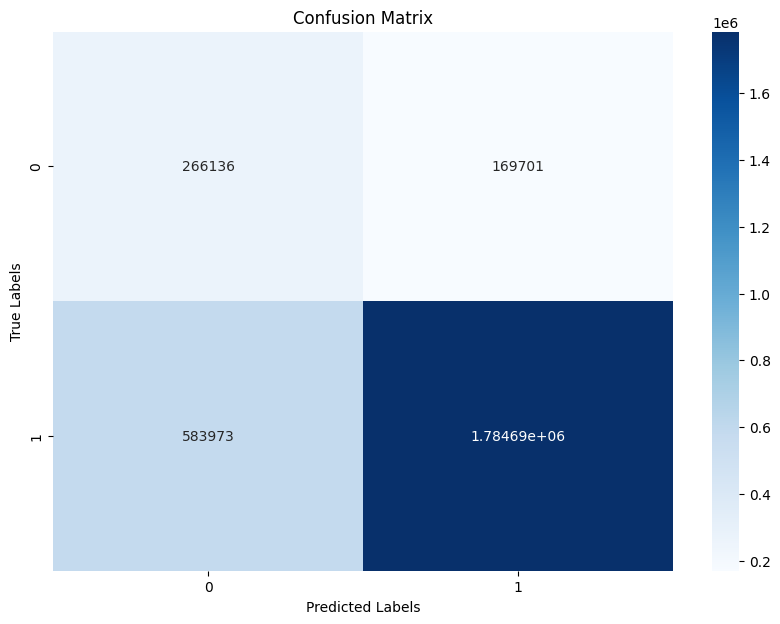

In [10]:
confusion_matrix = metrics.confusionMatrix().toArray()

print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()